<a href="https://colab.research.google.com/github/muhammad-shahid0749/Certificates/blob/master/clip_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -q -U tensorflow-hub tensorflow-text tensorflow-addons

     |████████████████████████████████| 5.9 MB 13.4 MB/s 
     |████████████████████████████████| 1.1 MB 60.1 MB/s 
     |████████████████████████████████| 578.0 MB 15 kB/s 
     |████████████████████████████████| 5.9 MB 54.5 MB/s 
     |████████████████████████████████| 1.7 MB 51.6 MB/s 
     |████████████████████████████████| 438 kB 73.1 MB/s 


In [2]:
print("hello")

hello


In [3]:
import os
import collections
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

# Suppressing tf.hub warnings
tf.get_logger().setLevel("ERROR")

In [4]:
root_dir = "datasets"
annotations_dir = os.path.join(root_dir, "annotations")
images_dir = os.path.join(root_dir, "train2014")
tfrecords_dir = os.path.join(root_dir, "tfrecords")
annotation_file = os.path.join(annotations_dir, "captions_train2014.json")

# Download caption annotation files
if not os.path.exists(annotations_dir):
    annotation_zip = tf.keras.utils.get_file(
        "captions.zip",
        cache_dir=os.path.abspath("."),
        origin="http://images.cocodataset.org/annotations/annotations_trainval2014.zip",
        extract=True,
    )
    os.remove(annotation_zip)

# Download image files
if not os.path.exists(images_dir):
    image_zip = tf.keras.utils.get_file(
        "train2014.zip",
        cache_dir=os.path.abspath("."),
        origin="http://images.cocodataset.org/zips/train2014.zip",
        extract=True,
    )
    os.remove(image_zip)

print("Dataset is downloaded and extracted successfully.")

with open(annotation_file, "r") as f:
    annotations = json.load(f)["annotations"]

image_path_to_caption = collections.defaultdict(list)
for element in annotations:
    caption = f"{element['caption'].lower().rstrip('.')}"
    image_path = images_dir + "/COCO_train2014_" + "%012d.jpg" % (element["image_id"])
    image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
print(f"Number of images: {len(image_paths)}")

13510573713/13510573713 [==============================] - 384s 0us/step
Dataset is downloaded and extracted successfully.
Number of images: 82783


In [5]:
train_size = 30000
valid_size = 5000
captions_per_image = 2
images_per_file = 2000

train_image_paths = image_paths[:train_size]
num_train_files = int(np.ceil(train_size / images_per_file))
train_files_prefix = os.path.join(tfrecords_dir, "train")

valid_image_paths = image_paths[-valid_size:]
num_valid_files = int(np.ceil(valid_size / images_per_file))
valid_files_prefix = os.path.join(tfrecords_dir, "valid")

tf.io.gfile.makedirs(tfrecords_dir)


def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def create_example(image_path, caption):
    feature = {
        "caption": bytes_feature(caption.encode()),
        "raw_image": bytes_feature(tf.io.read_file(image_path).numpy()),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


def write_tfrecords(file_name, image_paths):
    caption_list = []
    image_path_list = []
    for image_path in image_paths:
        captions = image_path_to_caption[image_path][:captions_per_image]
        caption_list.extend(captions)
        image_path_list.extend([image_path] * len(captions))

    with tf.io.TFRecordWriter(file_name) as writer:
        for example_idx in range(len(image_path_list)):
            example = create_example(
                image_path_list[example_idx], caption_list[example_idx]
            )
            writer.write(example.SerializeToString())
    return example_idx + 1

def write_data(image_paths, num_files, files_prefix):
    example_counter = 0
    for file_idx in tqdm(range(num_files)):
        file_name = files_prefix + "-%02d.tfrecord" % (file_idx)
        start_idx = images_per_file * file_idx
        end_idx = start_idx + images_per_file
        example_counter += write_tfrecords(file_name, image_paths[start_idx:end_idx])
    return example_counter


train_example_count = write_data(train_image_paths, num_train_files, train_files_prefix)
print(f"{train_example_count} training examples were written to tfrecord files.")

valid_example_count = write_data(valid_image_paths, num_valid_files, valid_files_prefix)
print(f"{valid_example_count} evaluation examples were written to tfrecord files.")        

100%|██████████| 15/15 [02:22<00:00,  9.49s/it]


60000 training examples were written to tfrecord files.


100%|██████████| 3/3 [00:23<00:00,  7.73s/it]

10000 evaluation examples were written to tfrecord files.


In [6]:
feature_description = {
    "caption": tf.io.FixedLenFeature([], tf.string),
    "raw_image": tf.io.FixedLenFeature([], tf.string),
}


def read_example(example):
    features = tf.io.parse_single_example(example, feature_description)
    raw_image = features.pop("raw_image")
    features["image"] = tf.image.resize(
        tf.image.decode_jpeg(raw_image, channels=3), size=(299, 299)
    )
    return features


def get_dataset(file_pattern, batch_size):

    return (
        tf.data.TFRecordDataset(tf.data.Dataset.list_files(file_pattern))
        .map(
            read_example,
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=False,
        )
        .shuffle(batch_size * 10)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
        .batch(batch_size)
    )

In [7]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = layers.Dense(projection_dims)(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Add()([projected_embeddings, x])
        projected_embeddings = layers.LayerNormalization()(x)
    return projected_embeddings

In [8]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained Xception model to be used as the base encoder.
    xception = keras.applications.Xception(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in xception.layers:
        layer.trainable = trainable
    # Receive the images as inputs.
    inputs = layers.Input(shape=(299, 299, 3), name="image_input")
    # Preprocess the input image.
    xception_input = tf.keras.applications.xception.preprocess_input(inputs)
    # Generate the embeddings for the images using the xception model.
    embeddings = xception(xception_input)
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model(inputs, outputs, name="vision_encoder")

In [9]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the BERT preprocessing module.
    preprocess = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2",
        name="text_preprocessing",
    )
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",
        name="bert",
    )
    # Set the trainability of the base encoder.
    bert.trainable = trainable
    # Receive the text as inputs.
    inputs = layers.Input(shape=(), dtype=tf.string, name="text_input")
    # Preprocess the text.
    bert_inputs = preprocess(inputs)
    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(bert_inputs)["pooled_output"]
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

In [10]:
class DualEncoder(keras.Model):
    def __init__(self, text_encoder, image_encoder, temperature=1.0, **kwargs):
        super(DualEncoder, self).__init__(**kwargs)
        self.text_encoder = text_encoder
        self.image_encoder = image_encoder
        self.temperature = temperature
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, features, training=False):
        # Place each encoder on a separate GPU (if available).
        # TF will fallback on available devices if there are fewer than 2 GPUs.
        with tf.device("/gpu:0"):
            # Get the embeddings for the captions.
            caption_embeddings = text_encoder(features["caption"], training=training)
        with tf.device("/gpu:1"):
            # Get the embeddings for the images.
            image_embeddings = vision_encoder(features["image"], training=training)
        return caption_embeddings, image_embeddings

    def compute_loss(self, caption_embeddings, image_embeddings):
        # logits[i][j] is the dot_similarity(caption_i, image_j).
        logits = (
            tf.matmul(caption_embeddings, image_embeddings, transpose_b=True)
            / self.temperature
        )
        # images_similarity[i][j] is the dot_similarity(image_i, image_j).
        images_similarity = tf.matmul(
            image_embeddings, image_embeddings, transpose_b=True
        )
        # captions_similarity[i][j] is the dot_similarity(caption_i, caption_j).
        captions_similarity = tf.matmul(
            caption_embeddings, caption_embeddings, transpose_b=True
        )
        # targets[i][j] = avarage dot_similarity(caption_i, caption_j) and dot_similarity(image_i, image_j).
        targets = keras.activations.softmax(
            (captions_similarity + images_similarity) / (2 * self.temperature)
        )
        # Compute the loss for the captions using crossentropy
        captions_loss = keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )
        # Compute the loss for the images using crossentropy
        images_loss = keras.losses.categorical_crossentropy(
            y_true=tf.transpose(targets), y_pred=tf.transpose(logits), from_logits=True
        )
        # Return the mean of the loss over the batch.
        return (captions_loss + images_loss) / 2

    def train_step(self, features):
        with tf.GradientTape() as tape:
            # Forward pass
            caption_embeddings, image_embeddings = self(features, training=True)
            loss = self.compute_loss(caption_embeddings, image_embeddings)
        # Backward pass
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Monitor loss
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, features):
        caption_embeddings, image_embeddings = self(features, training=False)
        loss = self.compute_loss(caption_embeddings, image_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [39]:
num_epochs = 30  # In practice, train for at least 30 epochs
batch_size = 256

vision_encoder = create_vision_encoder(
    num_projection_layers=1, projection_dims=256, dropout_rate=0.1
)
text_encoder = create_text_encoder(
    num_projection_layers=1, projection_dims=256, dropout_rate=0.1
)
dual_encoder = DualEncoder(text_encoder, vision_encoder, temperature=0.05)
dual_encoder.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001)
)

In [ ]:
print(f"Number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")
print(f"Number of examples (caption-image pairs): {train_example_count}")
print(f"Batch size: {batch_size}")
print(f"Steps per epoch: {int(np.ceil(train_example_count / batch_size))}")
train_dataset = get_dataset(os.path.join(tfrecords_dir, "train-*.tfrecord"), batch_size)
valid_dataset = get_dataset(os.path.join(tfrecords_dir, "valid-*.tfrecord"), batch_size)
# Create a learning rate scheduler callback.
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3
)
# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
history = dual_encoder.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=[reduce_lr, early_stopping],
)
print("Training completed. Saving vision and text encoders...")
vision_encoder.save("vision_encoder")
text_encoder.save("text_encoder")
print("Models are saved.")

Number of GPUs: 1
Number of examples (caption-image pairs): 60000
Batch size: 256
Steps per epoch: 235
Epoch 1/30
235/235 [==============================] - 1266s 5s/step - loss: 61.6737 - val_loss: 10.2250 - lr: 0.0010
Epoch 2/30
235/235 [==============================] - 1251s 5s/step - loss: 7.8787 - val_loss: 5.1121 - lr: 0.0010
Epoch 3/30
235/235 [==============================] - 1246s 5s/step - loss: 4.5070 - val_loss: 4.7816 - lr: 0.0010
Epoch 4/30
235/235 [==============================] - 1250s 5s/step - loss: 3.8529 - val_loss: 4.5814 - lr: 0.0010
Epoch 5/30
235/235 [==============================] - 1248s 5s/step - loss: 3.4328 - val_loss: 4.1839 - lr: 0.0010
Epoch 6/30
235/235 [==============================] - 1256s 5s/step - loss: 3.1516 - val_loss: 3.9962 - lr: 0.0010
Epoch 7/30
 79/235 [=========>....................] - ETA: 11:48 - loss: 2.8416

In [13]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

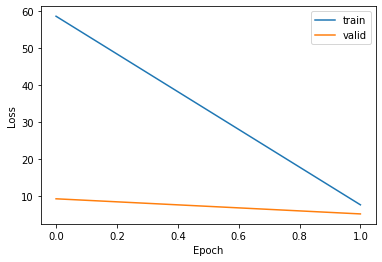

In [23]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

In [25]:
print("Loading vision and text encoders...")
vision_encoder = keras.models.load_model("vision_encoder")
text_encoder = keras.models.load_model("text_encoder")
print("Models are loaded.")


def read_image(image_path):
    image_array = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
    return tf.image.resize(image_array, (299, 299))


print(f"Generating embeddings for {len(image_paths)} images...")
image_embeddings = vision_encoder.predict(
    tf.data.Dataset.from_tensor_slices(image_paths).map(read_image).batch(batch_size),
    verbose=1,
)
print(f"Image embeddings shape: {image_embeddings.shape}.")

Loading vision and text encoders...
Models are loaded.
Generating embeddings for 82783 images...
324/324 [==============================] - 646s 2s/step
Image embeddings shape: (82783, 256).


In [26]:
def find_matches(image_embeddings, queries, k=9, normalize=True):
    # Get the embedding for the query.
    query_embedding = text_encoder(tf.convert_to_tensor(queries))
    # Normalize the query and the image embeddings.
    print("printin normaize value",normalize)
    if normalize:
        image_embeddings = tf.math.l2_normalize(image_embeddings, axis=1)
        #print(image_embeddings)
        query_embedding = tf.math.l2_normalize(query_embedding, axis=1)
        #print(query_embedding)
    # Compute the dot product between the query and the image embeddings.
    dot_similarity = tf.matmul(query_embedding, image_embeddings, transpose_b=True)
    # Retrieve top k indices.
    results = tf.math.top_k(dot_similarity, k).indices.numpy()
    # Return matching image paths.
    return [[image_paths[idx] for idx in indices] for indices in results]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01308062  0.00100473  0.10127739 -0.05603605 -0.00804563 -0.06620304
   0.02736704  0.08088618  0.02145567  0.17746738 -0.00243405 -0.00769556
  -0.05143016 -0.01647448 -0.10800258  0.00396644 -0.01020464  0.01008106
  -0.04555349  0.22257388 -0.01924643 -0.05009554  0.0826292  -0.07076339
  -0.04510961 -0.01616476 -0.03119332 -0.00122854 -0.02298315  0.13913208
  -0.10583176 -0.03098485  0.0100127  -0.0534812  -0

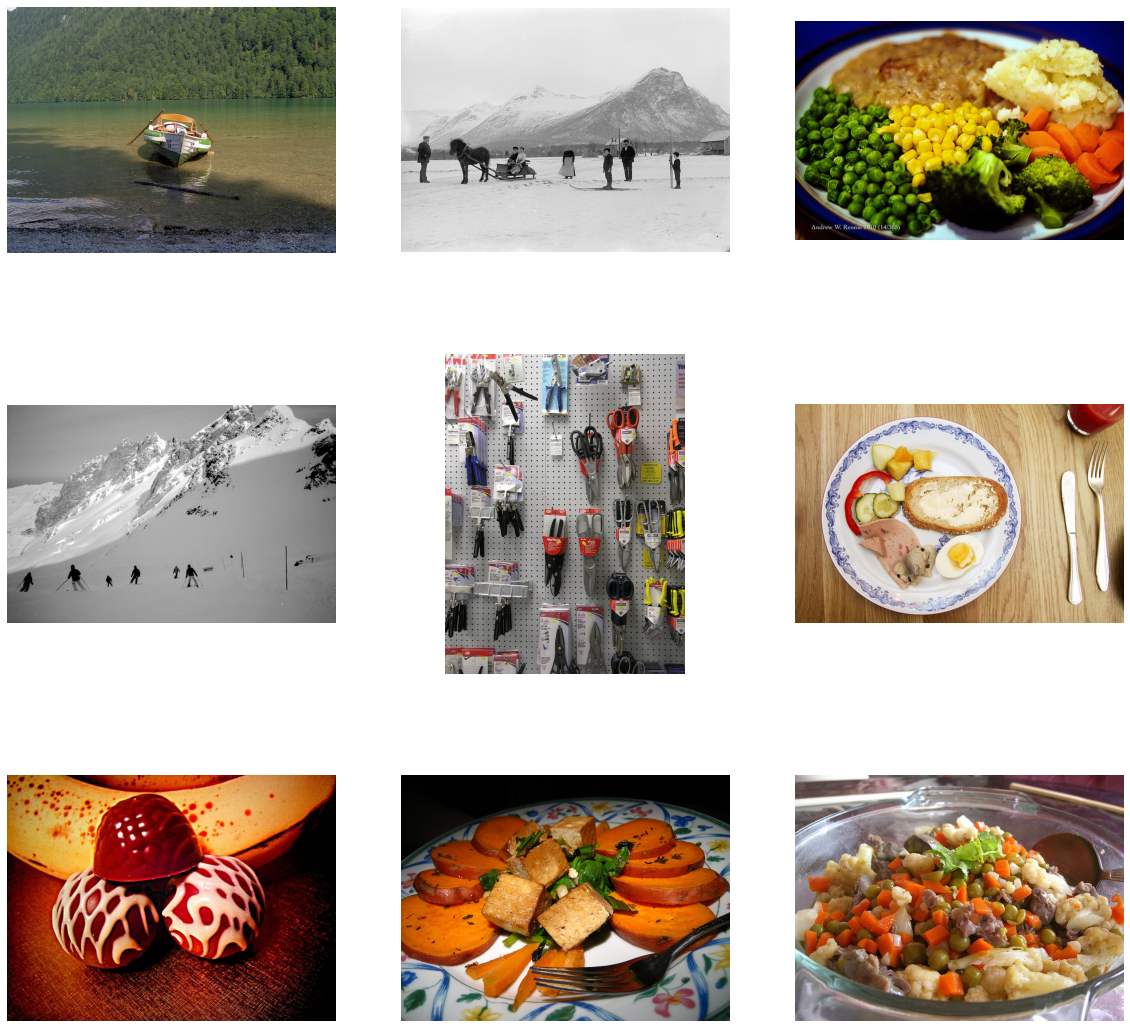

In [28]:
query = "a family of animals."
matches = find_matches(image_embeddings, [query], normalize=True)[0]

plt.figure(figsize=(20, 20))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(mpimg.imread(matches[i]))
    plt.axis("off")

In [29]:
def compute_top_k_accuracy(image_paths, k=100):
    hits = 0
    num_batches = int(np.ceil(len(image_paths) / batch_size))
    for idx in tqdm(range(num_batches)):
        start_idx = idx * batch_size
        end_idx = start_idx + batch_size
        current_image_paths = image_paths[start_idx:end_idx]
        queries = [
            image_path_to_caption[image_path][0] for image_path in current_image_paths
        ]
        result = find_matches(image_embeddings, queries, k)
        hits += sum(
            [
                image_path in matches
                for (image_path, matches) in list(zip(current_image_paths, result))
            ]
        )

    return hits / len(image_paths)


print("Scoring training data...")
train_accuracy = compute_top_k_accuracy(train_image_paths)
print(f"Train accuracy: {round(train_accuracy * 100, 3)}%")

print("Scoring evaluation data...")
eval_accuracy = compute_top_k_accuracy(image_paths[train_size:])
print(f"Eval accuracy: {round(eval_accuracy * 100, 3)}%")

Scoring training data...


  0%|          | 0/118 [00:00<?, ?it/s]

printin normaize value True


  1%|          | 1/118 [00:04<08:05,  4.15s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01857072 -0.01686158  0.10445147 ... -0.00820402  0.12584417
   0.01638379]
 [-0.02095004 -0.01734766  0.10556118 ... -0.00253094  0.12326101
   0.0113183 ]
 [-0.02019087 -0.01092288  0.10547507 ... -0.00522453  0.13223109
   0.0168588 ]
 ...
 [-0.01174506  0.00181312  0.10429438 ... -0.00497717  0.13301228
   0.01771934]
 [-0.02055735 -0.00344545  0.10541076 ... -0.00726128  0.13090214
   0.01653261]
 [-0.01712354 -0.01654554  0.10110532 ..

  2%|▏         | 2/118 [00:07<06:39,  3.45s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01674128 -0.01175013  0.10781419 ... -0.00425489  0.12710832
   0.01063152]
 [-0.01928123 -0.00568501  0.10659824 ... -0.00787035  0.12710138
   0.01628012]
 [-0.01673095 -0.02013456  0.10300398 ... -0.00446432  0.12481623
   0.01396764]
 ...
 [-0.01515355 -0.01127953  0.11071181 ... -0.00365033  0.12963101
   0.01438394]
 [-0.0165814  -0.0204018   0.10357978 ...  0.00352052  0.12410458
   0.01646288]
 [-0.01888091 -0.01119124  0.10216008 ..

  3%|▎         | 3/118 [00:09<05:44,  2.99s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.0223018  -0.00045732  0.10792983 ... -0.00341426  0.13494407
   0.01010101]
 [-0.01763328 -0.02440243  0.10609421 ... -0.00283407  0.12719208
   0.01634503]
 [-0.02057586  0.00156157  0.1124879  ... -0.00772759  0.12697339
   0.01781482]
 ...
 [-0.02205975 -0.01612272  0.10243024 ... -0.00031116  0.12244853
   0.01488192]
 [-0.01318855 -0.01562225  0.10742701 ... -0.01083202  0.13164203
   0.01539558]
 [-0.02065051 -0.02031127  0.10211685 ..

  3%|▎         | 4/118 [00:11<05:15,  2.77s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01510644 -0.01775871  0.10611282 ... -0.0092215   0.12654716
   0.00919244]
 [-0.01850164 -0.0108674   0.10511664 ... -0.0091386   0.1258142
   0.01428815]
 [-0.0201692  -0.00897808  0.10541373 ... -0.00140379  0.11630169
   0.01635042]
 ...
 [-0.02072886 -0.01849254  0.10083074 ... -0.00421821  0.12129957
   0.01648585]
 [-0.02414098 -0.01279719  0.10333286 ...  0.00042037  0.1267223
   0.01571954]
 [-0.02129124 

  4%|▍         | 5/118 [00:14<04:56,  2.63s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01489325 -0.00811006  0.1034359  ... -0.00734487  0.13311067
   0.01015964]
 [-0.02176314 -0.00456658  0.10425411 ... -0.00678942  0.12092713
   0.01362417]
 [-0.01404781 -0.02429817  0.09996881 ... -0.00100146  0.12249321
   0.0171136 ]
 ...
 [-0.02130811 -0.00396436  0.11119971 ... -0.0001877   0.1293036
   0.01249769]
 [-0.01525646 -0.02257309  0.10415068 ... -0.0061141   0.12358054
   0.016109  ]
 [-0.0175392   0.00072137  0.10803362 ...

  5%|▌         | 6/118 [00:16<04:46,  2.56s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01408803 -0.00764238  0.10438751 ... -0.005564    0.13121407
   0.01422903]
 [-0.01975522 -0.00811637  0.11448795 ... -0.00497646  0.12676641
   0.01260462]
 [-0.01577604 -0.0043503   0.10525797 ... -0.00630744  0.12553272
   0.01111805]
 ...
 [-0.01473229 -0.01525666  0.10780545 ... -0.00066085  0.13088001
   0.01735935]
 [-0.0139491  -0.01641262  0.10857233 ... -0.00592508  0.13095772
   0.00875701]
 [-0.0209220

  6%|▌         | 7/118 [00:19<04:41,  2.53s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02271394 -0.01672723  0.09913236 ... -0.00046035  0.12944739
   0.01776334]
 [-0.02004508 -0.00117381  0.1096383  ... -0.00575728  0.1309885
   0.01200134]
 [-0.01933549 -0.01343624  0.09909567 ... -0.00460696  0.13456307
   0.01152949]
 ...
 [-0.01262533 -0.01670601  0.10557908 ... -0.00649953  0.12615372
   0.01856995]
 [-0.01935793 -0.01619477  0.09782919 ... -0.00113555  0.11859448
   0.01766369]
 [-0.01956833

  7%|▋         | 8/118 [00:21<04:36,  2.52s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02303504 -0.00334588  0.10244894 ... -0.00249015  0.12452866
   0.01682699]
 [-0.01714898 -0.02224762  0.11188924 ... -0.00351311  0.13387096
   0.01353281]
 [-0.0220991  -0.00818669  0.10293049 ...  0.00289126  0.12387334
   0.01571941]
 ...
 [-0.01565732 -0.01538097  0.10106352 ... -0.00775261  0.12597698
   0.0151182 ]
 [-0.01988315 -0.00689755  0.10270423 ... -0.00933422  0.12735946
   0.01592802]
 [-0.01646213 -0.00254058  0.1081766  ..

  8%|▊         | 9/118 [00:24<04:31,  2.49s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-2.41514537e-02 -3.73453695e-05  1.07225716e-01 ... -9.50263068e-03
   1.22523315e-01  1.57102924e-02]
 [-1.79079082e-02 -2.06441786e-02  9.85335857e-02 ...  3.37556493e-03
   1.22231543e-01  1.46647915e-02]
 [-1.75492726e-02 -1.00251883e-02  1.02838852e-01 ... -8.99733603e-03
   1.29786745e-01  1.95347127e-02]
 ...
 [-1.75214391e-02 -1.42349442e-02  9.99334678e-02 ... -1.37976427e-02
   1.20287716e-01  1.63489729e-0

  8%|▊         | 10/118 [00:26<04:28,  2.48s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02279341 -0.00417272  0.11180943 ... -0.00216727  0.13651468
   0.01618328]
 [-0.02133542 -0.00965494  0.10498952 ... -0.0099347   0.12713774
   0.01892673]
 [-0.01335848  0.00212779  0.10796398 ... -0.01238871  0.13661374
   0.0131184 ]
 ...
 [-0.01182542 -0.00619139  0.10135792 ... -0.00606885  0.12729515
   0.01377901]
 [-0.01921991 -0.01346555  0.104458   ... -0.00089656  0.13512415
   0.00776512]
 [-0.02015926 -0.01676162  0.10679232 ..

  9%|▉         | 11/118 [00:29<04:24,  2.47s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02089076 -0.00488587  0.10583204 ... -0.00616223  0.13102269
   0.01912494]
 [-0.01551965 -0.02297764  0.10555167 ... -0.0038895   0.12539852
   0.01594174]
 [-0.008994   -0.01503869  0.10351412 ... -0.00035425  0.12494506
   0.00866444]
 ...
 [-0.02306357 -0.00716736  0.10235144 ... -0.00595262  0.12990578
   0.01047426]
 [-0.02100498 -0.00413328  0.10426319 ... -0.00748446  0.12778157
   0.01947385]
 [-0.0212101

 10%|█         | 12/118 [00:31<04:19,  2.45s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02052481 -0.00147688  0.11016342 ... -0.00555147  0.12132416
   0.01252622]
 [-0.01960649 -0.01960403  0.10417658 ... -0.00824016  0.12635021
   0.0156643 ]
 [-0.01163368 -0.01277963  0.11137506 ... -0.00223195  0.13776167
   0.01378295]
 ...
 [-0.01263115 -0.01377038  0.10095433 ... -0.00454917  0.13091885
   0.005945  ]
 [-0.01409017 -0.01616606  0.09934404 ... -0.00527855  0.12411056
   0.01417314]
 [-0.01758429 -0.00503039  0.10597939 ..

 11%|█         | 13/118 [00:33<04:15,  2.44s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02128729 -0.00859407  0.10204097 ... -0.00379136  0.12935974
   0.01551181]
 [-0.01942302 -0.00134377  0.10952251 ... -0.00407694  0.12883621
   0.01564033]
 [-0.01785533 -0.0134969   0.10839995 ... -0.0020158   0.12389575
   0.01073678]
 ...
 [-0.02158907 -0.00615661  0.10569476 ... -0.00349534  0.12837581
   0.0163375 ]
 [-0.01225669 -0.01452355  0.11250835 ... -0.00200082  0.12349899
   0.01112458]
 [-0.01797514 -0.01997779  0.10976396 ..

 12%|█▏        | 14/118 [00:36<04:13,  2.44s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.0218725  -0.01035459  0.11127377 ... -0.01664802  0.1293572
   0.00980972]
 [-0.01772402 -0.0136536   0.10500675 ... -0.00203386  0.12206474
   0.01706427]
 [-0.01434747 -0.02044247  0.10064416 ... -0.00030277  0.12210474
   0.01445843]
 ...
 [-0.01949555 -0.0135015   0.10514991 ... -0.00749526  0.12467124
   0.01395058]
 [-0.01829715 -0.0168082   0.10799652 ... -0.00923238  0.12879469
   0.01482415]
 [-0.01424062 -0.01501417  0.1044404  ...

 13%|█▎        | 15/118 [00:38<04:10,  2.43s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01581275 -0.02041582  0.10087118 ... -0.00611285  0.12401641
   0.01894459]
 [-0.01363597 -0.01490748  0.1107608  ... -0.00211667  0.13206112
   0.01659241]
 [-0.01857231 -0.02000497  0.09938208 ... -0.00032089  0.12026431
   0.01495902]
 ...
 [-0.0188292  -0.01656531  0.10436453 ... -0.00260711  0.12784483
   0.01597107]
 [-0.01943239 -0.01837826  0.10406983 ... -0.00649445  0.12454049
   0.01635322]
 [-0.0299061

 14%|█▎        | 16/118 [00:41<04:07,  2.43s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-1.99637227e-02 -1.88897345e-02  1.09741218e-01 ...  6.00429712e-06
   1.28933758e-01  1.55619690e-02]
 [-2.05145795e-02 -1.86791979e-02  1.06460690e-01 ... -3.99136031e-03
   1.27626225e-01  1.57693997e-02]
 [-1.60799176e-02 -3.59740085e-03  1.05441645e-01 ... -4.93999990e-03
   1.17886968e-01  1.59753822e-02]
 ...
 [-1.50078079e-02 -1.03778420e-02  1.03894502e-01 ... -5.66254882e-03
   1.20583467e-01  9.43129510e-0

 14%|█▍        | 17/118 [00:43<04:04,  2.42s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02178374 -0.00574902  0.10650735 ... -0.00842059  0.13027838
   0.01291054]
 [-0.02048992 -0.00390396  0.10758956 ... -0.0040066   0.13127802
   0.01497967]
 [-0.01513802 -0.01125289  0.10616104 ... -0.00609912  0.13274373
   0.00881051]
 ...
 [-0.02199805 -0.00506573  0.1067045  ... -0.00763599  0.13107973
   0.01792159]
 [-0.01831012 -0.00354703  0.10791743 ... -0.01041903  0.13482581
   0.01288438]
 [-0.01485514 -0.02529218  0.10399104 ..

 15%|█▌        | 18/118 [00:45<04:01,  2.42s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01761987 -0.01932471  0.10235646 ... -0.00090397  0.12683369
   0.01461894]
 [-0.01662316 -0.00811912  0.10606952 ... -0.00581542  0.12390741
   0.01731344]
 [-0.02155033 -0.00920955  0.10902184 ... -0.00890382  0.13071023
   0.01329557]
 ...
 [-0.02161745 -0.01087013  0.10854366 ... -0.0063673   0.12591936
   0.01590996]
 [-0.02110901 -0.00755142  0.10501499 ... -0.00276134  0.12292881
   0.01232934]
 [-0.00994172 -0.0117287   0.1068183  ..

 16%|█▌        | 19/118 [00:48<03:57,  2.40s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01298549  0.00521825  0.1045993  ... -0.0067836   0.12811808
   0.01004277]
 [-0.01780891 -0.01652373  0.10450465 ...  0.00143325  0.12455071
   0.0139701 ]
 [-0.02017573 -0.00531863  0.10839139 ... -0.00294402  0.12870646
   0.0110863 ]
 ...
 [-0.0191164  -0.01457981  0.10193216 ... -0.00275256  0.12655735
   0.0165179 ]
 [-0.02053246 -0.02306312  0.11354042 ... -0.00484681  0.13082726
   0.00597489]
 [-0.01656607 -0.00596441  0.10410684 ..

 17%|█▋        | 20/118 [00:50<03:56,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-2.46336181e-02 -7.20910216e-03  1.06225953e-01 ... -6.48527220e-03
   1.29327342e-01  1.91163756e-02]
 [-1.77873485e-02 -1.64473057e-02  1.07430279e-01 ... -6.84590777e-03
   1.24256782e-01  1.13220457e-02]
 [-1.69872176e-02 -1.31966602e-02  1.07433006e-01 ...  1.27097446e-04
   1.26626119e-01  1.39203668e-02]
 ...
 [-1.62554067e-02 -2.15758160e-02  1.08092427e-01 ... -7.76383979e-03
   1.30006269e-01  1.57097913e-0

 18%|█▊        | 21/118 [00:53<03:54,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01367873 -0.00183215  0.10802694 ... -0.00738978  0.13239244
   0.00557948]
 [-0.0177405  -0.01275111  0.10658208 ... -0.00079406  0.12569228
   0.01760994]
 [-0.01759759 -0.02065353  0.10994171 ... -0.00303538  0.13009252
   0.01081125]
 ...
 [-0.01796296 -0.01156891  0.10042884 ... -0.00429593  0.12339857
   0.02036826]
 [-0.01529487 -0.01535592  0.1033414  ... -0.00239644  0.1233005
   0.01790468]
 [-0.01986638

 19%|█▊        | 22/118 [00:55<03:53,  2.43s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01518459 -0.0039968   0.10576238 ... -0.0084794   0.12082113
   0.00895278]
 [-0.01348224 -0.01883698  0.09851214 ...  0.00133106  0.1220362
   0.01624374]
 [-0.02256115 -0.01406491  0.10762925 ... -0.00092264  0.12848611
   0.01933226]
 ...
 [-0.01107222 -0.01145729  0.10429011 ... -0.00227919  0.13067392
   0.01125928]
 [-0.02648019 -0.00183213  0.10404765 ... -0.00716842  0.13284828
   0.01479037]
 [-0.01922522 -0.01619138  0.1031141  ...

 19%|█▉        | 23/118 [00:58<03:51,  2.44s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01994084 -0.00514465  0.10266903 ... -0.00936432  0.1304371
   0.01275588]
 [-0.01980726 -0.01911318  0.10820069 ... -0.00579512  0.12598234
   0.01702775]
 [-0.01367885 -0.00173542  0.10920575 ... -0.00304896  0.13172826
   0.01438816]
 ...
 [-0.02118044 -0.00556434  0.1103811  ... -0.00755227  0.13014872
   0.01894288]
 [-0.01728832 -0.00748012  0.1087207  ... -0.00690405  0.1282902
   0.01181326]
 [-0.01926536  0.00056596  0.11522166 ... 

 20%|██        | 24/118 [01:00<03:47,  2.43s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01876923 -0.01815493  0.10825619 ...  0.00554064  0.12536998
   0.01364984]
 [-0.02525535 -0.00158411  0.09870304 ...  0.00195839  0.13713066
   0.01279628]
 [-0.01414498 -0.0167225   0.10904256 ... -0.00697832  0.1365096
   0.02093543]
 ...
 [-0.01559172 -0.0102958   0.10528416 ... -0.00366835  0.12382527
   0.01539341]
 [-0.0184374  -0.01801662  0.10331386 ... -0.00830436  0.12690446
   0.01527593]
 [-0.0163775 

 21%|██        | 25/118 [01:02<03:45,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02067661 -0.00485884  0.10451077 ... -0.00673942  0.13879703
   0.01172877]
 [-0.01986422 -0.01158006  0.10382466 ... -0.00164585  0.12524982
   0.01594131]
 [-0.01257357 -0.00060024  0.10947998 ... -0.00661287  0.126753
   0.01225469]
 ...
 [-0.01585107 -0.00119032  0.11251802 ... -0.0092504   0.13515256
   0.00975556]
 [-0.01356775 -0.01115389  0.09799605 ... -0.00861811  0.12627733
   0.01198867]
 [-0.01283274 

 22%|██▏       | 26/118 [01:05<03:41,  2.41s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01338244 -0.01419986  0.1036275  ... -0.00666429  0.12282743
   0.01354118]
 [-0.01992005 -0.00889018  0.10523825 ... -0.00219031  0.13629872
   0.010354  ]
 [-0.02587014 -0.00364719  0.11349154 ... -0.00841464  0.12715669
   0.01925397]
 ...
 [-0.01239313 -0.01267666  0.10494885 ... -0.00153869  0.13140732
   0.01185002]
 [-0.02159923 -0.00769928  0.10075191 ... -0.00185084  0.13310787
   0.0118077 ]
 [-0.0179301

 23%|██▎       | 27/118 [01:07<03:39,  2.41s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02318633 -0.00344301  0.11457305 ... -0.0040874   0.1343315
   0.0124176 ]
 [-0.0211934  -0.01044591  0.09971308 ... -0.0050204   0.13039605
   0.01319697]
 [-0.01641533 -0.01225708  0.1016318  ... -0.00723886  0.12586854
   0.01578582]
 ...
 [-0.02136256 -0.00429844  0.10837989 ...  0.00054162  0.13449796
   0.01218453]
 [-0.01964772 -0.0040478   0.10215729 ... -0.00693687  0.1276217
   0.01554075]
 [-0.01579536 -0.00040709  0.10639461 ... 

 24%|██▎       | 28/118 [01:10<03:37,  2.41s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01643676 -0.01776752  0.10301991 ... -0.00325496  0.12632206
   0.01706226]
 [-0.01795637 -0.0095229   0.10246807 ... -0.00916958  0.12656307
   0.01808048]
 [-0.01465605 -0.02134348  0.10493086 ... -0.01063072  0.12720941
   0.01126487]
 ...
 [-0.0161535  -0.00826615  0.10116351 ... -0.00217265  0.12848213
   0.01834358]
 [-0.01735551 -0.00377954  0.09994072 ...  0.00787608  0.13109365
   0.01246274]
 [-0.0164932

 25%|██▍       | 29/118 [01:12<03:35,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02061158  0.00117056  0.10694342 ... -0.00104299  0.13109559
   0.0141218 ]
 [-0.01453482 -0.00406038  0.10502157 ... -0.00924286  0.13603017
   0.01096448]
 [-0.02387833 -0.0003159   0.09865073 ... -0.00383694  0.13234305
   0.01276888]
 ...
 [-0.01026452 -0.00060696  0.11249572 ... -0.00809505  0.12586151
   0.01132765]
 [-0.01678308 -0.01131392  0.0977613  ... -0.00224503  0.11901782
   0.01877666]
 [-0.0193736

 25%|██▌       | 30/118 [01:15<03:33,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01560515 -0.02411122  0.10339302 ... -0.00439378  0.12482124
   0.0097131 ]
 [-0.01809152 -0.00979401  0.10009394 ... -0.01055321  0.12514511
   0.01622382]
 [-0.01411305  0.00350083  0.10760096 ... -0.00639521  0.12350217
   0.02154011]
 ...
 [-0.01978423 -0.01086452  0.09930528 ... -0.00575732  0.13683996
   0.01330761]
 [-0.0176581  -0.02350549  0.10214943 ... -0.00795032  0.12360905
   0.01018276]
 [-0.0088523

 26%|██▋       | 31/118 [01:17<03:29,  2.41s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01962106  0.00416899  0.10840987 ... -0.00356165  0.12701513
   0.0097025 ]
 [-0.01770841 -0.00175127  0.10444304 ... -0.00487324  0.13168302
   0.01521533]
 [-0.0216313  -0.01421418  0.10520834 ... -0.0123451   0.12801415
   0.01749472]
 ...
 [-0.00932753 -0.00106414  0.1074319  ...  0.00202769  0.12964535
   0.01303118]
 [-0.02092195  0.0036917   0.10954486 ... -0.0042786   0.13287766
   0.01123   ]
 [-0.0165784

 27%|██▋       | 32/118 [01:19<03:26,  2.40s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01830027 -0.00658619  0.10155705 ... -0.01084863  0.11989985
   0.01470462]
 [-0.02568747 -0.00588389  0.10506359 ... -0.00704475  0.1268742
   0.01791232]
 [-0.02182739 -0.00325579  0.11027215 ... -0.00223615  0.11610971
   0.01565858]
 ...
 [-0.02021112 -0.00407013  0.10163064 ... -0.00853406  0.12599216
   0.01646928]
 [-0.01765617  0.00496158  0.10815182 ... -0.00462318  0.12646
   0.01844262]
 [-0.0226957  -0

 28%|██▊       | 33/118 [01:22<03:26,  2.42s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01984016 -0.01202099  0.11162648 ...  0.0003629   0.12442547
   0.01356002]
 [-0.01594469 -0.00840942  0.10053147 ... -0.00584394  0.12373768
   0.01365799]
 [-0.01625127 -0.00753956  0.10412235 ... -0.00895895  0.13178982
   0.01751809]
 ...
 [-0.01196344 -0.01976118  0.10753555 ... -0.00670292  0.12396368
   0.0119632 ]
 [-0.01713587 -0.00333073  0.10462897 ... -0.00899546  0.13131855
   0.011282  ]
 [-0.0234264  -0.00112602  0.10106588 ..

 29%|██▉       | 34/118 [01:24<03:23,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01626468  0.00268926  0.11074391 ... -0.00607576  0.13004346
   0.01410693]
 [-0.02326384 -0.01394716  0.10356914 ... -0.01268486  0.13141161
   0.0153774 ]
 [-0.020207   -0.01123444  0.10567881 ... -0.00422571  0.12491643
   0.01470015]
 ...
 [-0.01761073 -0.0186553   0.10651031 ... -0.01944198  0.12607849
   0.02024042]
 [-0.01536607 -0.00520235  0.10257811 ... -0.01078543  0.12814276
   0.0100418 ]
 [-0.0166859

 30%|██▉       | 35/118 [01:27<03:23,  2.45s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02098514 -0.00376793  0.11752978 ... -0.00169114  0.12583019
   0.0191347 ]
 [-0.02409503 -0.00035122  0.10426879 ... -0.01008955  0.13335662
   0.01759713]
 [-0.02356604 -0.00367003  0.11385511 ...  0.00097972  0.13172427
   0.01313179]
 ...
 [-0.01913745 -0.00684331  0.11021357 ... -0.00824739  0.13741688
   0.01169177]
 [-0.01407351 -0.00917092  0.10782363 ... -0.00217205  0.12448469
   0.01362716]
 [-0.02153263  0.00043315  0.1093905  ..

 31%|███       | 36/118 [01:29<03:20,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.00929507 -0.01960996  0.10650377 ... -0.00573168  0.12274469
   0.00894238]
 [-0.01690396 -0.00646381  0.10288242 ... -0.00281962  0.1275088
   0.01630245]
 [-0.02096993 -0.0082105   0.10268246 ... -0.00821126  0.125705
   0.01629665]
 ...
 [-0.01495737 -0.00444649  0.09749345 ... -0.00751707  0.12329388
   0.01389446]
 [-0.02020834 -0.0053405   0.11012699 ... -0.00734977  0.12503749
   0.01290804]
 [-0.01675889 -

 31%|███▏      | 37/118 [01:32<03:17,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01514503 -0.00145425  0.11166952 ... -0.00056097  0.1281314
   0.01059107]
 [-0.01703571 -0.0064198   0.10090343 ... -0.01034852  0.12817606
   0.01374742]
 [-0.02047855 -0.01073111  0.10640149 ...  0.00087124  0.1324403
   0.01573646]
 ...
 [-0.02071807 -0.00813044  0.11058839 ... -0.00251874  0.12352143
   0.01145816]
 [-0.01997327 -0.0068941   0.09649116 ...  0.00107497  0.11974742
   0.01171518]
 [-0.0183642  

 32%|███▏      | 38/118 [01:34<03:14,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-1.98511090e-02 -1.16153248e-02  1.06012188e-01 ... -2.62912572e-03
   1.26770988e-01  1.69013143e-02]
 [-1.87750254e-02 -1.65583193e-02  1.02353916e-01 ... -9.18554579e-05
   1.24395490e-01  1.43134175e-02]
 [-1.51983546e-02 -2.17074296e-03  1.05991185e-01 ... -1.36045562e-02
   1.20185256e-01  1.45621421e-02]
 ...
 [-1.96919125e-02 -5.91066387e-03  1.03713445e-01 ... -3.03908344e-03
   1.31664336e-01  1.79528426e-0

 33%|███▎      | 39/118 [01:36<03:12,  2.44s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01823164  0.00055613  0.1052407  ... -0.00501286  0.12943089
   0.01678347]
 [-0.02054656  0.00024371  0.1018035  ... -0.01099288  0.1249736
   0.01710066]
 [-0.01574777 -0.01707221  0.10063919 ... -0.00381603  0.11906075
   0.01714472]
 ...
 [-0.02073114 -0.00247081  0.10180641 ... -0.00715549  0.13919061
   0.01244507]
 [-0.02128945  0.00340889  0.1067443  ... -0.00484208  0.11521049
   0.01654346]
 [-0.01630412 -0.00400226  0.10559945 ...

 34%|███▍      | 40/118 [01:39<03:11,  2.46s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02600892 -0.00672835  0.10578843 ... -0.00903749  0.13311274
   0.01585067]
 [-0.02339612 -0.00327317  0.10602438 ... -0.00615377  0.12833524
   0.01305764]
 [-0.02014699 -0.00534761  0.10474491 ... -0.01161006  0.12810118
   0.01495256]
 ...
 [-0.01993828  0.00258031  0.10827473 ... -0.01110617  0.12252808
   0.01910233]
 [-0.02408419 -0.0024886   0.10575999 ... -0.00851747  0.13230781
   0.01394596]
 [-0.0240144

 35%|███▍      | 41/118 [01:41<03:08,  2.45s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02153345 -0.00060442  0.10707158 ... -0.00690445  0.13016988
   0.0125119 ]
 [-0.00710257  0.00806875  0.11046865 ... -0.00634362  0.1373544
   0.01055206]
 [-0.01012412 -0.00971028  0.10539901 ...  0.00391519  0.12822257
   0.01027172]
 ...
 [-0.02616374 -0.00348498  0.10633634 ... -0.0058602   0.13181323
   0.01480032]
 [-0.01620727 -0.00529715  0.11137757 ... -0.00078323  0.13116896
   0.01776266]
 [-0.0141549 

 36%|███▌      | 42/118 [01:44<03:06,  2.45s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01470519 -0.00863843  0.10136321 ... -0.00730444  0.12560523
   0.01585974]
 [-0.01920372  0.00347009  0.10529123 ... -0.01338577  0.12731534
   0.0166092 ]
 [-0.01750641 -0.00916326  0.10012285 ... -0.00806717  0.12582178
   0.01500178]
 ...
 [-0.01375279 -0.01574487  0.10407501 ... -0.00217717  0.12706146
   0.01746622]
 [-0.02070137 -0.01385362  0.10141327 ... -0.0052022   0.12430921
   0.01282334]
 [-0.0193259

 36%|███▋      | 43/118 [01:46<03:03,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.0080587  -0.01794567  0.10107689 ... -0.00061957  0.1255059
   0.01722831]
 [-0.01864226 -0.00302174  0.10150819 ... -0.0091966   0.12252984
   0.01534929]
 [-0.01085311 -0.00186535  0.10354584 ... -0.00588121  0.13075428
   0.01346385]
 ...
 [-0.00958969 -0.02167601  0.10182416 ... -0.00874677  0.12124787
   0.01286068]
 [-0.01916615 -0.01163884  0.10719378 ...  0.00221407  0.12612471
   0.01510994]
 [-0.01658995

 37%|███▋      | 44/118 [01:49<03:00,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01502351 -0.01302877  0.10516816 ... -0.0101635   0.12699705
   0.01478164]
 [-0.01410857 -0.01445039  0.10197396 ... -0.00499935  0.12572046
   0.01359696]
 [-0.01871525  0.00023251  0.10470559 ... -0.00844723  0.13014962
   0.01227044]
 ...
 [-0.02542991 -0.00285034  0.108666   ... -0.0011084   0.12968469
   0.01437131]
 [-0.01486537 -0.0045627   0.10563313 ... -0.00675657  0.13716713
   0.01393925]
 [-0.0154711

 38%|███▊      | 45/118 [01:52<03:13,  2.65s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01790874 -0.00622226  0.10801525 ... -0.01286631  0.12983517
   0.01634798]
 [-0.01365973 -0.00422429  0.10316008 ... -0.00279238  0.11795935
   0.00928396]
 [-0.01997854 -0.00445027  0.09919555 ... -0.00476394  0.13781244
   0.01740932]
 ...
 [-0.01141922 -0.02103177  0.10214854 ... -0.00453409  0.1281338
   0.01443893]
 [-0.01819445 -0.00411389  0.10290655 ... -0.0020518   0.13755389
   0.01300779]
 [-0.01132251

 39%|███▉      | 46/118 [01:55<03:28,  2.90s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01999441 -0.01997025  0.10738712 ... -0.01352259  0.12364268
   0.01358647]
 [-0.01766909 -0.01116911  0.10247297 ... -0.00787699  0.12341112
   0.01716362]
 [-0.01543872 -0.0192493   0.1044486  ...  0.00350726  0.12992021
   0.01683636]
 ...
 [-0.00888705 -0.01815817  0.10899287 ... -0.00098725  0.12579782
   0.01548564]
 [-0.02365911 -0.00654001  0.10400978 ... -0.00892361  0.12744759
   0.01975992]
 [-0.0079742

 40%|███▉      | 47/118 [01:58<03:15,  2.76s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01467475 -0.00685023  0.10424881 ... -0.00510696  0.1141638
   0.01560564]
 [-0.01206774 -0.00716459  0.10284312 ... -0.00808861  0.12746759
   0.01028772]
 [-0.02515488 -0.01198142  0.10230868 ... -0.01064818  0.12413032
   0.01642468]
 ...
 [-0.01911816 -0.0080756   0.1056473  ... -0.00742029  0.1284194
   0.01389938]
 [-0.02092773 -0.01439578  0.1041679  ... -0.00281971  0.1275429
   0.01812582]
 [-0.0241249  -0.00136401  0.1092038  ... -

 41%|████      | 48/118 [02:00<03:06,  2.66s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01691793 -0.00890195  0.10885877 ... -0.00037274  0.13128164
   0.01312133]
 [-0.01589953 -0.00438423  0.11292687 ... -0.00748307  0.13299331
   0.01446725]
 [-0.02342482 -0.00035624  0.10829256 ... -0.01215351  0.13053364
   0.01344627]
 ...
 [-0.02623065 -0.00517853  0.10341052 ... -0.00517282  0.13072248
   0.01558959]
 [-0.02495726 -0.0032473   0.10472403 ... -0.00555044  0.12931284
   0.01813471]
 [-0.0196398

 42%|████▏     | 49/118 [02:03<02:58,  2.59s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01238911 -0.00048157  0.10586335 ... -0.00332079  0.12770393
   0.01324345]
 [-0.02158655 -0.00469118  0.10722466 ... -0.00730611  0.1323619
   0.01089048]
 [-0.02395828 -0.00243392  0.10065296 ... -0.00899182  0.12795587
   0.01648094]
 ...
 [-0.02019317 -0.00515252  0.10676141 ... -0.0092065   0.13052127
   0.01189299]
 [-0.01926262 -0.02119508  0.10334447 ... -0.0106287   0.12836044
   0.01654536]
 [-0.01348491 -0.01256199  0.11013781 ...

 42%|████▏     | 50/118 [02:05<02:52,  2.54s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01567496 -0.00858162  0.10330264 ... -0.01131013  0.12584536
   0.01324277]
 [-0.01756606 -0.01398101  0.09839513 ... -0.00873632  0.12519938
   0.01945535]
 [-0.01827581 -0.02219952  0.10250182 ...  0.00096492  0.12393694
   0.01832548]
 ...
 [-0.0171799   0.00344791  0.10663377 ... -0.00958365  0.12772855
   0.017705  ]
 [-0.017449   -0.02238142  0.10717225 ... -0.01056948  0.12599237
   0.00864368]
 [-0.01030361 -0.02308276  0.09805475 ..

 43%|████▎     | 51/118 [02:07<02:47,  2.50s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02394343 -0.00466521  0.10392148 ... -0.00529767  0.13020056
   0.01658256]
 [-0.01959901 -0.01199478  0.10587811 ... -0.00740626  0.11969713
   0.0134681 ]
 [-0.01904422  0.00937997  0.10872183 ... -0.01333709  0.12546352
   0.01618734]
 ...
 [-0.02300975 -0.00151253  0.10420181 ... -0.0075569   0.13091578
   0.01564442]
 [-0.02055592 -0.0138461   0.11498266 ... -0.00584071  0.12683512
   0.01673541]
 [-0.0184543

 44%|████▍     | 52/118 [02:10<02:42,  2.47s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02278858 -0.00514037  0.11279047 ... -0.0145709   0.12727676
   0.01108078]
 [-0.01331798 -0.00359772  0.10411156 ... -0.00253462  0.13078663
   0.01593594]
 [-0.01738467 -0.00802558  0.09964241 ... -0.00639249  0.1216171
   0.01839744]
 ...
 [-0.02249986 -0.01406399  0.10362824 ... -0.00093009  0.12995887
   0.01201939]
 [-0.01983455 -0.00778615  0.10564967 ... -0.00890432  0.12606323
   0.01269282]
 [-0.02189146

 45%|████▍     | 53/118 [02:12<02:38,  2.45s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01720119 -0.01003066  0.10597485 ... -0.01038045  0.12489358
   0.0147514 ]
 [-0.01953717 -0.01150886  0.09924945 ... -0.00958648  0.12369118
   0.01766929]
 [-0.01541692 -0.00456083  0.1036732  ... -0.00058987  0.12701015
   0.01291186]
 ...
 [-0.02277319  0.00018086  0.10400645 ... -0.01045711  0.126603
   0.0171507 ]
 [-0.01913578 -0.00132     0.10356732 ... -0.0089679   0.12747218
   0.01419389]
 [-0.01419191 

 46%|████▌     | 54/118 [02:15<02:36,  2.45s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02156708 -0.00691522  0.10854806 ... -0.00739589  0.13384637
   0.02145088]
 [-0.01765746 -0.00098029  0.10921317 ... -0.00562235  0.13488185
   0.01732916]
 [-0.01340351 -0.00088642  0.10349171 ... -0.01043767  0.13281299
   0.01500041]
 ...
 [-0.01038664 -0.01449     0.10140435 ... -0.01159307  0.12703487
   0.01416051]
 [-0.01642305 -0.01789795  0.10290682 ... -0.00908682  0.12621376
   0.01727957]
 [-0.0201839

 47%|████▋     | 55/118 [02:17<02:33,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01507133 -0.00320822  0.09933869 ... -0.00206126  0.12568735
   0.0106102 ]
 [-0.01551852 -0.0080259   0.11142283 ... -0.0095113   0.12818737
   0.01557871]
 [-0.0151695  -0.00908954  0.10570714 ... -0.00718463  0.1360883
   0.00864661]
 ...
 [-0.02041748 -0.00542432  0.1082814  ... -0.00771512  0.13085914
   0.01148727]
 [-0.01791652 -0.00567912  0.09801077 ... -0.00726169  0.13203761
   0.01052023]
 [-0.02272366

 47%|████▋     | 56/118 [02:20<02:31,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01626362  0.00236294  0.1142386  ... -0.0036592   0.13434197
   0.01278474]
 [-0.01968384 -0.01016914  0.10123561 ... -0.01440086  0.12911475
   0.01779581]
 [-0.01345872 -0.00456636  0.10150135 ... -0.01014699  0.12897174
   0.01145899]
 ...
 [-0.01904149 -0.01408669  0.10157993 ... -0.00633205  0.12749302
   0.01623233]
 [-0.01500256 -0.00564475  0.11027607 ... -0.00700132  0.12930569
   0.0151941 ]
 [-0.0225113

 48%|████▊     | 57/118 [02:22<02:28,  2.43s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01609855 -0.00616784  0.0990866  ... -0.0097454   0.12482125
   0.01033608]
 [-0.01758531 -0.01153585  0.10441195 ... -0.00953602  0.12422144
   0.01508418]
 [-0.01711683  0.00225742  0.10508165 ... -0.00662442  0.13240305
   0.02081799]
 ...
 [-0.01997561 -0.00398982  0.10471293 ... -0.00490805  0.12186271
   0.01580471]
 [-0.01652209 -0.00664577  0.10638221 ... -0.00311832  0.13019766
   0.01229117]
 [-0.0079884

 49%|████▉     | 58/118 [02:24<02:26,  2.43s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01756353 -0.02292215  0.1020573  ... -0.00918924  0.11882381
   0.01092917]
 [-0.01785959 -0.01097988  0.11200588 ... -0.00692515  0.13744122
   0.01200065]
 [-0.02344451 -0.00095959  0.10754122 ... -0.00455805  0.12677428
   0.01658991]
 ...
 [-0.016579   -0.00716109  0.10299869 ... -0.01369735  0.1298741
   0.01191435]
 [-0.01654817 -0.01149984  0.1025101  ... -0.00307873  0.12138978
   0.01758487]
 [-0.02310577 -0.00792201  0.10975423 ...

 50%|█████     | 59/118 [02:27<02:24,  2.45s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01393983 -0.01482991  0.10260367 ... -0.0074224   0.12567024
   0.01051115]
 [-0.01647751 -0.00183553  0.10509499 ... -0.01050517  0.12701444
   0.01069317]
 [-0.02663775 -0.00563295  0.10166691 ... -0.00740697  0.13192475
   0.0171396 ]
 ...
 [-0.02026641 -0.00892311  0.10611644 ... -0.00322069  0.12309823
   0.01020263]
 [-0.01959149 -0.00491492  0.11201683 ... -0.00586408  0.1321789
   0.01427384]
 [-0.01357636 -0.00140739  0.10593582 ...

 51%|█████     | 60/118 [02:29<02:21,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01200265 -0.01948356  0.09842557 ... -0.00755597  0.12283105
   0.01484754]
 [-0.01986238 -0.00503864  0.10637746 ... -0.01186367  0.12625411
   0.01557244]
 [-0.01877396 -0.01517636  0.09949421 ... -0.01057173  0.12551223
   0.01452442]
 ...
 [-0.0249366  -0.00892375  0.10672323 ... -0.01306018  0.13113214
   0.0183613 ]
 [-0.01845868 -0.0126884   0.10492179 ... -0.01142433  0.12156858
   0.01450733]
 [-0.0205173

 52%|█████▏    | 61/118 [02:32<02:19,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02377944 -0.00798168  0.10190761 ... -0.00610714  0.1325105
   0.01401409]
 [-0.01450714 -0.00954105  0.10084345 ... -0.00913823  0.12213743
   0.01440844]
 [-0.01689848 -0.00734786  0.10608406 ... -0.00691364  0.12873577
   0.01490394]
 ...
 [-0.02778484 -0.01673173  0.10418322 ...  0.00841161  0.13834868
   0.01576468]
 [-0.01877303 -0.01146986  0.10683483 ... -0.00161477  0.127539
   0.01833607]
 [-0.01426467 -

 53%|█████▎    | 62/118 [02:35<02:23,  2.56s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01929786 -0.0066183   0.10081911 ...  0.00024224  0.13933569
   0.01461151]
 [-0.0213919  -0.0142333   0.10617144 ... -0.00284631  0.12614273
   0.01830691]
 [-0.01695894 -0.00795178  0.10496261 ... -0.00780908  0.13790381
   0.00808587]
 ...
 [-0.01032678 -0.00498558  0.10819846 ... -0.01204673  0.13647303
   0.01242992]
 [-0.01468105 -0.00782439  0.11080391 ... -0.00393229  0.13185906
   0.0144088 ]
 [-0.02215059 -0.01068642  0.10214489 ..

 53%|█████▎    | 63/118 [02:38<02:40,  2.91s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01555205 -0.00548074  0.10663346 ... -0.00856718  0.13013545
   0.01442279]
 [-0.01634313 -0.01128528  0.10166687 ... -0.00290729  0.13081303
   0.01300097]
 [-0.00885571 -0.01128619  0.09717056 ...  0.00063553  0.11846923
   0.01426753]
 ...
 [-0.01346421 -0.00905073  0.1022466  ... -0.01136905  0.12785156
   0.01782766]
 [-0.01750529 -0.00487397  0.10508466 ... -0.00335054  0.13193434
   0.01365817]
 [-0.0126048

 54%|█████▍    | 64/118 [02:41<02:28,  2.75s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01579465 -0.01209349  0.10076895 ... -0.01235122  0.13051
   0.01150254]
 [-0.01932302 -0.00468098  0.10223272 ... -0.00985492  0.12773421
   0.01911185]
 [-0.01431844 -0.00911134  0.10827451 ... -0.01171343  0.13042706
   0.0162483 ]
 ...
 [-0.01690328 -0.00801335  0.10430419 ... -0.00650422  0.12227394
   0.0184866 ]
 [-0.02285747 -0.00669636  0.11010218 ... -0.01298248  0.13294108
   0.01332431]
 [-0.01648859  

 55%|█████▌    | 65/118 [02:43<02:20,  2.65s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.0164001  -0.00689901  0.10331057 ... -0.01577494  0.12331297
   0.01141367]
 [-0.02041708 -0.00416726  0.11129636 ... -0.01314848  0.13320535
   0.01321855]
 [-0.01583643 -0.0091978   0.10881107 ... -0.00815103  0.12361345
   0.00657886]
 ...
 [-0.01819701 -0.01307551  0.10582041 ... -0.01039918  0.12608396
   0.01014705]
 [-0.01854068 -0.01375115  0.10692463 ... -0.0115138   0.1248904
   0.01287037]
 [-0.022655  

 56%|█████▌    | 66/118 [02:45<02:13,  2.57s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02051308 -0.00484338  0.10187177 ... -0.00499847  0.13313179
   0.01426198]
 [-0.01661436 -0.00887713  0.10036375 ... -0.00115669  0.12475339
   0.01725425]
 [-0.02178181 -0.00370438  0.10498173 ... -0.00616719  0.12659177
   0.01430332]
 ...
 [-0.01560502 -0.00405248  0.10447685 ... -0.00864199  0.12931845
   0.01333173]
 [-0.02000215  0.00482836  0.10902859 ... -0.0048913   0.13354433
   0.01535988]
 [-0.0147801

 57%|█████▋    | 67/118 [02:48<02:08,  2.53s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.00831361 -0.02737758  0.09957253 ... -0.01626655  0.12371635
   0.0071666 ]
 [-0.01622004 -0.01227688  0.10831315 ... -0.00671396  0.12398585
   0.01088626]
 [-0.01252822  0.00550888  0.10968355 ... -0.00476297  0.12457958
   0.01322025]
 ...
 [-0.01473642 -0.00276332  0.10442824 ... -0.00449293  0.12882902
   0.01392595]
 [-0.01925977 -0.00806834  0.10396265 ... -0.012806    0.12455281
   0.01841909]
 [-0.0175592

 58%|█████▊    | 68/118 [02:50<02:04,  2.49s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01093645  0.00056979  0.11089854 ...  0.00238051  0.13088705
   0.01684053]
 [-0.02000148 -0.0084212   0.10384142 ... -0.00093955  0.12728196
   0.01384974]
 [-0.01910521 -0.01451956  0.10413542 ... -0.01209447  0.12710413
   0.01408627]
 ...
 [-0.0175426  -0.006513    0.10425545 ... -0.01137563  0.12663871
   0.01575954]
 [-0.01944009 -0.00146383  0.10996047 ... -0.00529211  0.13567835
   0.01316556]
 [-0.0205704

 58%|█████▊    | 69/118 [02:53<02:00,  2.46s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02603847 -0.00494313  0.10653123 ... -0.01017417  0.12719798
   0.01591167]
 [-0.02298609 -0.0085823   0.10627346 ... -0.00928173  0.1331255
   0.01622529]
 [-0.02382779 -0.00663068  0.10672911 ... -0.00511584  0.1272937
   0.0144282 ]
 ...
 [-0.01727563 -0.01257652  0.10442279 ... -0.00865329  0.12464117
   0.01544455]
 [-0.01401362 -0.00038826  0.10804227 ... -0.00611939  0.12888046
   0.00811341]
 [-0.01878963 -0.00699668  0.10444486 ... 

 59%|█████▉    | 70/118 [02:55<01:57,  2.45s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02261497 -0.00538002  0.10531048 ... -0.00226305  0.13013346
   0.01113131]
 [-0.02108563 -0.00881788  0.10578729 ... -0.00617062  0.1261962
   0.01888257]
 [-0.01938364 -0.0082493   0.10698972 ... -0.00475364  0.1284335
   0.01213832]
 ...
 [-0.02451531 -0.00710237  0.1059956  ... -0.00165538  0.13240662
   0.01157139]
 [-0.01669662 -0.01737184  0.10652064 ... -0.00464722  0.12959483
   0.01595964]
 [-0.01464203 

 60%|██████    | 71/118 [02:58<01:55,  2.46s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01932606 -0.00462374  0.10464478 ... -0.00319221  0.13534434
   0.01666668]
 [-0.01331584 -0.01446735  0.1058372  ... -0.01123188  0.12305154
   0.0121686 ]
 [-0.01423647 -0.01540281  0.1023183  ... -0.00428696  0.12681516
   0.01619647]
 ...
 [-0.01893498  0.0062653   0.10743397 ... -0.00802127  0.14161073
   0.0154082 ]
 [-0.01750765 -0.01279906  0.09885943 ... -0.00349681  0.11955891
   0.01152057]
 [-0.0145265

 61%|██████    | 72/118 [03:01<02:08,  2.79s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01681882 -0.00024856  0.1074622  ... -0.00893525  0.12865245
   0.011539  ]
 [-0.0145004  -0.0051458   0.10194681 ... -0.01206157  0.12918057
   0.01736373]
 [-0.0179839  -0.00653148  0.10259001 ... -0.00807553  0.1298706
   0.01084473]
 ...
 [-0.02481221 -0.00646504  0.10367262 ... -0.00274142  0.13138872
   0.01223944]
 [-0.01271192 -0.00250485  0.10805052 ... -0.00779857  0.12903346
   0.0073337 ]
 [-0.02376834 -0.00917357  0.1038184  ...

 62%|██████▏   | 73/118 [03:05<02:14,  2.98s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01680835 -0.00590337  0.10565624 ... -0.01058155  0.12577704
   0.01306587]
 [-0.01803145 -0.00130754  0.10538721 ... -0.01306146  0.13118893
   0.01541056]
 [-0.01567281 -0.00714701  0.10630895 ... -0.01220441  0.12012281
   0.0098625 ]
 ...
 [-0.01656833 -0.00366883  0.1080163  ... -0.00588432  0.13037369
   0.01338351]
 [-0.02183969 -0.00229389  0.10446829 ... -0.0068525   0.12380309
   0.01621256]
 [-0.01660062 -0.00149692  0.102467   ..

 63%|██████▎   | 74/118 [03:07<02:04,  2.82s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02520215 -0.00211708  0.1044561  ... -0.00713271  0.12910321
   0.01670526]
 [-0.01538457 -0.00695284  0.10580319 ... -0.00471446  0.12813431
   0.01543392]
 [-0.0115865  -0.00230512  0.11112022 ... -0.00484938  0.12990716
   0.01588137]
 ...
 [-0.02108428  0.00133014  0.10590927 ... -0.01022833  0.12258213
   0.01558512]
 [-0.02046272 -0.00958879  0.10516072 ... -0.01013254  0.12857336
   0.01746455]
 [-0.01822852 -0.00595668  0.10288678 ..

 64%|██████▎   | 75/118 [03:10<01:56,  2.72s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02151847 -0.00874741  0.10635636 ... -0.01111508  0.1302262
   0.01845729]
 [-0.01660151 -0.00686614  0.10118674 ... -0.00609527  0.12740013
   0.01543566]
 [-0.01560708 -0.00396836  0.10547245 ... -0.00494381  0.1313677
   0.01238946]
 ...
 [-0.02615252 -0.00510547  0.10569749 ... -0.00841614  0.13686547
   0.01589555]
 [-0.01507721 -0.0078661   0.10756536 ... -0.00756062  0.13175535
   0.01237516]
 [-0.01644901 

 64%|██████▍   | 76/118 [03:12<01:50,  2.64s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01671333  0.00122885  0.11098146 ... -0.00477057  0.13346906
   0.00623582]
 [-0.01928172 -0.0048549   0.10719738 ... -0.00403287  0.13295689
   0.01726906]
 [-0.0152385   0.00626922  0.10518935 ... -0.00668603  0.12939517
   0.01094837]
 ...
 [-0.02025305 -0.00728431  0.10685886 ... -0.00802312  0.13398609
   0.01828487]
 [-0.01937001 -0.00945323  0.09986536 ... -0.00546067  0.12793024
   0.01738824]
 [-0.0048942

 65%|██████▌   | 77/118 [03:14<01:45,  2.58s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02466967 -0.01364364  0.10854266 ... -0.01132142  0.12817337
   0.01233854]
 [-0.02208062 -0.0127954   0.10435136 ... -0.01042881  0.12764452
   0.01692272]
 [-0.01748231 -0.01229123  0.10116745 ... -0.00697724  0.12233444
   0.01965642]
 ...
 [-0.01361269 -0.00200085  0.10379974 ... -0.01283099  0.13211961
   0.01478034]
 [-0.01865538 -0.01121901  0.10662507 ... -0.00022498  0.13223791
   0.01289227]
 [-0.01981799 -0.00237131  0.1058955  ..

 66%|██████▌   | 78/118 [03:17<01:41,  2.54s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01444903  0.00138119  0.10273626 ... -0.01384351  0.13359667
   0.01222116]
 [-0.02180523 -0.00521978  0.11165175 ... -0.00538779  0.13804868
   0.0115537 ]
 [-0.01894456 -0.00257673  0.10196092 ... -0.00737906  0.12480409
   0.01353096]
 ...
 [-0.01402941 -0.0101697   0.10219326 ... -0.01161545  0.12406744
   0.0086929 ]
 [-0.01738844 -0.01570819  0.10685598 ... -0.01049766  0.12953688
   0.01457839]
 [-0.02307222 -0.00979085  0.10659336 ..

 67%|██████▋   | 79/118 [03:19<01:37,  2.51s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02039147 -0.00591153  0.10573615 ... -0.01153576  0.12535259
   0.01469552]
 [-0.01953192 -0.00375733  0.10215323 ... -0.00129569  0.13471362
   0.00738412]
 [-0.01901335 -0.00859028  0.10839042 ... -0.00687575  0.13160701
   0.01233963]
 ...
 [-0.01858519 -0.00496339  0.11507213 ... -0.01426141  0.13703084
   0.01910661]
 [-0.02339649 -0.01392369  0.10133345 ... -0.0061308   0.13086773
   0.01796995]
 [-0.0134132

 68%|██████▊   | 80/118 [03:22<01:34,  2.50s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02128796 -0.01541549  0.10418957 ... -0.0185579   0.1333156
   0.01340497]
 [-0.01260598 -0.0069532   0.10091195 ... -0.0077671   0.1290546
   0.00851135]
 [-0.0214466  -0.00455921  0.10387319 ... -0.01273638  0.13155551
   0.01392487]
 ...
 [-0.01995278 -0.0042871   0.10439005 ... -0.01281775  0.12491797
   0.01736235]
 [-0.02050721 -0.01001741  0.10219105 ... -0.01070653  0.1311806
   0.02000163]
 [-0.01542873 -

 69%|██████▊   | 81/118 [03:24<01:31,  2.49s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01762021 -0.00591262  0.10481101 ... -0.00898819  0.12147187
   0.01392746]
 [-0.01798014 -0.02183338  0.10191766 ... -0.01536274  0.1259616
   0.01438157]
 [-0.01662865 -0.01432212  0.10358639 ...  0.00074594  0.13089277
   0.01364831]
 ...
 [-0.01944838 -0.01905681  0.1065642  ... -0.01407301  0.1252542
   0.01604494]
 [-0.02018151 -0.01530164  0.10794123 ... -0.00870979  0.12979908
   0.01502186]
 [-0.01515802 -0.0086028   0.10181328 ... 

 69%|██████▉   | 82/118 [03:27<01:29,  2.49s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01709148 -0.00710014  0.10177876 ... -0.01042618  0.12255655
   0.00903055]
 [-0.019178   -0.0103104   0.09760816 ... -0.00695097  0.12769017
   0.01567836]
 [-0.01989313  0.0012565   0.11271662 ... -0.02312977  0.13560389
   0.02206781]
 ...
 [-0.01269364 -0.0052848   0.10835691 ... -0.00020562  0.1268128
   0.00720373]
 [-0.02814418 -0.0146789   0.10642117 ... -0.00260954  0.13066056
   0.01589136]
 [-0.01710086

 70%|███████   | 83/118 [03:29<01:25,  2.46s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01684027 -0.01111712  0.10455036 ... -0.00053125  0.12919007
   0.01291063]
 [-0.02395992 -0.00806266  0.10822648 ... -0.0055598   0.12810555
   0.01429944]
 [-0.02216154 -0.00715498  0.10901775 ... -0.0061103   0.12578934
   0.00946517]
 ...
 [-0.02420303 -0.01149511  0.10925572 ... -0.01454466  0.12829348
   0.01526918]
 [-0.01697129 -0.01722533  0.10705335 ... -0.00178126  0.1268826
   0.01727386]
 [-0.01859519 -0.00851179  0.10380146 ...

 71%|███████   | 84/118 [03:32<01:22,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02204678 -0.01089199  0.09905966 ... -0.0061621   0.12835787
   0.01629082]
 [-0.01739607  0.00255301  0.10570585 ... -0.01004912  0.13004127
   0.01732413]
 [-0.01966023 -0.00547469  0.10645237 ... -0.00463616  0.12724161
   0.01428831]
 ...
 [-0.02311293 -0.00789895  0.10565424 ... -0.00612874  0.12940092
   0.01685933]
 [-0.00759477 -0.01118533  0.09357465 ... -0.00478863  0.1247997
   0.01129514]
 [-0.02273155

 72%|███████▏  | 85/118 [03:34<01:20,  2.45s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01888731 -0.01058342  0.09835255 ... -0.01358925  0.13187037
   0.01115818]
 [-0.01353228 -0.00799912  0.10625541 ... -0.00854876  0.1309361
   0.00816935]
 [-0.01712522 -0.00754434  0.10722876 ... -0.01297815  0.13248834
   0.01914392]
 ...
 [-0.01683817 -0.00621856  0.10174853 ... -0.00954848  0.13280916
   0.0127056 ]
 [-0.0201493  -0.00322768  0.10707881 ... -0.00727133  0.1327473
   0.01395535]
 [-0.01908022 

 73%|███████▎  | 86/118 [03:36<01:17,  2.44s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.0139287  -0.00538354  0.10787714 ... -0.00799633  0.12906662
   0.00754627]
 [-0.01280187 -0.01825498  0.10087552 ... -0.00680989  0.12607713
   0.01334091]
 [-0.01559219 -0.02220173  0.10079432 ... -0.01367825  0.12441824
   0.01249562]
 ...
 [-0.01940642 -0.00699912  0.10366029 ... -0.0131518   0.1295409
   0.01639445]
 [-0.02163516  0.00164661  0.10925377 ... -0.00840591  0.13028286
   0.01472865]
 [-0.01560128 -0.01404775  0.10161645 ...

 74%|███████▎  | 87/118 [03:39<01:15,  2.43s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01804322 -0.01166073  0.10192067 ... -0.01451076  0.12406353
   0.01951598]
 [-0.01439206 -0.01523246  0.10615663 ... -0.018951    0.12503895
   0.01326168]
 [-0.01584101 -0.01231698  0.10354415 ... -0.0086362   0.12706012
   0.01177022]
 ...
 [-0.0156751  -0.01017089  0.10532776 ... -0.00383383  0.13105191
   0.01413737]
 [-0.01908975 -0.0137644   0.10607199 ... -0.0085542   0.13134885
   0.01779381]
 [-0.0150821

 75%|███████▍  | 88/118 [03:41<01:12,  2.43s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02778004  0.00169561  0.11062519 ... -0.00212511  0.12742114
   0.01318553]
 [-0.01887495 -0.00606786  0.09926458 ... -0.00689535  0.12666672
   0.01442186]
 [-0.0144059  -0.01415384  0.10042804 ... -0.01121035  0.1216488
   0.01666209]
 ...
 [-0.00602158 -0.00777292  0.10137297 ... -0.00382147  0.12493476
   0.01070239]
 [-0.01747167 -0.0093926   0.1095223  ... -0.00982371  0.13270871
   0.01107862]
 [-0.01347713

 75%|███████▌  | 89/118 [03:44<01:10,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01532467 -0.00363409  0.10053331 ... -0.010417    0.12583536
   0.0153929 ]
 [-0.01844163 -0.01407823  0.10077761 ... -0.01652448  0.13006543
   0.01895978]
 [-0.01402321  0.00045557  0.10285528 ... -0.00688756  0.13036744
   0.00958937]
 ...
 [-0.01914866 -0.00387206  0.1095693  ... -0.00481189  0.1288413
   0.01697641]
 [-0.01760011 -0.00251135  0.1083353  ... -0.00304061  0.1247184
   0.0124485 ]
 [-0.01601707 

 76%|███████▋  | 90/118 [03:46<01:08,  2.43s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01844532 -0.00112055  0.10960555 ... -0.00938132  0.13461232
   0.0108663 ]
 [-0.01726645 -0.01017016  0.10397425 ... -0.01563782  0.12467446
   0.01732292]
 [-0.02394534 -0.01076478  0.1044177  ... -0.00950222  0.12644199
   0.0195384 ]
 ...
 [-0.01937567 -0.00921834  0.10614245 ... -0.01524571  0.12752199
   0.0130635 ]
 [-0.01907975 -0.00202434  0.10762202 ... -0.00879207  0.12780282
   0.01089575]
 [-0.0206424

 77%|███████▋  | 91/118 [03:48<01:05,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01944543 -0.01576646  0.11012788 ... -0.01354648  0.12929642
   0.01740141]
 [-0.01895019 -0.00502932  0.0991235  ... -0.01130179  0.13207299
   0.01226718]
 [-0.01742719 -0.01639106  0.10557041 ... -0.01420829  0.12482248
   0.0173733 ]
 ...
 [-0.01973133 -0.00619226  0.10585002 ... -0.00521795  0.1285711
   0.01403051]
 [-0.02457655 -0.00403945  0.11002184 ... -0.00976214  0.13302325
   0.0101592 ]
 [-0.01426157

 78%|███████▊  | 92/118 [03:51<01:02,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01487728  0.00187641  0.10567465 ... -0.00859743  0.1290049
   0.00975664]
 [-0.02282881 -0.00317593  0.10730101 ... -0.00956137  0.12713888
   0.01556876]
 [-0.01245447 -0.0077461   0.10655832 ... -0.00531789  0.13170995
   0.01656423]
 ...
 [-0.01910068 -0.01571597  0.10729937 ... -0.01216681  0.13012908
   0.01534568]
 [-0.02399499 -0.00741747  0.11086996 ... -0.01304467  0.12581836
   0.01328339]
 [-0.02262676

 79%|███████▉  | 93/118 [03:53<01:00,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01898147 -0.00468331  0.10903988 ... -0.0070506   0.1297142
   0.01189384]
 [-0.02222532 -0.01105507  0.10617837 ... -0.01050712  0.12285282
   0.01659499]
 [-0.02045516 -0.01216733  0.10640446 ... -0.00897265  0.12179063
   0.01422322]
 ...
 [-0.0158835  -0.00748443  0.10459216 ... -0.01083457  0.13753328
   0.0163469 ]
 [-0.01750613 -0.0179757   0.10961437 ... -0.00161194  0.13001348
   0.01495989]
 [-0.02305295

 80%|███████▉  | 94/118 [03:56<00:57,  2.41s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01943407 -0.00670553  0.09847119 ... -0.0103966   0.12833744
   0.01491434]
 [-0.01765309 -0.01346763  0.09770983 ... -0.00552237  0.1297459
   0.01514673]
 [-0.0145329  -0.01262502  0.10592434 ... -0.01027791  0.12954488
   0.01724344]
 ...
 [-0.01769698 -0.01520194  0.1030817  ... -0.01533752  0.12273055
   0.01861146]
 [-0.02401145 -0.00943456  0.10710144 ... -0.00799016  0.13150264
   0.01109973]
 [-0.01743229

 81%|████████  | 95/118 [03:58<00:56,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01933703 -0.00561475  0.1106311  ... -0.00634943  0.12757832
   0.01108761]
 [-0.0110558  -0.01378599  0.10607982 ... -0.00642481  0.12721428
   0.01675783]
 [-0.01695608 -0.00933976  0.10391036 ... -0.00252688  0.12723325
   0.01759159]
 ...
 [-0.02336074 -0.01233659  0.11368342 ... -0.01079225  0.12523197
   0.02265261]
 [-0.00907619  0.00236086  0.10928541 ... -0.00457648  0.13124925
   0.01518764]
 [-0.0218466

 81%|████████▏ | 96/118 [04:01<00:53,  2.43s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01700203 -0.01137688  0.10515083 ... -0.01256009  0.12965399
   0.0189014 ]
 [-0.02034331 -0.00587455  0.10809044 ... -0.00983513  0.13350093
   0.01913101]
 [-0.02154036 -0.00473203  0.10926017 ... -0.00314357  0.13393538
   0.01209163]
 ...
 [-0.02138583 -0.01015133  0.10606928 ... -0.01070206  0.12734051
   0.01496414]
 [-0.0174954  -0.00777425  0.10798099 ... -0.0041393   0.120907
   0.0102631 ]
 [-0.01523902 -0.01060263  0.10057537 ... 

 82%|████████▏ | 97/118 [04:03<00:51,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01132252 -0.01697116  0.10497405 ... -0.00158392  0.12062903
   0.01684349]
 [-0.01498616 -0.01366119  0.10822432 ... -0.01188638  0.12471174
   0.01108325]
 [-0.02451106 -0.01193694  0.11138513 ... -0.01705527  0.132094
   0.01544701]
 ...
 [-0.01999136 -0.00716128  0.10537953 ... -0.00741838  0.13165797
   0.00878962]
 [-0.02250116 -0.00262649  0.11065819 ... -0.0087425   0.12934974
   0.02060239]
 [-0.02443293 

 83%|████████▎ | 98/118 [04:06<00:48,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02125387 -0.00905827  0.10412683 ... -0.00518984  0.13158491
   0.0164146 ]
 [-0.01832869 -0.00848021  0.10732767 ... -0.0080536   0.1294837
   0.01564848]
 [-0.01349364 -0.0071595   0.10138243 ... -0.00796328  0.12425245
   0.01501203]
 ...
 [-0.01881901 -0.0047982   0.10504696 ... -0.00705296  0.13192347
   0.01228291]
 [-0.01615881 -0.00793115  0.10924854 ... -0.01175806  0.12773524
   0.00860548]
 [-0.02096036

 84%|████████▍ | 99/118 [04:08<00:46,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01321383 -0.00276349  0.09834248 ... -0.00886031  0.12692642
   0.01244496]
 [-0.02102746 -0.01070596  0.10630051 ... -0.01487942  0.12590802
   0.01937154]
 [-0.01594252 -0.00874225  0.10740873 ... -0.00081127  0.12550052
   0.01582102]
 ...
 [-0.01762961 -0.00635813  0.10251683 ... -0.0121118   0.12903683
   0.01218787]
 [-0.01454509 -0.00516086  0.09996133 ... -0.00372473  0.13474295
   0.01122701]
 [-0.0152967

 85%|████████▍ | 100/118 [04:10<00:43,  2.44s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.0169332  -0.00837456  0.09925574 ... -0.01071438  0.12413792
   0.01555112]
 [-0.02055637 -0.00738299  0.10726173 ...  0.00168706  0.12872708
   0.01478628]
 [-0.02235135 -0.01151144  0.10393415 ... -0.00235396  0.14005415
   0.01518637]
 ...
 [-0.01848994 -0.01393465  0.104      ... -0.00122159  0.12470889
   0.01581773]
 [-0.01302722 -0.01004242  0.10338371 ... -0.01091591  0.12824504
   0.0156428 ]
 [-0.01947624 -0.00922702  0.10628954 ..

 86%|████████▌ | 101/118 [04:13<00:41,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01547153 -0.01555018  0.10867491 ... -0.00713284  0.1238388
   0.01326552]
 [-0.01872039 -0.00018855  0.10423666 ... -0.00730429  0.13119078
   0.01438991]
 [-0.01425412 -0.00936207  0.09779323 ... -0.01088365  0.12668265
   0.01043352]
 ...
 [-0.01529231 -0.01087068  0.10468981 ... -0.01142932  0.12721707
   0.01718687]
 [-0.01979254 -0.01139173  0.10637859 ... -0.00718032  0.12989193
   0.0153606 ]
 [-0.02374644

 86%|████████▋ | 102/118 [04:15<00:38,  2.43s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01590283 -0.00829879  0.10811469 ... -0.01139877  0.13806646
   0.01773708]
 [-0.01302359 -0.00735576  0.10463344 ... -0.00839095  0.13248822
   0.01404245]
 [-0.01557403 -0.01136175  0.10457955 ... -0.00778731  0.1273113
   0.01305933]
 ...
 [-0.01978087 -0.00487701  0.10593241 ... -0.00553609  0.1319295
   0.01057652]
 [-0.01891502 -0.01351139  0.10507163 ... -0.0009      0.13058881
   0.00925058]
 [-0.01343374 

 87%|████████▋ | 103/118 [04:18<00:36,  2.42s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.0192035  -0.00483071  0.10415042 ... -0.00584757  0.12537983
   0.01601781]
 [-0.01945771 -0.00365054  0.1125524  ... -0.00365466  0.1307338
   0.01182558]
 [-0.01984036 -0.00627864  0.10240907 ... -0.00402791  0.12117916
   0.0182715 ]
 ...
 [-0.02066185 -0.01035197  0.10478327 ... -0.00715648  0.13333325
   0.01789524]
 [-0.02280442 -0.0082422   0.10792412 ... -0.00862174  0.13140745
   0.01826267]
 [-0.01804447 -0.00282174  0.10368838 ...

 88%|████████▊ | 104/118 [04:20<00:34,  2.43s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.0167902  -0.00061084  0.11200148 ... -0.0027293   0.13293456
   0.01195575]
 [-0.01717745 -0.01063034  0.10265267 ... -0.00590917  0.13009778
   0.01736141]
 [-0.01569288 -0.00400433  0.101319   ... -0.00971546  0.13431507
   0.01312929]
 ...
 [-0.01617651 -0.00539572  0.10140767 ... -0.0087062   0.12521523
   0.01045996]
 [-0.0283115  -0.01100261  0.10805358 ... -0.0062493   0.12547895
   0.01459554]
 [-0.01311267 -0.00913453  0.10364716 ..

 89%|████████▉ | 105/118 [04:23<00:31,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01957096 -0.00960023  0.09985083 ... -0.00630347  0.13030066
   0.01909406]
 [-0.01548961 -0.01624403  0.10717945 ... -0.00175284  0.12694274
   0.01485675]
 [-0.01294633 -0.01277084  0.10097393 ... -0.00517115  0.12442593
   0.01124429]
 ...
 [-0.01572431 -0.01255526  0.09871252 ... -0.00276166  0.1316097
   0.01466032]
 [-0.01661576 -0.00665341  0.10808519 ... -0.00757264  0.13240536
   0.01151214]
 [-0.02219143

 90%|████████▉ | 106/118 [04:25<00:29,  2.42s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02229557 -0.00127403  0.10894936 ... -0.00975595  0.13010645
   0.01838655]
 [-0.01612302 -0.00811301  0.10705457 ... -0.0116252   0.13204788
   0.00813149]
 [-0.01586054 -0.0122707   0.10474132 ... -0.00881569  0.1274024
   0.01810784]
 ...
 [-0.01534072 -0.00287421  0.10423326 ... -0.00224289  0.13218622
   0.01655576]
 [-0.01829889 -0.00473981  0.10890309 ... -0.00471794  0.13714404
   0.01640304]
 [-0.00984756 -0.0134389   0.112151   ...

 91%|█████████ | 107/118 [04:27<00:26,  2.42s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02111133 -0.02335285  0.10819846 ... -0.00537439  0.12606034
   0.01406733]
 [-0.02065556 -0.01192105  0.11025655 ... -0.01138971  0.13168813
   0.0216522 ]
 [-0.01534497 -0.0078646   0.10564464 ... -0.00506764  0.12508853
   0.01656095]
 ...
 [-0.02334277 -0.00393361  0.10624848 ... -0.00555767  0.12793058
   0.01441203]
 [-0.01761234 -0.00572553  0.10276087 ... -0.00586583  0.12820257
   0.01540089]
 [-0.02026504 -0.00677905  0.11276691 ..

 92%|█████████▏| 108/118 [04:30<00:24,  2.42s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01989392  0.00138848  0.10440297 ... -0.01262408  0.13295554
   0.01702048]
 [-0.01529002 -0.0152491   0.10523972 ... -0.00150988  0.11985204
   0.00786163]
 [-0.01770793 -0.00518257  0.10342838 ... -0.00913512  0.12866499
   0.00996539]
 ...
 [-0.01694339 -0.00497716  0.10400469 ... -0.0057465   0.1252933
   0.0185758 ]
 [-0.0172025  -0.00909146  0.1040608  ... -0.00800657  0.12887996
   0.01488024]
 [-0.01742456 -0.00886146  0.10363289 ...

 92%|█████████▏| 109/118 [04:32<00:21,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01751959 -0.00687587  0.11159774 ... -0.01787602  0.12477701
   0.0144289 ]
 [-0.01822112 -0.00433983  0.1119023  ... -0.00333575  0.1311947
   0.01089616]
 [-0.01764317 -0.00555558  0.10934281 ... -0.00833088  0.13258968
   0.01053548]
 ...
 [-0.01472809 -0.00556384  0.10356399 ... -0.00796153  0.12464779
   0.01452933]
 [-0.02310995 -0.00547627  0.10938366 ... -0.00669802  0.12933655
   0.01459658]
 [-0.02328177

 93%|█████████▎| 110/118 [04:35<00:19,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01048524 -0.00737069  0.10233933 ... -0.00989303  0.1279439
   0.00754292]
 [-0.02498086  0.00048916  0.10456261 ... -0.00198165  0.13358042
   0.0163335 ]
 [-0.0223629  -0.01177038  0.10683808 ... -0.00309028  0.12923616
   0.01840848]
 ...
 [-0.01916579 -0.01517668  0.10130889 ... -0.01091952  0.12636863
   0.01477166]
 [-0.02203644 -0.01143709  0.10766781 ... -0.01491233  0.12479968
   0.01230009]
 [-0.01888486

 94%|█████████▍| 111/118 [04:37<00:17,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01015086 -0.0126312   0.11273745 ... -0.00373415  0.12491988
   0.01863865]
 [-0.02480067 -0.00151385  0.10264165 ... -0.00684067  0.1282238
   0.01718442]
 [-0.02265349 -0.00921689  0.10810656 ... -0.00497198  0.13082902
   0.01102396]
 ...
 [-0.01412627 -0.00533714  0.10697909 ... -0.00907542  0.13502029
   0.00741502]
 [-0.01488988 -0.00407753  0.10825618 ... -0.00834006  0.13411033
   0.01497314]
 [-0.01750354

 95%|█████████▍| 112/118 [04:40<00:14,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.0164979  -0.0033811   0.10750267 ... -0.00697633  0.13081034
   0.01631078]
 [-0.01750497 -0.01785642  0.10659622 ... -0.00519952  0.12612052
   0.00986083]
 [-0.01443408 -0.00538407  0.10201614 ... -0.00812192  0.12674005
   0.01217987]
 ...
 [-0.02380926 -0.01082445  0.10637948 ... -0.00553477  0.12515227
   0.01361694]
 [-0.01342613 -0.0070438   0.1100531  ... -0.0092108   0.13367274
   0.012371  ]
 [-0.0156196

 96%|█████████▌| 113/118 [04:42<00:12,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01735413 -0.01518582  0.1034863  ... -0.01515805  0.12859751
   0.01694028]
 [-0.02618313 -0.00957464  0.1044295  ... -0.00616098  0.12961939
   0.01521533]
 [-0.01599225 -0.00317232  0.10016739 ... -0.00304855  0.1292803
   0.01762477]
 ...
 [-0.01828152 -0.006454    0.10173944 ... -0.00781127  0.12651895
   0.01635682]
 [-0.02270631 -0.01254859  0.10140482 ... -0.00594741  0.12863238
   0.01666314]
 [-0.02297269

 97%|█████████▋| 114/118 [04:44<00:09,  2.44s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01701078 -0.00658528  0.11270393 ... -0.01178556  0.13344492
   0.02032558]
 [-0.01572294 -0.01161499  0.10231838 ... -0.0106632   0.12716207
   0.01273246]
 [-0.0141321  -0.00660608  0.10195544 ... -0.01243863  0.12736468
   0.00884643]
 ...
 [-0.00549585  0.0032324   0.10911278 ... -0.0001845   0.13476488
   0.0145332 ]
 [-0.02288887 -0.00375234  0.10795734 ...  0.004672    0.13452022
   0.01243435]
 [-0.01674206 -0.01508797  0.09984249 ..

 97%|█████████▋| 115/118 [04:47<00:07,  2.43s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01236307 -0.00618213  0.10911537 ... -0.01317875  0.13273089
   0.01393677]
 [-0.01659992 -0.01443692  0.10922806 ... -0.00957415  0.12705564
   0.01760342]
 [-0.01947535 -0.01356925  0.10921101 ...  0.00258591  0.13102369
   0.01028203]
 ...
 [-0.01451862 -0.00286728  0.10454394 ... -0.0087639   0.13040207
   0.0160114 ]
 [-0.01709398 -0.01550124  0.10377487 ...  0.00108084  0.13283627
   0.01590189]
 [-0.0220415  -0.01653433  0.10667346 ..

 98%|█████████▊| 116/118 [04:49<00:04,  2.43s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02160208 -0.00703907  0.10376778 ... -0.00276667  0.12844823
   0.01783464]
 [-0.01899896 -0.00388923  0.1023025  ...  0.00041231  0.12394464
   0.01206634]
 [-0.01389534 -0.01086088  0.10152254 ... -0.00684678  0.12787172
   0.01198255]
 ...
 [-0.0238807  -0.00482308  0.10150262 ... -0.00713661  0.12395882
   0.01801168]
 [-0.01949913 -0.01470847  0.10788433 ... -0.00823983  0.14113286
   0.00909086]
 [-0.0185823

 99%|█████████▉| 117/118 [04:52<00:02,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01474589 -0.01019275  0.10243045 ... -0.00951213  0.12927172
   0.02006337]
 [-0.02109576 -0.00360089  0.10514623 ... -0.00539043  0.12516937
   0.01779056]
 [-0.02068489 -0.00776177  0.10255155 ... -0.00554309  0.12236562
   0.0184298 ]
 ...
 [-0.01701315 -0.01787365  0.10272447 ... -0.00846751  0.1221685
   0.01618117]
 [-0.02099506 -0.00652375  0.10438775 ...  0.00129716  0.12356529
   0.01728712]
 [-0.01635336

100%|██████████| 118/118 [04:52<00:00,  2.48s/it]


tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01717582 -0.00809237  0.1011696  ... -0.00796899  0.12975861
   0.0172497 ]
 [-0.01786893  0.00897359  0.10968494 ... -0.01513819  0.13504565
   0.01677031]
 [-0.01699705 -0.00588391  0.09635731 ... -0.00786581  0.13158014
   0.01783941]
 ...
 [-0.0212886  -0.00969078  0.11212407 ... -0.00750375  0.12934822
   0.01115697]
 [-0.02286038  0.00156618  0.1083419  ... -0.00821515  0.1286871
   0.01689295]
 [-0.02188608 -0.00313984  0.10567278 ...

  0%|          | 1/207 [00:02<08:11,  2.39s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-2.00796518e-02 -1.19621707e-02  1.10725857e-01 ... -6.65032398e-03
   1.33621767e-01  1.42803118e-02]
 [-1.77660901e-02 -9.83264670e-03  1.17081478e-01 ... -6.74307812e-03
   1.31821796e-01  1.41927078e-02]
 [-2.30212379e-02  6.47693523e-05  1.12278618e-01 ... -9.57065821e-03
   1.34454265e-01  1.36452820e-02]
 ...
 [-1.56468395e-02 -1.07326508e-02  1.01979345e-01 ... -7.72336964e-03
   1.25757903e-01  2.13000942e-0

  1%|          | 2/207 [00:04<08:16,  2.42s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01361359 -0.00593587  0.10405604 ... -0.00512236  0.12901314
   0.02031113]
 [-0.0208529  -0.01686633  0.10489538 ... -0.01217223  0.12819105
   0.01752735]
 [-0.01559721 -0.01277891  0.09900521 ... -0.00264382  0.12451641
   0.0176875 ]
 ...
 [-0.01677979  0.00200729  0.10807677 ... -0.00536267  0.12639289
   0.01543779]
 [-0.01609788  0.00154999  0.10530331 ... -0.00643273  0.13122118
   0.01375947]
 [-0.02655927 -0.01027818  0.10133646 ..

  1%|▏         | 3/207 [00:07<08:15,  2.43s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02064456 -0.00487715  0.10325906 ... -0.01133032  0.13096945
   0.01252073]
 [-0.01486566 -0.02012173  0.0991302  ... -0.00456028  0.11657045
   0.01180908]
 [-0.01205905 -0.00823502  0.10640249 ... -0.0096375   0.12147278
   0.0188601 ]
 ...
 [-0.01467411 -0.0081314   0.09790065 ... -0.00564732  0.13550125
   0.01715655]
 [-0.02081545 -0.00861841  0.10609486 ... -0.01692484  0.13235179
   0.01860976]
 [-0.01697783 -0.01423255  0.10375765 ..

  2%|▏         | 4/207 [00:09<08:12,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01434324 -0.01281882  0.10442403 ... -0.0093254   0.13059457
   0.01636663]
 [-0.01427639 -0.00864993  0.10535268 ... -0.0160445   0.13084432
   0.00913922]
 [-0.01974292 -0.01529878  0.09880441 ... -0.0048473   0.12407731
   0.01898099]
 ...
 [-0.01751928 -0.01170936  0.10309374 ... -0.00358451  0.12724413
   0.01653628]
 [-0.011403   -0.00673293  0.10211083 ... -0.0034363   0.12494963
   0.01591698]
 [-0.0207746

  2%|▏         | 5/207 [00:12<08:08,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01538031 -0.00899826  0.10343172 ...  0.00084941  0.134889
   0.01527756]
 [-0.02466857 -0.01167296  0.10145618 ... -0.00615877  0.1267404
   0.01478595]
 [-0.01488839 -0.0128372   0.10114091 ... -0.00954355  0.12727724
   0.00739194]
 ...
 [-0.01987741 -0.0106458   0.11303545 ... -0.00237802  0.1234604
   0.01479379]
 [-0.02059212 -0.0094086   0.10565346 ... -0.00707135  0.13339849
   0.01671602]
 [-0.01543848 -0

  3%|▎         | 6/207 [00:14<08:05,  2.41s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01647188 -0.0058293   0.10278179 ... -0.00853519  0.13303226
   0.01270505]
 [-0.01305675 -0.00036414  0.10776862 ... -0.00975364  0.13048609
   0.01445869]
 [-0.01951192 -0.00883856  0.10517932 ... -0.00255741  0.12969181
   0.01236267]
 ...
 [-0.02150019 -0.0036606   0.1008136  ... -0.00580036  0.12734906
   0.01561563]
 [-0.01304642 -0.00801465  0.1021257  ... -0.01284335  0.13513315
   0.00835403]
 [-0.0187139

  3%|▎         | 7/207 [00:16<08:05,  2.43s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02130855 -0.0095263   0.10457623 ... -0.00920357  0.1314995
   0.01781277]
 [-0.01254372 -0.00949562  0.10798921 ... -0.00955913  0.12269595
   0.01412067]
 [-0.01717165 -0.00685231  0.10766616 ... -0.00023275  0.13278629
   0.01236965]
 ...
 [-0.02241783 -0.00082603  0.11060901 ... -0.01142072  0.12526369
   0.01133246]
 [-0.02503069 -0.00827004  0.1106075  ... -0.01117735  0.1286964
   0.00984989]
 [-0.01379495 -0.0160962   0.10532628 ... 

  4%|▍         | 8/207 [00:19<08:01,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01741485 -0.00784066  0.10489162 ...  0.00322592  0.12134045
   0.01290697]
 [-0.01112266 -0.01365246  0.09688933 ... -0.00224508  0.12667698
   0.0126912 ]
 [-0.02059742 -0.0070102   0.10377529 ... -0.01018682  0.12770997
   0.01896177]
 ...
 [-0.01939481 -0.00397709  0.10836871 ... -0.00871886  0.12756601
   0.01309707]
 [-0.00871113 -0.00908512  0.10283983 ... -0.00329521  0.12852776
   0.01942686]
 [-0.0226474

  4%|▍         | 9/207 [00:21<07:57,  2.41s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01986824 -0.0127082   0.10209686 ... -0.01251024  0.1288034
   0.01650286]
 [-0.01890717 -0.00461692  0.09771195 ... -0.00693802  0.12970655
   0.01435362]
 [-0.01366279 -0.00523866  0.10177454 ... -0.01350453  0.12544347
   0.01528679]
 ...
 [-0.02604473 -0.00925462  0.10222463 ... -0.00791264  0.13006815
   0.01913452]
 [-0.01314682 -0.00917685  0.10598759 ...  0.00370734  0.1345172
   0.01109734]
 [-0.0199007  

  5%|▍         | 10/207 [00:24<07:55,  2.41s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01102943  0.01547019  0.11847771 ... -0.01582945  0.12549241
   0.01132762]
 [-0.00845553 -0.0119621   0.10077851 ... -0.00914521  0.11817553
   0.01210351]
 [-0.01856978 -0.00840119  0.10595916 ... -0.00300057  0.12641142
   0.01260959]
 ...
 [-0.02107615 -0.00430517  0.10703164 ... -0.00928048  0.13026659
   0.0180588 ]
 [-0.01536325 -0.01614743  0.10384279 ...  0.00241229  0.11988015
   0.01460946]
 [-0.0199916

  5%|▌         | 11/207 [00:26<07:53,  2.42s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01925861 -0.01031432  0.11504913 ... -0.0091342   0.13437612
   0.01595066]
 [-0.02424529 -0.00263052  0.10777244 ... -0.00452671  0.13364442
   0.01851238]
 [-0.01401544 -0.01722601  0.10305007 ... -0.00664569  0.13289507
   0.00740115]
 ...
 [-0.02041688 -0.00397661  0.10523625 ... -0.00328965  0.13114505
   0.01923297]
 [-0.01727366 -0.01210061  0.10016374 ... -0.00197772  0.12684414
   0.01638688]
 [-0.01731817 -0.00349154  0.0973211  ..

  6%|▌         | 12/207 [00:29<07:51,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01295378 -0.00753439  0.10795236 ... -0.00098929  0.12732284
   0.01296644]
 [-0.01342211 -0.00094862  0.10757133 ... -0.01242597  0.12862773
   0.01674758]
 [-0.01831393 -0.00536274  0.10821226 ... -0.01294528  0.13086237
   0.01527663]
 ...
 [-0.02073044 -0.00157789  0.11086836 ... -0.00816392  0.13185368
   0.01379843]
 [-0.0165472  -0.00182624  0.10408454 ... -0.0046471   0.13011475
   0.01227831]
 [-0.0147791

  6%|▋         | 13/207 [00:31<07:52,  2.43s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02008795 -0.00790897  0.09734707 ... -0.00474931  0.12291721
   0.01588628]
 [-0.01570167 -0.01200084  0.10205991 ... -0.01011712  0.12496074
   0.0117779 ]
 [-0.01264008 -0.01005626  0.10950211 ...  0.00148553  0.12185689
   0.00919186]
 ...
 [-0.01411028 -0.01011696  0.11149936 ... -0.00598855  0.12906668
   0.00718559]
 [-0.01898143 -0.00432979  0.10486049 ... -0.00935316  0.12558672
   0.01626676]
 [-0.0182895

  7%|▋         | 14/207 [00:33<07:49,  2.43s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01912572  0.00301072  0.10906738 ... -0.01095976  0.12954652
   0.01561623]
 [-0.01419139 -0.01681354  0.10001669 ... -0.00987574  0.12518924
   0.00943066]
 [-0.01489721 -0.0103383   0.10038256 ... -0.00439528  0.13060151
   0.01261252]
 ...
 [-0.01794937 -0.00510476  0.10579639 ... -0.00790732  0.13625821
   0.01104073]
 [-0.01541473 -0.00996772  0.10711675 ... -0.01051009  0.12843621
   0.01209604]
 [-0.0204463

  7%|▋         | 15/207 [00:36<07:48,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01474153 -0.00443048  0.10650156 ... -0.01038734  0.12652136
   0.0103733 ]
 [-0.0177204  -0.00350004  0.10047386 ... -0.00677974  0.12686309
   0.01303428]
 [-0.01238747 -0.01008535  0.10317311 ... -0.00788252  0.1303358
   0.01378831]
 ...
 [-0.01895315 -0.00420081  0.10257173 ... -0.00411271  0.12503299
   0.01405336]
 [-0.01469386 -0.00771845  0.10388654 ... -0.00646198  0.13088645
   0.012893  ]
 [-0.01270794

  8%|▊         | 16/207 [00:38<07:48,  2.45s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.0210903  -0.00437833  0.09756996 ... -0.00838626  0.13062748
   0.01612844]
 [-0.01217188 -0.00979389  0.09973137 ... -0.00222891  0.13110934
   0.01182639]
 [-0.01621087 -0.01369213  0.10359328 ...  0.00335613  0.12747703
   0.01283098]
 ...
 [-0.01681395 -0.00543159  0.10758004 ... -0.01011912  0.12949008
   0.01334851]
 [-0.01448507  0.00174931  0.1062475  ... -0.00359494  0.13262968
   0.01203066]
 [-0.0177182

  8%|▊         | 17/207 [00:41<07:48,  2.46s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-1.70031264e-02 -1.10035995e-02  1.05062462e-01 ... -5.75226964e-03
   1.27363503e-01  1.39342761e-02]
 [-1.90886166e-02 -2.78947107e-03  1.05226971e-01 ... -1.57865754e-03
   1.34788424e-01  1.07130269e-02]
 [-2.58549992e-02 -7.84117822e-03  1.08325660e-01 ... -9.10492335e-03
   1.35267332e-01  1.49716260e-02]
 ...
 [-1.99982375e-02  1.22576865e-04  1.06095307e-01 ... -7.10329041e-03
   1.35858431e-01  1.46229398e-02]
 [-1.40310917e-02 -1.7557

  9%|▊         | 18/207 [00:43<07:40,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01459529 -0.01737886  0.09963924 ... -0.00800844  0.12211701
   0.0116274 ]
 [-0.0136432  -0.00346885  0.10407228 ... -0.0142411   0.12291986
   0.01779097]
 [-0.01971871 -0.00375806  0.10905258 ... -0.01012995  0.13483831
   0.01418436]
 ...
 [-0.01766594 -0.00475813  0.10390867 ... -0.01122647  0.13107891
   0.01021377]
 [-0.02092734 -0.00552408  0.10354663 ... -0.00909095  0.13449681
   0.01172114]
 [-0.0122454

  9%|▉         | 19/207 [00:46<07:37,  2.43s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.0135188  -0.00106175  0.10055684 ... -0.00829915  0.12460719
   0.01337187]
 [-0.01881658 -0.0061023   0.10548767 ... -0.00394318  0.12794979
   0.01386227]
 [-0.0207017  -0.00510749  0.10327463 ... -0.0105393   0.12127304
   0.01739342]
 ...
 [-0.01843623 -0.00087877  0.11311664 ... -0.00542294  0.1333391
   0.01393094]
 [-0.02177759 -0.00842988  0.10768336 ... -0.00519     0.1301163
   0.01896941]
 [-0.01371679 

 10%|▉         | 20/207 [00:48<07:33,  2.43s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01858422 -0.00316338  0.10248079 ... -0.00504562  0.13347235
   0.01540839]
 [-0.02171152 -0.01140344  0.10845739 ... -0.00833397  0.12497946
   0.01279562]
 [-0.01678634 -0.00508931  0.0998901  ... -0.01021634  0.11899693
   0.01758967]
 ...
 [-0.01816257  0.00326539  0.10818093 ... -0.00248121  0.1297627
   0.01075764]
 [-0.01984034 -0.01147061  0.1101033  ... -0.00813564  0.12584604
   0.01240683]
 [-0.00772534 -0.00522135  0.10796111 ...

 10%|█         | 21/207 [00:51<07:36,  2.45s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-1.70669686e-02 -1.04417922e-02  1.02036409e-01 ... -7.88556505e-03
   1.35616645e-01  1.08866999e-02]
 [-1.56650674e-02 -1.34551087e-02  1.02931865e-01 ... -7.40364753e-03
   1.37592599e-01  1.28328120e-02]
 [-1.67002864e-02 -4.80809202e-03  1.02646530e-01 ... -1.00373402e-02
   1.29835695e-01  1.55075006e-02]
 ...
 [-1.13630984e-02 -8.94681551e-03  1.01817720e-01 ... -6.64413674e-03
   1.24921113e-01  2.02422980e-02]
 [-1.55583369e-02 -1.9920

 11%|█         | 22/207 [00:53<07:31,  2.44s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02149469 -0.00994378  0.10414869 ... -0.01197342  0.13059133
   0.01681624]
 [-0.02125171 -0.01200737  0.11244532 ... -0.00627745  0.13244389
   0.01565615]
 [-0.01477597 -0.00852692  0.09984593 ... -0.00145826  0.13500977
   0.01183371]
 ...
 [-0.0176112  -0.00086844  0.09470288 ... -0.00865379  0.11956331
   0.02062735]
 [-0.01337607  0.00307263  0.105014   ... -0.00624703  0.13169913
   0.01322036]
 [-0.01761391 -0.00358966  0.10361516 ..

 11%|█         | 23/207 [00:55<07:28,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01839845 -0.01866444  0.10356952 ...  0.00050394  0.14209154
   0.01567966]
 [-0.01604046 -0.00075038  0.10523085 ... -0.00649863  0.13517053
   0.00924174]
 [-0.01650328 -0.01176452  0.10415333 ... -0.00320519  0.12160414
   0.01642512]
 ...
 [-0.0256143  -0.00133537  0.10331795 ... -0.00385073  0.13080454
   0.01678826]
 [-0.01578394 -0.00712681  0.1011651  ... -0.01388084  0.12472871
   0.01509593]
 [-0.0182752

 12%|█▏        | 24/207 [00:58<07:25,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01563843 -0.00571956  0.09894247 ... -0.00615709  0.13037996
   0.01088842]
 [-0.02032829 -0.00351885  0.10852362 ... -0.01037061  0.12989648
   0.01940222]
 [-0.01499553 -0.00213231  0.10656851 ... -0.01108012  0.1259057
   0.01172042]
 ...
 [-0.01245668 -0.01306212  0.1057067  ... -0.01173603  0.13002639
   0.02074628]
 [-0.01451906 -0.00706624  0.10585517 ... -0.00664013  0.13048951
   0.01179701]
 [-0.01884564

 12%|█▏        | 25/207 [01:00<07:24,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01981956 -0.0024326   0.09964595 ... -0.00399809  0.12206733
   0.02195656]
 [-0.02532111 -0.00294826  0.11030639 ... -0.00771101  0.12229937
   0.01519055]
 [-0.0158385  -0.0062069   0.10566816 ... -0.00296082  0.13374452
   0.01318339]
 ...
 [-0.0160632  -0.01000366  0.10321427 ... -0.01024346  0.12471033
   0.01765178]
 [-0.02197395 -0.00425588  0.10266637 ... -0.00931211  0.13115074
   0.01609956]
 [-0.0192857

 13%|█▎        | 26/207 [01:03<07:21,  2.44s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01345912 -0.00562617  0.10438514 ... -0.00981513  0.12823108
   0.00942631]
 [-0.02178738  0.00074215  0.10773985 ... -0.00023421  0.12752818
   0.01486981]
 [-0.01899981 -0.00311419  0.11050832 ... -0.00876333  0.13297887
   0.01032262]
 ...
 [-0.01942878 -0.00615657  0.10647035 ... -0.00290102  0.13083062
   0.00911496]
 [-0.01841272 -0.00427514  0.11149818 ... -0.00878187  0.12656961
   0.00990344]
 [-0.02206683 -0.00924955  0.10554072 ..

 13%|█▎        | 27/207 [01:05<07:17,  2.43s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01986705 -0.00729367  0.1036885  ... -0.00734959  0.1293494
   0.01374424]
 [-0.01697224 -0.01355454  0.10178819 ... -0.00285277  0.12926452
   0.01356027]
 [-0.01173926 -0.01381648  0.10403575 ... -0.00445263  0.12664698
   0.01082157]
 ...
 [-0.01886104 -0.00200758  0.1008405  ... -0.00695533  0.13143712
   0.01523615]
 [-0.01018399 -0.01082394  0.10664126 ... -0.0042215   0.1261109
   0.017169  ]
 [-0.0105142  -0.00174125  0.10340886 ... 

 14%|█▎        | 28/207 [01:08<07:13,  2.42s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01684747  0.00232111  0.10694239 ... -0.00886714  0.12652242
   0.01483067]
 [-0.0189329  -0.00369128  0.11231411 ... -0.01042916  0.12980513
   0.00928412]
 [-0.02188582 -0.01133986  0.10300115 ... -0.00529382  0.12980114
   0.01405282]
 ...
 [-0.01592234 -0.0056546   0.10258535 ... -0.00615642  0.12718453
   0.01263388]
 [-0.01157135 -0.00437011  0.09851451 ... -0.00911404  0.1245653
   0.01035444]
 [-0.01499655 -0.01531272  0.10644341 ...

 14%|█▍        | 29/207 [01:10<07:14,  2.44s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01256992 -0.01021708  0.10003296 ... -0.00330077  0.12969281
   0.00873985]
 [-0.01658603  0.00170717  0.10420871 ... -0.00979163  0.12278613
   0.01492943]
 [-0.02141073 -0.01221611  0.10283389 ... -0.002354    0.13349432
   0.01527327]
 ...
 [-0.01691804 -0.00158791  0.10585538 ... -0.01060467  0.12946683
   0.01397534]
 [-0.02162194 -0.01146289  0.09989184 ... -0.00036038  0.12891626
   0.01263363]
 [-0.01734521 -0.00991473  0.11097023 ..

 14%|█▍        | 30/207 [01:13<07:16,  2.46s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-2.10677329e-02 -1.02974847e-02  1.02584749e-01 ... -7.40294531e-03
   1.25225872e-01  1.85170732e-02]
 [-2.35819854e-02 -9.79361683e-03  1.03596389e-01 ... -4.70846705e-03
   1.33099794e-01  1.37872091e-02]
 [-1.07142664e-02 -7.77085358e-03  1.02049634e-01 ... -3.58859943e-05
   1.33280292e-01  1.61739662e-02]
 ...
 [-1.76387765e-02 -7.83773232e-03  9.55626294e-02 ... -6.94626290e-03
   1.30600333e-01  1.59558523e-02]
 [-2.04080567e-02 -1.5742

 15%|█▍        | 31/207 [01:15<07:12,  2.46s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-1.89319029e-02 -4.34031850e-03  1.03271969e-01 ... -1.08952560e-02
   1.26741499e-01  1.21815307e-02]
 [-1.65051706e-02 -2.46359920e-03  1.09077521e-01 ... -8.74609780e-03
   1.30689621e-01  1.08740460e-02]
 [-1.92344077e-02 -9.24821943e-03  1.04299016e-01 ... -5.60448691e-03
   1.26762390e-01  1.14659816e-02]
 ...
 [-2.54839901e-02 -2.89259921e-03  1.07289851e-01 ... -8.38310644e-03
   1.28107041e-01  1.55945541e-0

 15%|█▌        | 32/207 [01:17<07:08,  2.45s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02268267  0.00194     0.10423414 ... -0.01126365  0.1287782
   0.01704006]
 [-0.01853096 -0.0030214   0.10594182 ... -0.00912325  0.12598121
   0.01267808]
 [-0.01387641 -0.01202796  0.10204459 ... -0.00938592  0.1193523
   0.01481351]
 ...
 [-0.01819205 -0.0025678   0.10098763 ...  0.00135498  0.12124292
   0.01409014]
 [-0.01796624 -0.0088038   0.10567296 ... -0.00385863  0.12497545
   0.00924376]
 [-0.01903482 

 16%|█▌        | 33/207 [01:20<07:04,  2.44s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.0226506  -0.01020494  0.1052932  ... -0.00362038  0.1307634
   0.01436699]
 [-0.01068448 -0.01000632  0.10853366 ... -0.00614293  0.12385122
   0.00931939]
 [-0.01880009  0.00154624  0.10610186 ... -0.01454672  0.13177928
   0.01504454]
 ...
 [-0.01829422 -0.00728654  0.10435516 ... -0.00277077  0.1213127
   0.015352  ]
 [-0.01510381 -0.00037321  0.10395902 ... -0.01371594  0.1260832
   0.01337646]
 [-0.00921742 -0.01505794  0.09316924 ... -

 16%|█▋        | 34/207 [01:24<08:19,  2.89s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.0205134  -0.00483184  0.10538848 ... -0.00539732  0.13051143
   0.01303047]
 [-0.01239992 -0.01053615  0.10835075 ... -0.00405348  0.12201133
   0.01365602]
 [-0.02288976 -0.00193221  0.10031238 ... -0.006603    0.12548892
   0.01995345]
 ...
 [-0.01538717 -0.01160177  0.09904626 ... -0.00935789  0.12694941
   0.01042962]
 [-0.01817205 -0.0115075   0.10193959 ... -0.01076687  0.12330579
   0.0153017 ]
 [-0.01845085 -0.00303831  0.10661566 ..

 17%|█▋        | 35/207 [01:26<08:07,  2.83s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01416362 -0.00762787  0.11319121 ... -0.00116238  0.1266619
   0.01060808]
 [-0.01630234 -0.00711669  0.11677599 ... -0.01630113  0.13398291
   0.01143248]
 [-0.0136332  -0.00562121  0.09603495 ... -0.01438664  0.12073706
   0.01332518]
 ...
 [-0.01691255 -0.00333335  0.10560357 ... -0.01366334  0.12457003
   0.00908154]
 [-0.02003079 -0.00247017  0.10499957 ... -0.00714325  0.12988746
   0.01155796]
 [-0.01587244

 17%|█▋        | 36/207 [01:29<07:42,  2.70s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01238058  0.00074268  0.10962418 ... -0.01179495  0.12838209
   0.01125165]
 [-0.01786433 -0.02623133  0.10024927 ... -0.00129673  0.12239549
   0.01667952]
 [-0.01538961 -0.00634841  0.10536172 ... -0.01298703  0.12525737
   0.01628221]
 ...
 [-0.01887767 -0.00369514  0.10333927 ... -0.00761208  0.13551822
   0.01384779]
 [-0.01945735 -0.01031491  0.10412918 ...  0.00488088  0.13523182
   0.01138026]
 [-0.0193504

 18%|█▊        | 37/207 [01:31<07:27,  2.63s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01671004 -0.00208849  0.10776588 ... -0.00098406  0.12898335
   0.01411414]
 [-0.02071274 -0.00772458  0.10509966 ... -0.00636496  0.12648016
   0.01380649]
 [-0.02087279 -0.00496991  0.10675348 ... -0.01094464  0.1309393
   0.01193607]
 ...
 [-0.01210726 -0.00805474  0.10676812 ... -0.00793867  0.1229827
   0.0121672 ]
 [-0.01763497 -0.00193128  0.10697982 ... -0.01257308  0.13093646
   0.01413285]
 [-0.01722386 

 18%|█▊        | 38/207 [01:34<07:13,  2.56s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02087777 -0.00642878  0.10892708 ... -0.00442447  0.13283007
   0.01406642]
 [-0.01684465 -0.00296311  0.1014858  ... -0.01357053  0.13110724
   0.01559885]
 [-0.02363726 -0.0178972   0.0988352  ... -0.00607711  0.12888551
   0.01749578]
 ...
 [-0.01763754 -0.00308573  0.11073965 ... -0.01685979  0.12690124
   0.01468177]
 [-0.01371282  0.0021292   0.09851658 ... -0.00853237  0.12602998
   0.01162033]
 [-0.01420594  0.00181137  0.10953654 ..

 19%|█▉        | 39/207 [01:36<07:01,  2.51s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02231609 -0.0069716   0.10901474 ... -0.00440192  0.13288946
   0.012266  ]
 [-0.01259931 -0.01187324  0.09945138 ... -0.0089671   0.11869482
   0.01166954]
 [-0.02038677  0.00086149  0.11702084 ... -0.0115228   0.12656745
   0.01212421]
 ...
 [-0.01699798 -0.00432121  0.11165418 ... -0.01187568  0.13000764
   0.01482696]
 [-0.01340462 -0.00680285  0.09908098 ... -0.00563474  0.13239887
   0.01453795]
 [-0.0168246  -0.00449085  0.10746644 ..

 19%|█▉        | 40/207 [01:39<06:55,  2.49s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01328691  0.00278438  0.10906328 ... -0.00351296  0.13615377
   0.0089868 ]
 [-0.01960957 -0.00469663  0.10330842 ... -0.00219072  0.13789897
   0.01453112]
 [-0.01471991 -0.01055222  0.10168261 ... -0.00938691  0.13152654
   0.01374197]
 ...
 [-0.01775892 -0.00812336  0.10614969 ... -0.00261782  0.12535688
   0.01426188]
 [-0.01825625 -0.01211453  0.10427442 ... -0.00585454  0.13067976
   0.01630545]
 [-0.0174144

 20%|█▉        | 41/207 [01:41<06:51,  2.48s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01157277 -0.01101114  0.10391229 ... -0.00153282  0.12702443
   0.01332241]
 [-0.01338872  0.00155364  0.1111277  ... -0.00239136  0.13376325
   0.01460927]
 [-0.01963107 -0.00241856  0.10798879 ... -0.00869677  0.12040581
   0.01443181]
 ...
 [-0.01092082 -0.00316305  0.10316518 ... -0.00574479  0.12573662
   0.00941055]
 [-0.02097957 -0.00953083  0.11182187 ... -0.01578329  0.13324212
   0.01283451]
 [-0.01688979 -0.01018792  0.1002781  ..

 20%|██        | 42/207 [01:43<06:48,  2.48s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01716763 -0.00682801  0.10247844 ... -0.01110248  0.12008014
   0.01006103]
 [-0.01400246 -0.00052644  0.10917374 ... -0.0040942   0.12772289
   0.01070078]
 [-0.01347002 -0.00869767  0.10696707 ... -0.00351073  0.13163808
   0.01389946]
 ...
 [-0.0161122  -0.00034061  0.11184846 ... -0.00575154  0.13135818
   0.00674762]
 [-0.01435201 -0.00322892  0.11519479 ... -0.0005563   0.11847852
   0.01263946]
 [-0.0257204

 21%|██        | 43/207 [01:46<06:44,  2.47s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01547018  0.00408328  0.11070071 ... -0.00768739  0.12484948
   0.01065944]
 [-0.02147451 -0.00249262  0.10761642 ... -0.00838247  0.13482411
   0.01359367]
 [-0.01323271 -0.00252159  0.10221676 ... -0.01003537  0.12435218
   0.0164846 ]
 ...
 [-0.01255467  0.00079422  0.11218887 ... -0.01212245  0.13143362
   0.01088543]
 [-0.02264441 -0.00375138  0.10995706 ... -0.00698892  0.12983546
   0.01399838]
 [-0.0102613

 21%|██▏       | 44/207 [01:49<06:56,  2.55s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.0134711   0.0016905   0.11537635 ... -0.00594443  0.13095106
   0.00893201]
 [-0.01743313 -0.00707961  0.10211921 ... -0.00597651  0.1340182
   0.0102802 ]
 [-0.01951684 -0.00759856  0.10063933 ... -0.00597794  0.12863572
   0.01078117]
 ...
 [-0.01520176 -0.00477611  0.09954681 ... -0.00853314  0.13312389
   0.01313077]
 [-0.01221213  0.00116387  0.10362458 ... -0.00335667  0.13144177
   0.01224353]
 [-0.01098906 -0.00214222  0.10943583 ...

 22%|██▏       | 45/207 [01:52<07:47,  2.89s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-1.78690106e-02 -1.67266242e-02  1.05100781e-01 ... -9.61102545e-03
   1.28005147e-01  1.70346815e-02]
 [-1.75671931e-02 -1.00228295e-04  1.03213288e-01 ... -9.30722244e-03
   1.28321886e-01  1.34729054e-02]
 [-1.51760159e-02 -9.40952823e-03  1.00080520e-01 ... -8.18948168e-03
   1.25849068e-01  1.37247490e-02]
 ...
 [-1.45610310e-02 -1.69899818e-02  9.75209847e-02 ... -4.83024819e-03
   1.25320956e-01  9.03604459e-0

 22%|██▏       | 46/207 [01:55<07:32,  2.81s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01806563 -0.00826554  0.10518568 ... -0.01492496  0.13057297
   0.01379116]
 [-0.01702168 -0.00882015  0.09768879 ... -0.00888757  0.12120017
   0.01551449]
 [-0.01964476 -0.00333416  0.11289776 ... -0.00344646  0.13481173
   0.01385956]
 ...
 [-0.01323864 -0.00144264  0.10720737 ... -0.00760704  0.13375276
   0.0094689 ]
 [-0.01402492 -0.01246663  0.09961656 ... -0.00173902  0.12580046
   0.01404701]
 [-0.0186836

 23%|██▎       | 47/207 [01:57<07:10,  2.69s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01330859 -0.01291051  0.10616277 ... -0.00617572  0.1312345
   0.01720439]
 [-0.01307302 -0.00728883  0.0984847  ... -0.00296397  0.13190776
   0.01870426]
 [-0.02006416 -0.00158258  0.10663649 ... -0.0106955   0.12667452
   0.01955644]
 ...
 [-0.0156907  -0.01630544  0.10224207 ... -0.00710148  0.12532541
   0.01203199]
 [-0.01461102  0.00669747  0.10108598 ... -0.01195549  0.12759088
   0.0194872 ]
 [-0.01253897

 23%|██▎       | 48/207 [02:00<06:56,  2.62s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01678695 -0.01212461  0.10952736 ... -0.01426586  0.1240807
   0.01546783]
 [-0.020011    0.00559597  0.10799222 ...  0.00103369  0.1365952
   0.01804742]
 [-0.01947343 -0.00270435  0.09666236 ... -0.0097526   0.1302093
   0.01127754]
 ...
 [-0.01557853 -0.00056116  0.11133181 ... -0.00686866  0.12730548
   0.01584107]
 [-0.01529849 -0.00531808  0.1050889  ... -0.00406822  0.11747629
   0.01219372]
 [-0.02468665 -

 24%|██▎       | 49/207 [02:02<06:44,  2.56s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01681441 -0.00521073  0.10431381 ... -0.00771429  0.1365829
   0.01486701]
 [-0.01608509 -0.00663906  0.11521245 ... -0.01937161  0.13520353
   0.00930543]
 [-0.019397   -0.00462232  0.11042229 ... -0.00815663  0.12416147
   0.01340236]
 ...
 [-0.01779248 -0.00066815  0.10089868 ... -0.01352822  0.12717919
   0.01708153]
 [-0.0137059  -0.00407391  0.10034011 ... -0.00749415  0.1391337
   0.00819087]
 [-0.01516589 

 24%|██▍       | 50/207 [02:05<06:34,  2.51s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02220638 -0.00595626  0.10433093 ... -0.00290823  0.12175428
   0.01174259]
 [-0.01304885  0.00446324  0.1043647  ... -0.01736285  0.13159297
   0.011808  ]
 [-0.01724388  0.00240301  0.10843837 ... -0.00439022  0.13150157
   0.01426317]
 ...
 [-0.02076947 -0.00433916  0.11046798 ... -0.00391306  0.12529707
   0.01107819]
 [-0.01753655 -0.00874433  0.10791277 ... -0.01026885  0.13287543
   0.0089945 ]
 [-0.0154884

 25%|██▍       | 51/207 [02:07<06:31,  2.51s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01816975 -0.00267299  0.10881383 ... -0.009694    0.12750585
   0.01200405]
 [-0.01940566 -0.0087353   0.10685761 ... -0.01050784  0.12932004
   0.01349606]
 [-0.01120069 -0.00329159  0.10311321 ... -0.00139651  0.12746593
   0.01350775]
 ...
 [-0.00980415 -0.00901161  0.105381   ... -0.01345534  0.12481535
   0.01274604]
 [-0.01612917 -0.00456767  0.10395273 ... -0.01555976  0.12793088
   0.01470018]
 [-0.0146411

 25%|██▌       | 52/207 [02:10<06:25,  2.49s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-1.89843513e-02 -1.23047773e-02  1.08950384e-01 ... -1.21871615e-02
   1.26229271e-01  1.60922240e-02]
 [-1.71071161e-02 -6.89353375e-03  1.04226500e-01 ... -1.16285738e-02
   1.25871241e-01  1.33830216e-02]
 [-1.82297397e-02 -4.91879135e-03  1.02870330e-01 ... -4.97335242e-03
   1.33783504e-01  1.51118282e-02]
 ...
 [-2.48208679e-02 -5.99207077e-03  1.01290882e-01 ... -1.26822988e-05
   1.37076199e-01  1.43290572e-0

 26%|██▌       | 53/207 [02:12<06:23,  2.49s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01395445 -0.01203355  0.10059207 ... -0.00735311  0.12458771
   0.01252428]
 [-0.01372943  0.00150171  0.10820667 ... -0.0007306   0.13802136
   0.01539688]
 [-0.01484858 -0.00019382  0.11273645 ... -0.0020364   0.1300966
   0.00962922]
 ...
 [-0.0194135   0.00197871  0.10712267 ... -0.00160087  0.13265577
   0.01493548]
 [-0.01651304 -0.00434414  0.09996834 ... -0.00266304  0.13299184
   0.01092402]
 [-0.01921796 -0.0077327   0.10143483 ...

 26%|██▌       | 54/207 [02:15<06:17,  2.47s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02095442  0.00357246  0.11276885 ... -0.0103201   0.13961868
   0.00835592]
 [-0.01722216  0.00465181  0.10195326 ... -0.00984441  0.1315107
   0.0148951 ]
 [-0.0134047   0.00176323  0.10436384 ... -0.01449268  0.12256
   0.01297778]
 ...
 [-0.01831001 -0.00831346  0.10048237 ... -0.00403016  0.13519764
   0.0170922 ]
 [-0.01042952 -0.02093055  0.09976452 ... -0.00514265  0.12986922
   0.01439678]
 [-0.01581349 -0.00692767  0.10838644 ... -0

 27%|██▋       | 55/207 [02:17<06:13,  2.46s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-1.71278585e-02 -1.37765449e-03  1.04540572e-01 ...  6.15491663e-05
   1.33544967e-01  1.11435801e-02]
 [-2.04774812e-02  2.46118609e-04  1.11418620e-01 ... -9.12226178e-03
   1.28345162e-01  1.68496668e-02]
 [-1.74557660e-02 -1.11033227e-02  1.01262532e-01 ... -5.38987480e-03
   1.35082483e-01  1.31514696e-02]
 ...
 [-1.61922257e-02  3.60010960e-03  1.03676900e-01 ... -1.30854333e-02
   1.24089852e-01  1.35705601e-0

 27%|██▋       | 56/207 [02:21<07:02,  2.80s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02205152 -0.00573443  0.11169152 ... -0.00984924  0.12778704
   0.01349427]
 [-0.01280117 -0.00493443  0.10090672 ...  0.00156859  0.12908451
   0.01256361]
 [-0.01828973 -0.00652321  0.09937888 ... -0.01187391  0.12660727
   0.01486808]
 ...
 [-0.01308875  0.00170353  0.11053964 ... -0.0107883   0.13205618
   0.00964277]
 [-0.0184063   0.00244722  0.10737598 ... -0.00086184  0.13272876
   0.0098093 ]
 [-0.0148157

 28%|██▊       | 57/207 [02:23<07:04,  2.83s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01368133 -0.01460089  0.10350619 ... -0.00745241  0.13031237
   0.01694422]
 [-0.01898331 -0.00442347  0.106342   ... -0.00990285  0.12809317
   0.01390708]
 [-0.01572192 -0.00777593  0.10337079 ... -0.00820476  0.13492747
   0.00914914]
 ...
 [-0.01894427 -0.00517519  0.10888136 ... -0.01341801  0.13010222
   0.01369193]
 [-0.01213988 -0.00482785  0.10531786 ... -0.00288871  0.13461635
   0.00829991]
 [-0.01808417  0.00148093  0.10638244 ..

 28%|██▊       | 58/207 [02:28<08:03,  3.25s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01522486 -0.01021602  0.10097344 ... -0.00736268  0.12616786
   0.01089082]
 [-0.02295605 -0.00024613  0.10943209 ... -0.00988551  0.12080486
   0.01514777]
 [-0.01310094 -0.00347404  0.10622804 ... -0.01051434  0.12548363
   0.00862656]
 ...
 [-0.0171578  -0.00757408  0.10406358 ... -0.00781008  0.13141997
   0.01342536]
 [-0.01780285 -0.00481347  0.10160983 ... -0.01558526  0.12770183
   0.01386734]
 [-0.01893804 -0.00717051  0.1105263  ..

 29%|██▊       | 59/207 [02:32<08:28,  3.44s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01590438 -0.00297696  0.10766571 ... -0.00570522  0.13336675
   0.01054846]
 [-0.02025672 -0.01295357  0.10653698 ... -0.01534364  0.1274587
   0.01596682]
 [-0.01925066 -0.00747631  0.10616153 ... -0.00767651  0.12985748
   0.01530071]
 ...
 [-0.01059217  0.00253734  0.10797903 ... -0.00639916  0.13544168
   0.01069831]
 [-0.01470696 -0.00666583  0.10614859 ... -0.00413436  0.12435124
   0.01226898]
 [-0.01413178 -0.00411689  0.1026269  ...

 29%|██▉       | 60/207 [02:35<08:16,  3.38s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01397644  0.00349596  0.10530216 ... -0.00483805  0.13580352
   0.01301103]
 [-0.01652799 -0.01132176  0.10680181 ... -0.01180595  0.12782975
   0.01329027]
 [-0.01999193 -0.00349312  0.10358183 ... -0.00049414  0.13779482
   0.01255809]
 ...
 [-0.01817561 -0.00645386  0.10315848 ... -0.00477567  0.13498294
   0.00797268]
 [-0.02195139 -0.00752575  0.10484258 ... -0.01496527  0.12815942
   0.01480675]
 [-0.0146831

 29%|██▉       | 61/207 [02:39<08:35,  3.53s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-1.16013149e-02 -4.27551640e-05  1.03243560e-01 ... -6.65190723e-03
   1.26554281e-01  1.39280604e-02]
 [-1.59634035e-02  6.71413669e-04  1.08031057e-01 ... -1.20860692e-02
   1.29514948e-01  1.01784263e-02]
 [-1.82580035e-02  6.81335898e-03  1.12214327e-01 ... -5.84054179e-03
   1.33598566e-01  1.29827680e-02]
 ...
 [-2.00663023e-02 -2.32160767e-03  1.04611643e-01 ... -9.92460642e-03
   1.31688818e-01  1.36129297e-02]
 [-2.24078503e-02 -3.3120

 30%|██▉       | 62/207 [02:42<08:28,  3.51s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.018812   -0.02091718  0.11121998 ... -0.01376162  0.13330923
   0.01357362]
 [-0.01752393 -0.00719617  0.1030052  ... -0.01037848  0.12672289
   0.0165383 ]
 [-0.01412751  0.00023084  0.10061242 ... -0.01092341  0.12601812
   0.01380758]
 ...
 [-0.02374533  0.00077758  0.10159897 ... -0.00800881  0.12281477
   0.01871239]
 [-0.01570519 -0.00889656  0.10156282 ... -0.01575599  0.12374927
   0.00993642]
 [-0.01597861  0.00033949  0.11606454 ..

 30%|███       | 63/207 [02:45<08:17,  3.45s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01887634 -0.00138381  0.10682561 ... -0.00974081  0.13423993
   0.0127627 ]
 [-0.01980058 -0.0013782   0.10751083 ... -0.00133993  0.11607108
   0.01743443]
 [-0.01449166 -0.0066841   0.10724279 ... -0.01873707  0.12586759
   0.01237034]
 ...
 [-0.0149008  -0.00528465  0.10936517 ... -0.00049358  0.11962376
   0.00457573]
 [-0.01105608 -0.01173531  0.10317898 ... -0.0026546   0.12337073
   0.01424982]
 [-0.01954487 -0.00698697  0.10219204 ..

 31%|███       | 64/207 [02:49<08:17,  3.48s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01158236 -0.00707412  0.10452867 ... -0.00315837  0.12230593
   0.01245954]
 [-0.02148999 -0.00978551  0.10407893 ... -0.00918784  0.13245358
   0.00952197]
 [-0.01867629 -0.00493495  0.10499447 ... -0.0113899   0.12803577
   0.01222054]
 ...
 [-0.02086943 -0.0009165   0.11373835 ... -0.00034822  0.12189189
   0.01306279]
 [-0.01744411 -0.00987632  0.10243683 ... -0.00872571  0.12629151
   0.01359865]
 [-0.01168703 -0.00268352  0.11129476 ..

 31%|███▏      | 65/207 [02:53<08:25,  3.56s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01947215 -0.00712451  0.0981003  ... -0.00443659  0.1292471
   0.0149206 ]
 [-0.02418907 -0.00900373  0.10443748 ...  0.00038982  0.13254014
   0.01378069]
 [-0.01370135 -0.00937322  0.10511984 ... -0.00397154  0.11915781
   0.01345159]
 ...
 [-0.02000968 -0.00042427  0.1055516  ... -0.00786962  0.11722659
   0.01177655]
 [-0.01387005  0.00117136  0.11147691 ... -0.00761695  0.1278683
   0.01375987]
 [-0.0178071  -0.0144512   0.10539658 ... 

 32%|███▏      | 66/207 [02:56<07:58,  3.40s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01056387  0.0013971   0.11131958 ... -0.01482187  0.12340052
   0.01294538]
 [-0.01458479 -0.0019918   0.10837697 ... -0.00640538  0.12398675
   0.01399765]
 [-0.01465822 -0.00446015  0.11196012 ... -0.01120372  0.12359323
   0.01511495]
 ...
 [-0.02169544 -0.00432599  0.10976324 ... -0.00385384  0.12988733
   0.01390027]
 [-0.0102453  -0.00237202  0.10683729 ... -0.00106359  0.12482437
   0.01170411]
 [-0.01469662 -0.01069395  0.10463307 ..

 32%|███▏      | 67/207 [02:58<07:16,  3.12s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02305685 -0.00423497  0.10823159 ... -0.00562427  0.12309568
   0.01693749]
 [-0.01360527 -0.00427074  0.1116987  ... -0.01008127  0.12397393
   0.01212696]
 [-0.02103034 -0.00815047  0.10638499 ... -0.00468952  0.12559624
   0.01855185]
 ...
 [-0.01647605 -0.00986978  0.10375898 ... -0.00248922  0.12790026
   0.0128345 ]
 [-0.01244408 -0.00198847  0.11758757 ... -0.00973209  0.12867019
   0.01020261]
 [-0.0233320

 33%|███▎      | 68/207 [03:01<06:43,  2.91s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01808697 -0.00247252  0.10849222 ... -0.00113866  0.13099717
   0.00549233]
 [-0.02329607 -0.00461195  0.10200279 ... -0.0051152   0.13300028
   0.01935823]
 [-0.01280364 -0.0110006   0.10720028 ... -0.00145633  0.12143654
   0.01138222]
 ...
 [-0.01768307 -0.0045952   0.10879581 ... -0.00330065  0.12137075
   0.003621  ]
 [-0.01906541 -0.01018983  0.10156421 ... -0.00531286  0.12944333
   0.00883541]
 [-0.01907212 -0.00051961  0.10619597 ..

 33%|███▎      | 69/207 [03:03<06:20,  2.76s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.0199311  -0.0068436   0.098383   ... -0.00588279  0.1356655
   0.01571869]
 [-0.01806716 -0.00404168  0.10086358 ... -0.00386507  0.12662329
   0.01310859]
 [-0.02362559 -0.00299299  0.10274944 ...  0.00449032  0.13645391
   0.01206176]
 ...
 [-0.01564288 -0.00688192  0.11044003 ... -0.00913283  0.12362727
   0.00705303]
 [-0.0204545  -0.00844936  0.10459045 ... -0.00313553  0.13289326
   0.01202398]
 [-0.02445973

 34%|███▍      | 70/207 [03:05<06:03,  2.66s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01755544 -0.01116296  0.11265594 ... -0.00216834  0.12963903
   0.00842355]
 [-0.02644668 -0.00694416  0.10249749 ... -0.00363268  0.1307217
   0.0148019 ]
 [-0.02331556 -0.01008037  0.10433239 ...  0.00178769  0.12872374
   0.01630242]
 ...
 [-0.01364878 -0.00474101  0.10086017 ... -0.00922864  0.12671101
   0.0092647 ]
 [-0.01553403 -0.00726352  0.10559032 ... -0.00696952  0.1233578
   0.01258753]
 [-0.0166197  

 34%|███▍      | 71/207 [03:08<05:52,  2.59s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01414753 -0.01365468  0.10044338 ... -0.00923992  0.11705241
   0.01700645]
 [-0.02252865 -0.00482922  0.10267567 ... -0.00100229  0.13543926
   0.01211994]
 [-0.02305081 -0.0118392   0.10359531 ... -0.00287104  0.12601472
   0.01121157]
 ...
 [-0.01249498  0.00030809  0.1060389  ... -0.01310608  0.12287723
   0.01597081]
 [-0.02297617 -0.01096707  0.10718597 ... -0.00605217  0.12400465
   0.01625315]
 [-0.0150125

 35%|███▍      | 72/207 [03:10<05:46,  2.57s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.0181808  -0.00034704  0.10638142 ... -0.00617829  0.12872696
   0.01173487]
 [-0.01986355 -0.00254327  0.10474636 ... -0.00903552  0.12526925
   0.00960456]
 [-0.01622652 -0.00125289  0.10659382 ... -0.01220271  0.12894805
   0.01083757]
 ...
 [-0.01247712 -0.00886583  0.10060652 ... -0.00279094  0.11978124
   0.01296138]
 [-0.01654477 -0.00526343  0.11089643 ... -0.0130114   0.12699223
   0.00870946]
 [-0.0140563

 35%|███▌      | 73/207 [03:13<05:39,  2.54s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02181344 -0.01117021  0.10464469 ... -0.00500104  0.12978826
   0.0183075 ]
 [-0.01140766 -0.01074076  0.10251347 ... -0.00835649  0.12486453
   0.01025885]
 [-0.01451621  0.00344186  0.10535008 ... -0.00764183  0.12163439
   0.01328213]
 ...
 [-0.01486732 -0.00741332  0.10955145 ... -0.0056232   0.13022222
   0.00906512]
 [-0.01113387 -0.00755589  0.10606354 ... -0.00079432  0.12524106
   0.01085171]
 [-0.0186500

 36%|███▌      | 74/207 [03:15<05:33,  2.50s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02189792  0.00492601  0.10549834 ... -0.00972417  0.126442
   0.01655912]
 [-0.01409143 -0.00667898  0.1049204  ... -0.0119078   0.13581778
   0.0130114 ]
 [-0.01690227 -0.01643782  0.10272767 ... -0.00872487  0.12594467
   0.01169064]
 ...
 [-0.01468072 -0.00987963  0.10815622 ... -0.00781082  0.13098013
   0.01715847]
 [-0.02200845 -0.00157217  0.10404239 ... -0.01092041  0.1293544
   0.01371986]
 [-0.0166207  -

 36%|███▌      | 75/207 [03:18<05:28,  2.49s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02402795 -0.01299906  0.107306   ...  0.00110091  0.1284111
   0.01618586]
 [-0.01790813 -0.0053558   0.10292369 ... -0.00691547  0.13020544
   0.01020849]
 [-0.02046018 -0.00388515  0.10082405 ... -0.00181936  0.13367328
   0.01391203]
 ...
 [-0.01550804 -0.00575104  0.1044478  ... -0.00443783  0.13721758
   0.01742736]
 [-0.02727498 -0.00280219  0.10466857 ... -0.00023391  0.13354312
   0.01844531]
 [-0.01584472 -0.00478729  0.10575276 ...

 37%|███▋      | 76/207 [03:20<05:23,  2.47s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01388219 -0.01167173  0.10482848 ... -0.00255734  0.12029114
   0.0112829 ]
 [-0.02968783 -0.004099    0.10276195 ...  0.00043015  0.1351252
   0.01308838]
 [-0.02495943 -0.00392882  0.09981882 ... -0.00268344  0.13051577
   0.01617604]
 ...
 [-0.02544435 -0.00208808  0.1122658  ... -0.00762524  0.13076368
   0.01524827]
 [-0.01370367 -0.00881815  0.10590295 ...  0.00162084  0.13115184
   0.01354276]
 [-0.02680501

 37%|███▋      | 77/207 [03:23<05:19,  2.45s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01756497 -0.01019013  0.10602528 ... -0.00722497  0.13036066
   0.01776761]
 [-0.01708059 -0.00921063  0.10655958 ... -0.01586351  0.12094107
   0.01317926]
 [-0.01533691 -0.00241312  0.09956332 ... -0.00696323  0.12793878
   0.02063898]
 ...
 [-0.01288986 -0.00650969  0.11080104 ... -0.00042363  0.12683943
   0.01062893]
 [-0.01668779 -0.00136684  0.10287698 ... -0.00891856  0.1312686
   0.01368426]
 [-0.01491173

 38%|███▊      | 78/207 [03:25<05:16,  2.45s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01883382 -0.00572336  0.10642125 ... -0.00566458  0.12590125
   0.01339306]
 [-0.01308349 -0.00464707  0.10403235 ... -0.00096835  0.12555721
   0.01429242]
 [-0.01768646 -0.01199021  0.09964887 ... -0.01384368  0.12111393
   0.01431352]
 ...
 [-0.01873655 -0.00661744  0.10124167 ... -0.0112153   0.12864809
   0.01243871]
 [-0.01158902 -0.00689933  0.10491952 ... -0.00599014  0.12084166
   0.01324202]
 [-0.01321967 -0.01026148  0.10671414 ..

 38%|███▊      | 79/207 [03:28<05:17,  2.48s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02188258 -0.00940744  0.10209555 ... -0.00594758  0.13322134
   0.01417299]
 [-0.01690251 -0.00802802  0.10399486 ... -0.00603814  0.12837917
   0.01453419]
 [-0.02025738 -0.00676499  0.10735899 ... -0.0077215   0.1309403
   0.0188543 ]
 ...
 [-0.01402295 -0.00276799  0.1053434  ... -0.00216834  0.12760416
   0.01004486]
 [-0.01508728 -0.00683816  0.10818675 ... -0.00366421  0.1206482
   0.00765132]
 [-0.02304884  0.00085898  0.1082321  ... 

 39%|███▊      | 80/207 [03:30<05:14,  2.47s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-1.81955975e-02  6.84645556e-06  1.04189254e-01 ... -6.01277687e-03
   1.26121253e-01  1.31549146e-02]
 [-1.21512385e-02 -9.55468137e-03  1.06654353e-01 ...  1.86991761e-03
   1.29575044e-01  9.36808251e-03]
 [-1.84809156e-02 -3.76494089e-03  1.11521035e-01 ... -5.12690749e-03
   1.29019246e-01  1.06705427e-02]
 ...
 [-1.82936005e-02 -6.73040794e-03  1.01798348e-01 ... -4.63464018e-03
   1.30283833e-01  1.15848957e-0

 39%|███▉      | 81/207 [03:33<05:12,  2.48s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01155688 -0.00308806  0.10554126 ... -0.00213209  0.12470447
   0.01065156]
 [-0.01946587 -0.00464648  0.10474047 ... -0.00778606  0.13037205
   0.00969535]
 [-0.01834291 -0.00679087  0.10558054 ... -0.00667777  0.1371547
   0.01083293]
 ...
 [-0.02331556 -0.01008037  0.10433239 ...  0.00178769  0.12872374
   0.01630242]
 [-0.01634947 -0.00653474  0.10098182 ... -0.00339939  0.13227026
   0.01346343]
 [-0.01818754

 40%|███▉      | 82/207 [03:35<05:07,  2.46s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-1.9631619e-02  1.2750418e-03  1.0367273e-01 ... -6.4722542e-03
   1.3074502e-01  1.0530003e-02]
 [-2.5659857e-02 -1.0692317e-04  1.1998231e-01 ... -6.6583073e-03
   1.3653690e-01  1.2601079e-02]
 [-1.5460783e-02 -6.1293906e-03  1.0067290e-01 ...  5.1920849e-04
   1.3596725e-01  7.0623131e-03]
 ...
 [-1.9993840e-02 -1.0956472e-02  1.0437082e-01 ... -2.8577973e-03
   1.3215105e-01  1.7007165e-02]
 [-1.7048484e-02 -5.4782131e-03  1.0664054e-01 ..

 40%|████      | 83/207 [03:37<05:05,  2.46s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.00967223 -0.00677576  0.10263753 ... -0.00782883  0.1182109
   0.01295922]
 [-0.02559708 -0.00186595  0.10047545 ... -0.00586574  0.12903152
   0.01633932]
 [-0.01638963 -0.00603666  0.10718469 ... -0.00352409  0.12800637
   0.01330937]
 ...
 [-0.01821925 -0.00354301  0.10309115 ... -0.00986956  0.1213783
   0.01234306]
 [-0.02319697 -0.00398782  0.10952099 ... -0.00475365  0.12656568
   0.0179608 ]
 [-0.01961114 -0.00074641  0.11287469 ... 

 41%|████      | 84/207 [03:40<05:01,  2.46s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02150322  0.00153705  0.11488132 ... -0.01403739  0.13391002
   0.01188205]
 [-0.01382618 -0.00303871  0.10252452 ... -0.00658846  0.12058002
   0.01180241]
 [-0.02186028 -0.00402476  0.10432325 ... -0.00061669  0.13354571
   0.01223708]
 ...
 [-0.01816779 -0.00654904  0.10379628 ... -0.00954117  0.13287675
   0.02026647]
 [-0.02629729 -0.00596805  0.1056257  ... -0.01350743  0.13551056
   0.01532505]
 [-0.0126551

 41%|████      | 85/207 [03:42<04:58,  2.45s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01520776 -0.00864025  0.10478497 ... -0.00225973  0.12832114
   0.01357564]
 [-0.01323142 -0.00222271  0.10837042 ... -0.00186918  0.12743677
   0.00924626]
 [-0.0266974  -0.00735049  0.10285889 ... -0.00150204  0.12893628
   0.01687862]
 ...
 [-0.02104249 -0.00931997  0.10247279 ... -0.00812261  0.13233276
   0.01367946]
 [-0.01798875  0.00027032  0.10777325 ... -0.00401932  0.13663201
   0.01215789]
 [-0.01067577 -0.00746398  0.10555115 ..

 42%|████▏     | 86/207 [03:45<04:55,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-1.92261767e-02 -7.66632365e-06  9.94757041e-02 ... -6.54246425e-03
   1.32327229e-01  1.48412492e-02]
 [-1.66180078e-02 -5.28019527e-03  1.02072217e-01 ... -7.06350245e-03
   1.32642925e-01  1.24864541e-02]
 [-1.71851888e-02 -8.80642328e-03  1.02148868e-01 ... -8.67897645e-03
   1.30952194e-01  1.20894983e-02]
 ...
 [-1.46958614e-02 -1.03556477e-02  9.91196856e-02 ... -4.62907599e-03
   1.24654122e-01  1.05114607e-0

 42%|████▏     | 87/207 [03:47<04:52,  2.43s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02320038 -0.00102357  0.09838771 ... -0.01306401  0.12897508
   0.02268194]
 [-0.02023755 -0.00632846  0.09850724 ... -0.00851245  0.12831305
   0.01463854]
 [-0.02023097 -0.0121017   0.10728524 ... -0.0035312   0.12455761
   0.01446577]
 ...
 [-0.01781177 -0.00263906  0.10602259 ... -0.00856077  0.12903105
   0.00940203]
 [-0.01939856  0.00168375  0.10829334 ... -0.00561606  0.12880863
   0.01820244]
 [-0.0108196

 43%|████▎     | 88/207 [03:50<04:50,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-1.5931318e-02 -4.3526110e-03  1.0517501e-01 ... -7.1329353e-03
   1.3093439e-01  1.7487308e-02]
 [-1.3171983e-02 -1.0414319e-02  1.0739687e-01 ... -7.7121221e-03
   1.2718678e-01  1.7975444e-02]
 [-1.3171983e-02 -1.0414319e-02  1.0739687e-01 ... -7.7121221e-03
   1.2718678e-01  1.7975444e-02]
 ...
 [-1.9043360e-02  3.4124290e-03  1.1338362e-01 ... -9.8104225e-03
   1.2540422e-01  1.6543962e-02]
 [-2.2784730e-02 -7.4

 43%|████▎     | 89/207 [03:52<04:47,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01904129  0.00138649  0.10620524 ... -0.00693642  0.11749355
   0.0167    ]
 [-0.01479685  0.00101656  0.11200073 ... -0.00361258  0.12554431
   0.00884418]
 [-0.00944445 -0.00641937  0.10599156 ... -0.01050922  0.12339482
   0.00917772]
 ...
 [-0.02014107 -0.00546346  0.11073408 ... -0.00996549  0.13415796
   0.01133695]
 [-0.02048073 -0.01108518  0.09783371 ... -0.00300363  0.13003644
   0.01891092]
 [-0.0171530

 43%|████▎     | 90/207 [03:54<04:44,  2.43s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01650873 -0.00199577  0.10608503 ... -0.00618099  0.11495848
   0.01691653]
 [-0.02038603 -0.00486523  0.10195696 ... -0.00315284  0.12982506
   0.01773375]
 [-0.01347018 -0.00681323  0.10877674 ... -0.00037439  0.12416001
   0.01277065]
 ...
 [-0.01563805 -0.01127988  0.10751005 ... -0.00132386  0.13209721
   0.01109214]
 [-0.01101545 -0.00265161  0.10679996 ...  0.00157927  0.12232415
   0.00873945]
 [-0.02340197 -0.00810915  0.10314096 ..

 44%|████▍     | 91/207 [03:57<04:39,  2.41s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01932401 -0.00933441  0.10539795 ... -0.00783379  0.12540138
   0.01182217]
 [-0.01838225 -0.00327584  0.10559699 ...  0.00089365  0.1343069
   0.00996578]
 [-0.0176715  -0.00863134  0.10236471 ... -0.01424266  0.12213504
   0.01228308]
 ...
 [-0.01477917 -0.00479583  0.11083781 ... -0.00222926  0.1272772
   0.0198427 ]
 [-0.01294099 -0.01024767  0.10294286 ... -0.00687379  0.12719993
   0.01308439]
 [-0.01632619 -0.00158765  0.11134776 ... 

 44%|████▍     | 92/207 [03:59<04:37,  2.41s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02127892 -0.00171582  0.10114906 ... -0.01065164  0.12308835
   0.01340549]
 [-0.01854528 -0.00762217  0.10545946 ... -0.00324246  0.12518923
   0.01504428]
 [-0.00709819 -0.00367015  0.10968824 ... -0.00493078  0.12489907
   0.0120301 ]
 ...
 [-0.01355296 -0.00242621  0.10899944 ... -0.0126996   0.12806937
   0.01452037]
 [-0.01818902 -0.00234787  0.10092147 ... -0.0045312   0.12232267
   0.01451113]
 [-0.0167095

 45%|████▍     | 93/207 [04:02<04:35,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01470453 -0.00373118  0.10432275 ... -0.00292635  0.12341535
   0.01026978]
 [-0.02196604  0.00064782  0.1117973  ... -0.00835902  0.1312263
   0.01582562]
 [-0.01778044 -0.00215962  0.10522114 ... -0.00665775  0.1212651
   0.01230949]
 ...
 [-0.02090246 -0.00310507  0.10314102 ... -0.00689951  0.1180372
   0.01394738]
 [-0.02167557 -0.00996951  0.10283652 ...  0.00064069  0.13063781
   0.01490562]
 [-0.02173735 -

 45%|████▌     | 94/207 [04:04<04:32,  2.41s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01668089 -0.0063955   0.11298598 ...  0.00168224  0.12511225
   0.00919507]
 [-0.01603351 -0.00889558  0.10678751 ... -0.00372427  0.12492029
   0.00897507]
 [-0.01683285 -0.00986951  0.10968145 ... -0.00062948  0.12403176
   0.00956999]
 ...
 [-0.01368878 -0.00768053  0.10398193 ... -0.00464984  0.12245973
   0.01287104]
 [-0.02315272 -0.00645193  0.10317128 ... -0.00465536  0.1311547
   0.01171169]
 [-0.01859276

 46%|████▌     | 95/207 [04:06<04:30,  2.41s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01975208 -0.00625021  0.11036313 ... -0.00630085  0.12787329
   0.01135784]
 [-0.02461612 -0.00963321  0.1058687  ... -0.01116022  0.1322472
   0.01883487]
 [-0.01856147 -0.00319304  0.10495514 ... -0.00359924  0.12807555
   0.01366226]
 ...
 [-0.01488647 -0.00636117  0.1073947  ... -0.01079471  0.12669972
   0.00628068]
 [-0.01728229 -0.00947801  0.09975566 ... -0.00484901  0.13130397
   0.01353238]
 [-0.0186554 

 46%|████▋     | 96/207 [04:09<04:30,  2.44s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02395326 -0.00692766  0.10255922 ... -0.00652758  0.13287695
   0.0172934 ]
 [-0.01560735 -0.00710254  0.10953585 ...  0.00049101  0.1217426
   0.01388456]
 [-0.01062881  0.00372932  0.11022486 ... -0.00627138  0.12235347
   0.01318252]
 ...
 [-0.01812567 -0.00776337  0.10323215 ... -0.0018361   0.1189942
   0.01373787]
 [-0.01783601 -0.00726079  0.11066277 ... -0.00487121  0.13053043
   0.01112009]
 [-0.02415345 -0.00656214  0.10377854 ... 

 47%|████▋     | 97/207 [04:11<04:28,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.0215566  -0.01264972  0.11232106 ... -0.0106102   0.1278749
   0.01367837]
 [-0.01651769 -0.00713056  0.11695675 ... -0.00786408  0.13423383
   0.01317682]
 [-0.01481409 -0.0085798   0.10624249 ... -0.00651299  0.13074599
   0.01078784]
 ...
 [-0.01702987 -0.00277936  0.10302886 ... -0.00333195  0.13062243
   0.01778637]
 [-0.01825458 -0.00690173  0.10287856 ... -0.00945351  0.1254009
   0.01214233]
 [-0.01884742 

 47%|████▋     | 98/207 [04:14<04:25,  2.43s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02170057 -0.01026659  0.10190716 ...  0.00083794  0.13000774
   0.01462953]
 [-0.02167088 -0.00321151  0.10100596 ... -0.00823892  0.13286124
   0.01023117]
 [-0.02210554 -0.00626141  0.10194395 ... -0.00292086  0.12547581
   0.01821861]
 ...
 [-0.02423437 -0.01023903  0.10002041 ... -0.00296387  0.13430266
   0.01625031]
 [-0.01076633 -0.00966952  0.0992918  ...  0.00402405  0.11950997
   0.01238678]
 [-0.0163479

 48%|████▊     | 99/207 [04:16<04:23,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01036198 -0.00670507  0.10380875 ... -0.01659963  0.12634382
   0.00838415]
 [-0.02447376 -0.00597022  0.11159603 ... -0.00323139  0.13818933
   0.0129138 ]
 [-0.02293072 -0.01467866  0.10639617 ...  0.00104986  0.12146591
   0.01257965]
 ...
 [-0.02029558 -0.00772908  0.11340117 ... -0.00134618  0.12979749
   0.0172916 ]
 [-0.01624361 -0.013772    0.10658161 ... -0.00349796  0.13403368
   0.0117656 ]
 [-0.0220544

 48%|████▊     | 100/207 [04:19<04:21,  2.45s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02304884  0.00085898  0.1082321  ... -0.00548038  0.13043296
   0.01131847]
 [-0.02816189 -0.00273588  0.10617619 ... -0.00271984  0.13571522
   0.01308875]
 [-0.01886958 -0.00145169  0.10476787 ... -0.00578895  0.13266264
   0.01530686]
 ...
 [-0.00654771 -0.00447376  0.10145434 ...  0.00102813  0.1210294
   0.01077511]
 [-0.01777497 -0.00427213  0.11172163 ... -0.00905968  0.13087246
   0.01522622]
 [-0.02001452  0.00478789  0.1019091  ...

 49%|████▉     | 101/207 [04:21<04:17,  2.43s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-1.95332691e-02 -1.38856983e-02  1.07597545e-01 ... -1.34209078e-03
   1.33736148e-01  9.00800619e-03]
 [-2.20133271e-02 -8.34608544e-03  1.05571099e-01 ... -7.01221731e-03
   1.30707070e-01  1.75066609e-02]
 [-2.61924230e-02 -1.13214723e-04  1.05809540e-01 ... -8.19356367e-03
   1.29330873e-01  1.73185971e-02]
 ...
 [-1.55745782e-02 -7.78937666e-03  1.11498691e-01 ...  4.39477898e-03
   1.26979277e-01  1.47369215e-02]
 [-2.64977552e-02 -1.0688

 49%|████▉     | 102/207 [04:24<04:14,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02022109 -0.0052138   0.11403237 ... -0.00783711  0.12643793
   0.01172966]
 [-0.01604937 -0.00186679  0.10557931 ... -0.00629308  0.13751757
   0.01085957]
 [-0.01264502 -0.01052113  0.10665866 ... -0.00758162  0.12493578
   0.01657035]
 ...
 [-0.01906618 -0.00723541  0.10327094 ... -0.0031154   0.13677874
   0.02027803]
 [-0.02171228 -0.00807995  0.10877884 ... -0.00810751  0.13295425
   0.01114327]
 [-0.0109248

 50%|████▉     | 103/207 [04:26<04:11,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02313069 -0.0103361   0.09738024 ...  0.00171203  0.14118908
   0.01366927]
 [-0.02297568 -0.00027167  0.11204927 ... -0.00102521  0.13422082
   0.01386938]
 [-0.02417025 -0.0049019   0.10602795 ... -0.00747777  0.13281372
   0.01544063]
 ...
 [-0.02158621 -0.00687489  0.11219278 ... -0.00297867  0.12378608
   0.01701302]
 [-0.02164125 -0.0084406   0.10336421 ... -0.00136862  0.13683695
   0.00744014]
 [-0.0211175

 50%|█████     | 104/207 [04:28<04:09,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01169524 -0.00609321  0.10829417 ... -0.00188007  0.11983948
   0.01247286]
 [-0.02515052 -0.00065956  0.10946459 ... -0.00652761  0.13192908
   0.01264347]
 [-0.02078056 -0.00812387  0.10175522 ... -0.00884813  0.12638181
   0.01733835]
 ...
 [-0.02382202 -0.00101953  0.11013658 ... -0.00706843  0.1217948
   0.01169035]
 [-0.02207308 -0.00541437  0.10002776 ... -0.00791378  0.13497724
   0.01134905]
 [-0.0125684 

 51%|█████     | 105/207 [04:31<04:03,  2.39s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01584404 -0.00875642  0.10870113 ... -0.00365962  0.12883508
   0.0137091 ]
 [-0.01392512 -0.01933217  0.10699886 ... -0.0004058   0.12313657
   0.01111523]
 [-0.0221809  -0.0079902   0.1060415  ... -0.0090185   0.13146904
   0.01572849]
 ...
 [-0.02045221 -0.00932639  0.1040351  ... -0.00258715  0.13311613
   0.01110554]
 [-0.02596733 -0.00639509  0.10511844 ... -0.0060573   0.13527478
   0.01512329]
 [-0.0138316

 51%|█████     | 106/207 [04:33<04:03,  2.41s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.0164818  -0.00195314  0.10669694 ... -0.01304061  0.13297966
   0.01144993]
 [-0.02307106 -0.00210961  0.11054592 ... -0.00384764  0.12684643
   0.01225   ]
 [-0.01764559 -0.01052023  0.10599242 ... -0.00167243  0.13127033
   0.01321979]
 ...
 [-0.02106997 -0.00422924  0.1052224  ...  0.00713465  0.13438281
   0.00934498]
 [-0.02740803 -0.0052626   0.10366963 ... -0.00534545  0.13241516
   0.01348493]
 [-0.0139080

 52%|█████▏    | 107/207 [04:36<04:01,  2.41s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01534209 -0.00520994  0.10091131 ... -0.00496277  0.12868607
   0.00906707]
 [-0.01624782 -0.00809116  0.11481037 ... -0.00290294  0.12139757
   0.00907447]
 [-0.02139158 -0.00491986  0.10923206 ... -0.0071883   0.13527483
   0.01382908]
 ...
 [-0.0175084  -0.0042789   0.1053464  ... -0.00730009  0.12089113
   0.01575061]
 [-0.02752406 -0.00110436  0.11926037 ... -0.01255606  0.13730523
   0.01069558]
 [-0.0160274

 52%|█████▏    | 108/207 [04:39<04:17,  2.60s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-1.80903394e-02 -6.88185031e-03  1.09413899e-01 ... -7.34946690e-03
   1.26819834e-01  1.51259899e-02]
 [-1.71592478e-02 -2.57636141e-03  1.10609971e-01 ... -7.80137861e-03
   1.24434792e-01  1.09578995e-02]
 [-1.73692349e-02  9.99295991e-03  1.10160068e-01 ... -8.10848270e-03
   1.31072074e-01  1.52515974e-02]
 ...
 [-2.65006907e-02  4.04259609e-03  1.13596573e-01 ... -8.03314708e-03
   1.38838395e-01  1.42439818e-0

 53%|█████▎    | 109/207 [04:41<04:10,  2.55s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01706591 -0.0015432   0.11030173 ... -0.00160084  0.1252828
   0.0166158 ]
 [-0.01059277 -0.01306876  0.10010847 ...  0.00149557  0.1243024
   0.01359584]
 [-0.02325554 -0.0001701   0.10174336 ... -0.00356702  0.13348745
   0.01271105]
 ...
 [-0.01260779 -0.0109129   0.10119222 ... -0.00806305  0.13451791
   0.01325416]
 [-0.01939599 -0.00781864  0.11288168 ...  0.00273685  0.12594639
   0.01708714]
 [-0.01738569 

 53%|█████▎    | 110/207 [04:43<04:03,  2.51s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01295927 -0.00711337  0.09787717 ...  0.00341317  0.1176798
   0.01361189]
 [-0.01598618 -0.00395572  0.11387536 ... -0.00504555  0.1302408
   0.01443995]
 [-0.01483245 -0.00609154  0.10586297 ... -0.00294604  0.13019595
   0.01107707]
 ...
 [-0.018101   -0.01251636  0.1066964  ...  0.0061081   0.12675692
   0.0132038 ]
 [-0.0166163  -0.0025704   0.10317586 ...  0.00016546  0.12741311
   0.01392099]
 [-0.01510469 

 54%|█████▎    | 111/207 [04:46<03:59,  2.50s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02314746 -0.00285266  0.10595697 ...  0.00120121  0.12559216
   0.02120337]
 [-0.02186853 -0.00399128  0.10631667 ... -0.00534238  0.1248319
   0.01439474]
 [-0.01835426 -0.0072478   0.10683723 ... -0.01092246  0.12787424
   0.01289853]
 ...
 [-0.01306852  0.00288326  0.11338564 ... -0.00329266  0.13432033
   0.01314375]
 [-0.01994571 -0.00491157  0.1123099  ... -0.00899318  0.12400917
   0.01524543]
 [-0.01727478

 54%|█████▍    | 112/207 [04:48<03:54,  2.47s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01898458 -0.00784175  0.10174398 ... -0.00149129  0.13140029
   0.01649288]
 [-0.01928248 -0.00889755  0.11841249 ... -0.00897511  0.12537497
   0.01701249]
 [-0.01724659 -0.01542799  0.10834844 ... -0.00345853  0.12520634
   0.00656645]
 ...
 [-0.01967524 -0.00362312  0.10697572 ... -0.00322796  0.12280525
   0.01055197]
 [-0.02218419 -0.00264593  0.10474212 ... -0.01289645  0.12839222
   0.0130507 ]
 [-0.0174671

 55%|█████▍    | 113/207 [04:51<03:50,  2.45s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01832872 -0.00577725  0.10058735 ... -0.00638531  0.12924138
   0.01426659]
 [-0.0174535  -0.00414816  0.10290997 ... -0.0074243   0.12735435
   0.00980799]
 [-0.01192868 -0.01067174  0.10610697 ... -0.00683296  0.12401518
   0.01044675]
 ...
 [-0.01772986 -0.00869386  0.10485266 ... -0.00653823  0.13163616
   0.01709781]
 [-0.02088495 -0.00292358  0.10707643 ... -0.00951891  0.12370716
   0.02281706]
 [-0.0168555

 55%|█████▌    | 114/207 [04:53<03:49,  2.47s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01637175 -0.00272195  0.10473848 ...  0.00206115  0.13651456
   0.00863533]
 [-0.01577952 -0.0083512   0.1065799  ...  0.00269267  0.12782584
   0.011539  ]
 [-0.02112649 -0.00585291  0.10353743 ...  0.00136962  0.1362378
   0.01221978]
 ...
 [-0.01724011 -0.00912773  0.1086381  ... -0.00178866  0.12028736
   0.0121414 ]
 [-0.02196996 -0.00358258  0.10249873 ... -0.00996218  0.13273898
   0.01510081]
 [-0.02285556

 56%|█████▌    | 115/207 [04:56<03:46,  2.46s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01811029 -0.00664833  0.10274284 ... -0.00547289  0.12318378
   0.00977157]
 [-0.01217591 -0.00216559  0.10454361 ... -0.01195446  0.12651856
   0.01047537]
 [-0.0176273  -0.00064594  0.10768621 ... -0.00713065  0.12885943
   0.01023446]
 ...
 [-0.02057444 -0.01147072  0.10369013 ... -0.00583819  0.12866712
   0.01260653]
 [-0.01517007 -0.00805825  0.10723464 ...  0.00172744  0.13789348
   0.01357402]
 [-0.0159920

 56%|█████▌    | 116/207 [04:58<03:42,  2.45s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-1.0659136e-02  4.1024410e-03  1.1036567e-01 ... -8.7734545e-03
   1.2978621e-01  1.8608551e-02]
 [-2.2477914e-02 -8.2929721e-03  1.0249690e-01 ...  9.6045907e-05
   1.3203491e-01  1.4733516e-02]
 [-1.8274238e-02 -3.3430296e-03  1.0568253e-01 ... -7.0188683e-03
   1.3363636e-01  1.1402017e-02]
 ...
 [-1.7497825e-02 -1.7119257e-02  1.0078876e-01 ... -9.0390816e-03
   1.2159903e-01  1.7522864e-02]
 [-1.7730907e-02  3.0

 57%|█████▋    | 117/207 [05:02<04:08,  2.76s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01763736 -0.00991448  0.10451891 ... -0.00192018  0.1255727
   0.01327138]
 [-0.01176882 -0.00161668  0.09919132 ... -0.00339301  0.13471457
   0.01588166]
 [-0.02315821 -0.00310361  0.10284104 ... -0.00916323  0.12650068
   0.01140801]
 ...
 [-0.02053531 -0.00288628  0.1102843  ... -0.00439488  0.12682272
   0.01408165]
 [-0.01776345 -0.00804904  0.1011244  ... -0.00750847  0.13244806
   0.00979932]
 [-0.01663811 -0.00633563  0.09873399 ...

 57%|█████▋    | 118/207 [05:05<04:18,  2.90s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01983735  0.00135729  0.11293683 ... -0.01632871  0.12898493
   0.00806076]
 [-0.01693649 -0.00562509  0.11039567 ... -0.00237259  0.12762648
   0.01111249]
 [-0.01623589  0.00069347  0.10591949 ... -0.01504376  0.13555694
   0.01579375]
 ...
 [-0.01162244 -0.0127438   0.1031386  ... -0.00747886  0.12400382
   0.00759817]
 [-0.02022599 -0.00032171  0.10418594 ... -0.00136705  0.13615964
   0.01651382]
 [-0.0209481

 57%|█████▋    | 119/207 [05:07<04:02,  2.76s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01969156 -0.002868    0.10744658 ... -0.00656568  0.13746043
   0.01783511]
 [-0.01678362 -0.00083969  0.10309584 ... -0.00974029  0.13408124
   0.0153452 ]
 [-0.01525983 -0.00400957  0.10660005 ... -0.00423125  0.12597567
   0.00697948]
 ...
 [-0.01702933 -0.02352565  0.1043245  ... -0.00756698  0.12551941
   0.01651836]
 [-0.01998919 -0.00877535  0.10089827 ... -0.00026517  0.12806778
   0.01783285]
 [-0.01525198 -0.01860878  0.10729861 ..

 58%|█████▊    | 120/207 [05:10<03:51,  2.66s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01494732 -0.00683581  0.10243013 ... -0.00031091  0.12995967
   0.01226109]
 [-0.0187372  -0.00945168  0.10777421 ... -0.00825     0.1307241
   0.01580895]
 [-0.01609698 -0.00033645  0.10305075 ... -0.00637363  0.13555315
   0.01332293]
 ...
 [-0.01170638 -0.00538617  0.10576588 ... -0.01185069  0.12870632
   0.0129131 ]
 [-0.01857117 -0.00666834  0.10473055 ... -0.00691593  0.12937923
   0.01043819]
 [-0.01355399

 58%|█████▊    | 121/207 [05:13<03:59,  2.79s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01324792 -0.00367804  0.09951083 ... -0.0031922   0.13423504
   0.00869335]
 [-0.02213257 -0.00161969  0.10510261 ... -0.00552108  0.12589927
   0.01297012]
 [-0.01749031 -0.0084136   0.10725268 ... -0.0043529   0.11934707
   0.01368264]
 ...
 [-0.01555125  0.00079559  0.10652212 ... -0.00425824  0.12393822
   0.01367846]
 [-0.01700279 -0.00862002  0.09936311 ... -0.01110916  0.12755886
   0.01366221]
 [-0.0224777

 59%|█████▉    | 122/207 [05:15<03:53,  2.75s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01419506 -0.0040054   0.10518425 ...  0.00203814  0.13263926
   0.00347304]
 [-0.02172683 -0.00481667  0.10770705 ... -0.00926658  0.11142853
   0.01753451]
 [-0.01792034 -0.01189946  0.10580494 ... -0.00172003  0.12048864
   0.01360801]
 ...
 [-0.01468344 -0.00553581  0.10377102 ... -0.00915369  0.12398877
   0.01184854]
 [-0.01798105  0.00192254  0.11411457 ... -0.01329115  0.12584636
   0.02015114]
 [-0.0181000

 59%|█████▉    | 123/207 [05:18<03:42,  2.65s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01989019 -0.01242151  0.10524015 ... -0.00488303  0.13117413
   0.01302103]
 [-0.0141374  -0.01934427  0.10011157 ... -0.00065447  0.12669846
   0.01161598]
 [-0.01218096 -0.00796054  0.1047592  ...  0.00363509  0.13137874
   0.00974205]
 ...
 [-0.02195336 -0.00537408  0.10889986 ... -0.00467974  0.12941793
   0.01603924]
 [-0.01992648 -0.00182447  0.10063127 ... -0.00481388  0.13106124
   0.01164743]
 [-0.0244009

 60%|█████▉    | 124/207 [05:20<03:34,  2.58s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02134995  0.00559177  0.11080424 ... -0.00437228  0.13231911
   0.01535052]
 [-0.01657126 -0.00186485  0.10647564 ... -0.00186257  0.13735628
   0.01494391]
 [-0.01449458  0.00444673  0.11027322 ... -0.01111396  0.12724012
   0.01147585]
 ...
 [-0.0174531  -0.01288262  0.1088649  ... -0.0071966   0.1260141
   0.01536952]
 [-0.00847257  0.00450455  0.10678735 ... -0.0087045   0.13002089
   0.01652437]
 [-0.02114033  0.00013822  0.10506036 ...

 60%|██████    | 125/207 [05:23<03:28,  2.54s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02110172 -0.01138392  0.1098113  ... -0.00830399  0.13054867
   0.01176668]
 [-0.01500241 -0.00887341  0.11329314 ... -0.0115117   0.13032903
   0.01312121]
 [-0.01959221 -0.0085988   0.10769197 ... -0.00647483  0.12581755
   0.01505128]
 ...
 [-0.01786733 -0.00226554  0.11418889 ... -0.00903371  0.12769285
   0.00528408]
 [-0.01483888 -0.01878484  0.09904273 ... -0.00776705  0.1242784
   0.014894  ]
 [-0.01344272

 61%|██████    | 126/207 [05:25<03:21,  2.49s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01874434 -0.00264052  0.10457013 ... -0.00405743  0.13374889
   0.01046673]
 [-0.01841252 -0.00712482  0.10362791 ... -0.00475052  0.13437344
   0.01270655]
 [-0.01796508  0.00023479  0.09831877 ... -0.0022358   0.11161064
   0.01629366]
 ...
 [-0.01753442 -0.01713526  0.10702339 ... -0.00688277  0.12619124
   0.01660942]
 [-0.02093583 -0.00404217  0.10900758 ... -0.00441662  0.12836383
   0.00465524]
 [-0.01019226 -0.00818278  0.10975433 ..

 61%|██████▏   | 127/207 [05:28<03:17,  2.47s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02112581 -0.01795842  0.11369683 ... -0.00292915  0.12866609
   0.01358813]
 [-0.0235002   0.00102533  0.10780922 ... -0.00680956  0.13198611
   0.01718926]
 [-0.01520946 -0.01481038  0.10618369 ... -0.00056319  0.12595586
   0.01332493]
 ...
 [-0.01949993 -0.00581924  0.10681531 ... -0.00208131  0.12438186
   0.01291193]
 [-0.02562735 -0.00317525  0.10754144 ... -0.00760394  0.12591662
   0.01613828]
 [-0.01650706 -0.00169126  0.10932519 ..

 62%|██████▏   | 128/207 [05:31<03:48,  2.89s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01354701 -0.01154928  0.10409699 ... -0.00653438  0.12788036
   0.01161055]
 [-0.01923249 -0.00558372  0.10301143 ... -0.00143593  0.13004842
   0.01286532]
 [-0.01962618 -0.00825312  0.10229914 ... -0.00725121  0.12038791
   0.01294714]
 ...
 [-0.02381823 -0.00876451  0.1037684  ... -0.01004156  0.1307143
   0.01243081]
 [-0.01738411 -0.01265613  0.09741443 ... -0.00204809  0.1281016
   0.01496875]
 [-0.01308264 

 62%|██████▏   | 129/207 [05:34<03:42,  2.85s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02061576 -0.00118023  0.11011587 ... -0.00302828  0.13450119
   0.01213061]
 [-0.0217711  -0.00199562  0.10263126 ... -0.0091459   0.11786333
   0.0207331 ]
 [-0.02036684 -0.008765    0.10873063 ... -0.0017647   0.12702243
   0.01216347]
 ...
 [-0.00744781 -0.00327419  0.10455758 ... -0.00966446  0.13309947
   0.01686946]
 [-0.0242068  -0.00800225  0.09968969 ... -0.00319661  0.13238567
   0.01575852]
 [-0.0212795

 63%|██████▎   | 130/207 [05:37<03:29,  2.73s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01649114 -0.0107638   0.10422094 ... -0.00327946  0.12039241
   0.01239343]
 [-0.01678392 -0.00039615  0.10532021 ... -0.00411152  0.13288827
   0.01069783]
 [-0.0193587  -0.01030965  0.10027766 ... -0.00434926  0.13089353
   0.01418733]
 ...
 [-0.02382394  0.00243633  0.10952801 ... -0.00946222  0.12749633
   0.01617308]
 [-0.01903864 -0.00612815  0.10740652 ... -0.00536565  0.1307652
   0.01398201]
 [-0.01336446

 63%|██████▎   | 131/207 [05:39<03:19,  2.63s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02359592 -0.00527342  0.10557304 ...  0.00066005  0.13573909
   0.01135243]
 [-0.02165494 -0.01540388  0.0994193  ...  0.0015505   0.13596071
   0.01443989]
 [-0.0165875   0.0014583   0.10824598 ... -0.00245116  0.13676831
   0.01391653]
 ...
 [-0.01976635 -0.01045366  0.10383623 ... -0.00769182  0.12351588
   0.01487401]
 [-0.02441997 -0.00247829  0.10297383 ... -0.00165882  0.13443844
   0.01134516]
 [-0.0180393

 64%|██████▍   | 132/207 [05:41<03:12,  2.57s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01893602  0.0084244   0.10943222 ... -0.0059166   0.12334888
   0.01568194]
 [-0.01310534 -0.00983767  0.10230502 ... -0.0009987   0.12462103
   0.0088174 ]
 [-0.02331994  0.00081972  0.11298937 ... -0.00780642  0.13513176
   0.01023378]
 ...
 [-0.02248406 -0.0051148   0.10142721 ... -0.00882753  0.1201123
   0.01919758]
 [-0.01847553 -0.0083614   0.10666769 ... -0.00352805  0.12925248
   0.01356911]
 [-0.0143567 

 64%|██████▍   | 133/207 [05:44<03:08,  2.54s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01593463 -0.01423037  0.09948704 ... -0.00628162  0.12250251
   0.01538347]
 [-0.01003867  0.00299425  0.10725509 ... -0.01253088  0.13134307
   0.00468306]
 [-0.02456401 -0.00503134  0.10604835 ... -0.00251725  0.13872643
   0.01415815]
 ...
 [-0.01848121 -0.00873454  0.10525042 ... -0.00217685  0.11618954
   0.01193017]
 [-0.01703385 -0.0115609   0.09814293 ... -0.00061894  0.13510337
   0.01322963]
 [-0.0175138

 65%|██████▍   | 134/207 [05:46<03:02,  2.50s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01575484 -0.00932869  0.09920206 ... -0.00965692  0.12619768
   0.01146664]
 [-0.01214528 -0.00454908  0.1101114  ... -0.00432877  0.1344363
   0.00705881]
 [-0.01649779 -0.0137258   0.10123774 ... -0.0065726   0.13046314
   0.01359078]
 ...
 [-0.01474071 -0.00897881  0.10206236 ... -0.00220379  0.1204052
   0.01255295]
 [-0.01912237 -0.01047392  0.11358271 ... -0.01009089  0.13644254
   0.01422424]
 [-0.01311909 

 65%|██████▌   | 135/207 [05:49<02:57,  2.47s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02504965  0.00160779  0.10221062 ... -0.00862312  0.12421864
   0.01338373]
 [-0.01928701 -0.00069424  0.10769636 ... -0.00122231  0.14107326
   0.01159378]
 [-0.01451449  0.00232301  0.1124258  ...  0.00482229  0.13446449
   0.00233455]
 ...
 [-0.0145312  -0.00353583  0.1086266  ... -0.00555728  0.12463762
   0.00721262]
 [-0.01196647 -0.00506628  0.10747589 ... -0.00827933  0.12733425
   0.00904357]
 [-0.02128953 -0.00588291  0.1098531  ..

 66%|██████▌   | 136/207 [05:51<02:54,  2.45s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-1.11506265e-02  1.07334497e-04  1.03658170e-01 ... -4.70546726e-03
   1.25033647e-01  7.18555786e-03]
 [-1.31168589e-02 -1.81817152e-02  9.77598131e-02 ... -5.52716479e-03
   1.19046211e-01  1.37459217e-02]
 [-1.90675203e-02 -8.84863641e-03  9.97566283e-02 ... -5.07846962e-05
   1.36646420e-01  1.00855930e-02]
 ...
 [-1.30835297e-02 -1.93053596e-02  1.07651927e-01 ... -7.12273736e-03
   1.23807251e-01  1.37206716e-0

 66%|██████▌   | 137/207 [05:54<02:51,  2.45s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01377159  0.00242815  0.10878181 ... -0.00780667  0.12303454
   0.01112706]
 [-0.02107337 -0.00662689  0.10265641 ... -0.00255256  0.12223089
   0.01074424]
 [-0.0221309  -0.00668596  0.11063772 ... -0.00250829  0.1164983
   0.01646538]
 ...
 [-0.01428223  0.00049959  0.11062805 ...  0.00035662  0.13219595
   0.00527565]
 [-0.01995326 -0.00829524  0.10418796 ... -0.00104534  0.12181956
   0.00487375]
 [-0.01745324

 67%|██████▋   | 138/207 [05:56<02:48,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01746933 -0.00080522  0.11112406 ... -0.00944633  0.13245274
   0.01181104]
 [-0.01564237 -0.00450196  0.11776046 ... -0.00962693  0.13639094
   0.0129325 ]
 [-0.02660255 -0.00946113  0.10255583 ... -0.00429224  0.13403027
   0.01764449]
 ...
 [-0.01458921 -0.00804302  0.11303355 ...  0.00036794  0.13223723
   0.01239305]
 [-0.02186016 -0.00501844  0.10375433 ... -0.00252873  0.13436201
   0.0147097 ]
 [-0.0217153

 67%|██████▋   | 139/207 [05:58<02:45,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-2.03163419e-02 -2.66710622e-03  1.04336932e-01 ... -4.26277099e-03
   1.32845044e-01  1.52927851e-02]
 [-1.89706367e-02 -7.29366948e-05  1.02831461e-01 ... -7.60542462e-03
   1.27579302e-01  1.44952387e-02]
 [-1.60478055e-02 -1.54637052e-02  9.88178030e-02 ... -8.00320972e-03
   1.23928368e-01  1.68768000e-02]
 ...
 [-1.18307965e-02 -5.20723127e-03  1.02985941e-01 ... -9.75281931e-03
   1.28099963e-01  1.49315698e-0

 68%|██████▊   | 140/207 [06:01<02:42,  2.43s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01244076 -0.00088611  0.1106766  ... -0.00706867  0.12786534
   0.0048693 ]
 [-0.01717582 -0.00910088  0.10608561 ... -0.00566935  0.12327699
   0.01064857]
 [-0.02237746 -0.00550864  0.10137893 ... -0.01362654  0.12772748
   0.01353217]
 ...
 [-0.01940387 -0.00376323  0.10768485 ... -0.00302535  0.13106091
   0.00977893]
 [-0.01896136  0.00157298  0.10913029 ... -0.01217481  0.12395883
   0.01162874]
 [-0.0177655

 68%|██████▊   | 141/207 [06:03<02:39,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01863099  0.00483546  0.09977478 ... -0.01877243  0.12035301
   0.01381442]
 [-0.01722919 -0.02287926  0.10759281 ... -0.01122232  0.12551798
   0.01539405]
 [-0.01347799 -0.02316058  0.10346627 ... -0.00991708  0.12370319
   0.01689113]
 ...
 [-0.01444904 -0.00194485  0.11659604 ... -0.01648     0.12932977
   0.01009579]
 [-0.02356753 -0.01432943  0.10758447 ...  0.00063073  0.12947302
   0.01333994]
 [-0.0192922

 69%|██████▊   | 142/207 [06:06<02:37,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01873758 -0.00121513  0.10612213 ... -0.00510794  0.1314422
   0.0138671 ]
 [-0.02094099 -0.00685174  0.10894665 ... -0.00485967  0.13782904
   0.01133746]
 [-0.01781533  0.00081654  0.1052408  ... -0.00572948  0.12428257
   0.01425175]
 ...
 [-0.0167203  -0.01925334  0.10260483 ... -0.00982407  0.1238747
   0.01532631]
 [-0.01710871 -0.0025793   0.09995215 ... -0.0080309   0.12459933
   0.01330448]
 [-0.02126157 

 69%|██████▉   | 143/207 [06:08<02:35,  2.43s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.0206043  -0.00819464  0.10493593 ...  0.00077713  0.12947847
   0.01406293]
 [-0.00472833  0.00016496  0.10430706 ... -0.00387022  0.13238825
   0.01564004]
 [-0.01844161 -0.01805675  0.10251468 ... -0.00984659  0.12189725
   0.01405615]
 ...
 [-0.01651211 -0.01161657  0.10085043 ... -0.00564184  0.12939216
   0.01635103]
 [-0.01911446 -0.00741277  0.1016609  ... -0.00493477  0.12997912
   0.01454246]
 [-0.0253066

 70%|██████▉   | 144/207 [06:10<02:32,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02679266 -0.00442664  0.10493159 ... -0.01018235  0.12753926
   0.0170449 ]
 [-0.02074382 -0.01459024  0.10537622 ... -0.00942904  0.12808202
   0.0152718 ]
 [-0.01796327 -0.00547554  0.10533991 ... -0.01294318  0.12968229
   0.01116771]
 ...
 [-0.01523413 -0.00621536  0.10036737 ... -0.00598428  0.13039824
   0.01301211]
 [-0.01449475 -0.00434483  0.10150718 ... -0.00928718  0.11898299
   0.0143086 ]
 [-0.0173715

 70%|███████   | 145/207 [06:13<02:31,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01480868 -0.00319735  0.10218394 ... -0.00595681  0.109574
   0.01805862]
 [-0.01244775  0.00140965  0.10480738 ... -0.00728422  0.1265826
   0.01788402]
 [-0.01246053 -0.00568936  0.10382194 ... -0.00035121  0.12210933
   0.00951569]
 ...
 [-0.01990977 -0.00365945  0.10656096 ... -0.00763998  0.12093042
   0.01626911]
 [-0.01824553 -0.01884135  0.10293345 ... -0.00631994  0.1219558
   0.01478526]
 [-0.02528967  0

 71%|███████   | 146/207 [06:15<02:29,  2.46s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01873559 -0.00121848  0.10484408 ... -0.0003121   0.1309469
   0.010917  ]
 [-0.02206359  0.00222578  0.10971858 ... -0.01227381  0.12639783
   0.01222372]
 [-0.01476177 -0.0165296   0.10524768 ... -0.00584012  0.11981063
   0.01347009]
 ...
 [-0.01667401 -0.01021926  0.10517247 ... -0.01016139  0.12716447
   0.01404284]
 [-0.01566209 -0.0074369   0.0985941  ... -0.00888189  0.12115001
   0.01521855]
 [-0.01780638

 71%|███████   | 147/207 [06:18<02:26,  2.45s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.0164974  -0.00151451  0.10923824 ... -0.00319179  0.13619089
   0.01472491]
 [-0.02200891 -0.01483263  0.10701261 ... -0.0119837   0.12737691
   0.01883116]
 [-0.01299131 -0.00549709  0.10312528 ... -0.00598667  0.12997197
   0.01124967]
 ...
 [-0.01616833 -0.01238303  0.1041083  ... -0.00923843  0.12884465
   0.01452151]
 [-0.01743073 -0.00419574  0.10704382 ... -0.00716063  0.1304458
   0.01582683]
 [-0.01769428

 71%|███████▏  | 148/207 [06:20<02:24,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01801253 -0.01139116  0.10325984 ... -0.00641235  0.1219753
   0.01325642]
 [-0.0199534  -0.00981216  0.10189319 ... -0.01752637  0.12278599
   0.01632061]
 [-0.01317027  0.00313729  0.10356556 ... -0.008598    0.1255477
   0.01809922]
 ...
 [-0.01670192 -0.01550848  0.10519881 ... -0.01267305  0.12702383
   0.01179025]
 [-0.02317679 -0.00488117  0.11584565 ... -0.00353122  0.13049568
   0.01140271]
 [-0.01996571 

 72%|███████▏  | 149/207 [06:23<02:21,  2.43s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01589535 -0.01023184  0.0964587  ... -0.00804679  0.12042361
   0.01495355]
 [-0.01985977 -0.00098528  0.10760243 ... -0.00062142  0.12966545
   0.01406122]
 [-0.0161614  -0.00756496  0.10047668 ... -0.00824609  0.12735604
   0.01348157]
 ...
 [-0.01723519 -0.01055039  0.10472857 ... -0.00323959  0.11784563
   0.01744789]
 [-0.02321502 -0.00149932  0.10107685 ... -0.00613909  0.1264149
   0.01965429]
 [-0.01597233 -0.02157889  0.10290171 ...

 72%|███████▏  | 150/207 [06:25<02:18,  2.43s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-1.65418144e-02 -2.33174898e-02  1.01991802e-01 ... -1.07116299e-02
   1.22377910e-01  1.45692695e-02]
 [-1.33824842e-02 -1.29786432e-02  1.11882895e-01 ... -2.81753764e-03
   1.28407836e-01  1.36494152e-02]
 [-1.71978269e-02 -2.90649221e-03  1.14747874e-01 ...  5.35065592e-05
   1.28208995e-01  1.14393327e-02]
 ...
 [-1.87735148e-02 -5.53693110e-03  1.07749544e-01 ... -2.85793981e-03
   1.32198915e-01  1.51728783e-0

 73%|███████▎  | 151/207 [06:28<02:15,  2.42s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01819335 -0.00908371  0.10642893 ... -0.01117423  0.13486959
   0.01233497]
 [-0.0190089  -0.01032436  0.10882085 ... -0.00195385  0.12092852
   0.01091755]
 [-0.01507134 -0.01477954  0.10558794 ... -0.0020736   0.11912477
   0.01116864]
 ...
 [-0.020111   -0.00479133  0.10351094 ... -0.00504896  0.12890995
   0.01226554]
 [-0.01625341 -0.00244258  0.10829052 ... -0.00130166  0.13055502
   0.01093266]
 [-0.01475968 -0.00346767  0.10681247 ..

 73%|███████▎  | 152/207 [06:30<02:13,  2.43s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01899466 -0.00610423  0.10835934 ... -0.00616825  0.12331334
   0.01637301]
 [-0.01578017 -0.001797    0.10733104 ... -0.00363803  0.1318803
   0.00604181]
 [-0.01409753 -0.01722409  0.10162674 ... -0.00554354  0.12683785
   0.01228136]
 ...
 [-0.01353292 -0.0025167   0.10892703 ... -0.00910733  0.12959293
   0.01746814]
 [-0.01821817 -0.00621444  0.1068157  ... -0.00781738  0.12674978
   0.01430639]
 [-0.01964393 -0.00472163  0.10419385 ...

 74%|███████▍  | 153/207 [06:33<02:12,  2.45s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01549935 -0.00078931  0.09952827 ... -0.01275235  0.12308278
   0.01626337]
 [-0.0164154  -0.00775946  0.09759603 ... -0.00465418  0.13097495
   0.0145014 ]
 [-0.01179597 -0.02098517  0.10274132 ... -0.00259373  0.12187167
   0.0138904 ]
 ...
 [-0.02098572 -0.00673518  0.10796544 ... -0.00025895  0.13394362
   0.01023351]
 [-0.01567878 -0.00085825  0.10544163 ... -0.01590944  0.1273129
   0.01219433]
 [-0.017798   -0.00851988  0.10466816 ...

 74%|███████▍  | 154/207 [06:35<02:09,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02061807 -0.00019786  0.10916208 ... -0.00314345  0.13201113
   0.01650641]
 [-0.01453724 -0.00380334  0.10954883 ... -0.00712037  0.12303642
   0.01314886]
 [-0.01405633 -0.00018644  0.10769155 ... -0.0121816   0.12219229
   0.01913233]
 ...
 [-0.01733612 -0.01213867  0.10180464 ... -0.00305641  0.12276994
   0.01668566]
 [-0.01692363 -0.01628773  0.10291172 ... -0.00589759  0.12684049
   0.01076161]
 [-0.0143532

 75%|███████▍  | 155/207 [06:37<02:06,  2.43s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01379868 -0.00767183  0.10398466 ...  0.00253293  0.12343109
   0.00887944]
 [-0.01109764 -0.0040287   0.10114698 ... -0.00300335  0.12014293
   0.01275199]
 [-0.02157773 -0.00743925  0.10409724 ... -0.00687066  0.13221721
   0.0096819 ]
 ...
 [-0.01771763 -0.00928479  0.10151091 ... -0.00891815  0.12947607
   0.01349434]
 [-0.01836987 -0.0051713   0.10691956 ... -0.01167546  0.13338679
   0.01123158]
 [-0.0202476

 75%|███████▌  | 156/207 [06:40<02:04,  2.43s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02285478 -0.00066399  0.11460507 ... -0.00645693  0.1299806
   0.00893734]
 [-0.01790896 -0.00668603  0.10295962 ... -0.00424498  0.13261573
   0.01230988]
 [-0.01478463 -0.0095291   0.11223614 ... -0.00288249  0.12854427
   0.01351325]
 ...
 [-0.01487367 -0.02235378  0.10413027 ... -0.00992148  0.12701154
   0.01302669]
 [-0.01186976 -0.00465043  0.10165227 ... -0.00604778  0.12442097
   0.01395852]
 [-0.01478067 -0.00339042  0.10721211 ...

 76%|███████▌  | 157/207 [06:42<02:01,  2.43s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02129298 -0.00899349  0.10486943 ... -0.00384569  0.13070793
   0.01567761]
 [-0.01634725 -0.01462385  0.10848126 ... -0.00628126  0.12641448
   0.00731245]
 [-0.01870469  0.00018678  0.11319607 ... -0.00064515  0.1319652
   0.01838356]
 ...
 [-0.02121521 -0.00992047  0.10923073 ...  0.00126836  0.12499453
   0.01456302]
 [-0.01628247 -0.0239795   0.10290563 ... -0.01016935  0.12327789
   0.01728969]
 [-0.01429231

 76%|███████▋  | 158/207 [06:45<01:59,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01636129 -0.00826301  0.1121634  ... -0.01385829  0.1355062
   0.01293381]
 [-0.01779701 -0.00678593  0.10330437 ... -0.0023892   0.13045844
   0.0134345 ]
 [-0.01741159 -0.00489865  0.10789741 ... -0.002672    0.12690318
   0.01716565]
 ...
 [-0.01436532 -0.00240609  0.11762819 ... -0.00928588  0.12866935
   0.01417761]
 [-0.01815313 -0.0091727   0.11027746 ... -0.01080199  0.13248867
   0.0116789 ]
 [-0.01714011

 77%|███████▋  | 159/207 [06:47<01:57,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01602367 -0.00661338  0.11292987 ... -0.00790768  0.13105224
   0.00529992]
 [-0.01866207 -0.02626609  0.10192246 ...  0.0007189   0.1197545
   0.01126377]
 [-0.01767323 -0.00707529  0.11743519 ... -0.00697167  0.134587
   0.00731598]
 ...
 [-0.02295477 -0.00190804  0.10352299 ... -0.01094794  0.1330404
   0.01182692]
 [-0.01775608 -0.02356883  0.10641816 ... -0.00899893  0.12503643
   0.01488024]
 [-0.01637161  0

 77%|███████▋  | 160/207 [06:49<01:54,  2.43s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01507338 -0.00110334  0.10075404 ...  0.00879884  0.1335209
   0.00988591]
 [-0.01800499 -0.01674905  0.10322157 ... -0.00719044  0.12630428
   0.00890504]
 [-0.02508279 -0.00047173  0.10861915 ... -0.00812833  0.12663491
   0.01272877]
 ...
 [-0.01948439 -0.00518055  0.10464723 ... -0.00570942  0.13188386
   0.01403565]
 [-0.01716911 -0.01713843  0.10308977 ... -0.00775927  0.1223302
   0.01799745]
 [-0.01762489 -0.01725117  0.10370833 ... 

 78%|███████▊  | 161/207 [06:52<01:51,  2.43s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01672255 -0.00570557  0.09858547 ... -0.00268016  0.12597339
   0.01323964]
 [-0.01658133 -0.00425684  0.10869211 ... -0.00743251  0.12637843
   0.00664719]
 [-0.01912513 -0.01110566  0.10837588 ... -0.00888979  0.12861754
   0.01370538]
 ...
 [-0.01474711 -0.00294706  0.10214031 ... -0.01359127  0.1273367
   0.00996435]
 [-0.02582045 -0.0096151   0.1050813  ... -0.01035645  0.1279574
   0.02035579]
 [-0.01359588 

 78%|███████▊  | 162/207 [06:54<01:49,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01479374 -0.00654303  0.10759207 ... -0.01159072  0.12767853
   0.01197332]
 [-0.01654301 -0.01202026  0.09432901 ... -0.00972368  0.12303843
   0.01466636]
 [-0.01464212 -0.00630794  0.10472587 ... -0.01151449  0.13171966
   0.01023708]
 ...
 [-0.02014397 -0.01720984  0.10607035 ... -0.00997426  0.12652037
   0.01570423]
 [-0.01688776  0.00028077  0.10320712 ... -0.00906891  0.12425491
   0.01591839]
 [-0.0180734

 79%|███████▊  | 163/207 [06:57<01:46,  2.41s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01634166 -0.00503013  0.10486723 ... -0.00526896  0.12866989
   0.01283354]
 [-0.01349635 -0.00866579  0.10828526 ... -0.00590918  0.12249554
   0.00902197]
 [-0.01900903 -0.01813268  0.10475045 ... -0.00933216  0.1327397
   0.01543612]
 ...
 [-0.01166264 -0.00474408  0.10779159 ... -0.00317138  0.12687644
   0.01700164]
 [-0.01468096 -0.0043425   0.10646212 ... -0.00640227  0.13406047
   0.01349389]
 [-0.01879485

 79%|███████▉  | 164/207 [06:59<01:43,  2.41s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01504265 -0.00027304  0.10444969 ... -0.00828193  0.13595656
   0.01366477]
 [-0.01129475 -0.00431428  0.10284202 ... -0.00854383  0.12380058
   0.01231806]
 [-0.01404611 -0.01620585  0.10699687 ... -0.0046282   0.12309476
   0.01302119]
 ...
 [-0.01944467 -0.00405959  0.09697431 ... -0.0017084   0.13603029
   0.00935581]
 [-0.0258886  -0.00500126  0.10325623 ... -0.00292167  0.13618895
   0.01331372]
 [-0.0167073

 80%|███████▉  | 165/207 [07:02<01:41,  2.41s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01573507  0.0010597   0.10850044 ... -0.00524645  0.12955692
   0.01511215]
 [-0.0197958  -0.00262574  0.10620283 ... -0.00420816  0.13356085
   0.01157238]
 [-0.01931057 -0.01896939  0.10516493 ... -0.00446913  0.12917511
   0.01307983]
 ...
 [-0.01393285 -0.01915915  0.10879571 ... -0.00139077  0.12042227
   0.00225318]
 [-0.01750478 -0.0026433   0.10447626 ... -0.01286752  0.126217
   0.01651161]
 [-0.01840031 

 80%|████████  | 166/207 [07:04<01:39,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01007818 -0.02281406  0.10107829 ... -0.00910323  0.12230915
   0.01589765]
 [-0.0188367  -0.00232658  0.10737067 ... -0.00418541  0.1346549
   0.01372466]
 [-0.01702625 -0.0047663   0.1112448  ... -0.00695803  0.12360448
   0.01218768]
 ...
 [-0.03001774 -0.00631783  0.10416327 ... -0.00412951  0.13207985
   0.01359363]
 [-0.01527396  0.00382708  0.10697839 ... -0.01331039  0.12534833
   0.0127642 ]
 [-0.00930567

 81%|████████  | 167/207 [07:06<01:36,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01619251 -0.01464965  0.10490141 ... -0.00872432  0.12548627
   0.01472168]
 [-0.02047135 -0.00349743  0.1068532  ... -0.00951653  0.1294141
   0.0135219 ]
 [-0.01535617 -0.01253618  0.11106738 ... -0.0009275   0.12529871
   0.01691696]
 ...
 [-0.02467279 -0.00615343  0.10040155 ... -0.00511852  0.13678534
   0.01047054]
 [-0.02373965 -0.00679736  0.11076868 ... -0.01185691  0.12974674
   0.01415102]
 [-0.02009267

 81%|████████  | 168/207 [07:09<01:34,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01575305 -0.00088727  0.10383916 ... -0.00638712  0.1315715
   0.00819267]
 [-0.02094917 -0.00578235  0.10710084 ... -0.00244215  0.129928
   0.01727304]
 [-0.02132605 -0.00840534  0.10473122 ...  0.00420339  0.12779865
   0.01154937]
 ...
 [-0.01213375 -0.0055505   0.10515066 ... -0.00675396  0.1293268
   0.00899851]
 [-0.0182055  -0.01342352  0.11271255 ... -0.00265434  0.12204284
   0.0142736 ]
 [-0.0175833  -0

 82%|████████▏ | 169/207 [07:11<01:32,  2.42s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01974416  0.00312559  0.11210942 ...  0.0010659   0.13467109
   0.01515958]
 [-0.02133612 -0.01090422  0.10374755 ... -0.00787014  0.12855232
   0.01776159]
 [-0.01403487 -0.01174409  0.10581578 ... -0.00760106  0.12374236
   0.00792985]
 ...
 [-0.01500665 -0.00212175  0.10749174 ... -0.00628247  0.12573653
   0.00880839]
 [-0.01377697 -0.00467349  0.09868637 ... -0.00153282  0.13373724
   0.00925764]
 [-0.02077944 -0.00144359  0.10763355 ..

 82%|████████▏ | 170/207 [07:14<01:29,  2.43s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.00969101 -0.02681525  0.09689602 ... -0.00602267  0.12313493
   0.01489703]
 [-0.01552862 -0.00929536  0.10547987 ... -0.00201765  0.13014343
   0.01484944]
 [-0.01997541 -0.00040858  0.12096315 ... -0.01340479  0.13243021
   0.01058499]
 ...
 [-0.01503457 -0.00498282  0.10820375 ... -0.00692693  0.13398477
   0.00956669]
 [-0.01836832 -0.00772309  0.10436163 ... -0.00448128  0.13275275
   0.01258314]
 [-0.0194944

 83%|████████▎ | 171/207 [07:16<01:27,  2.42s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01781858 -0.00709576  0.10684723 ... -0.00432206  0.13057058
   0.01061386]
 [-0.01696489 -0.00403424  0.10619801 ... -0.00234697  0.13157393
   0.01035559]
 [-0.02107315  0.00403761  0.10926339 ... -0.00256932  0.12922777
   0.0173231 ]
 ...
 [-0.01490678 -0.02274767  0.10810595 ... -0.00700242  0.12560079
   0.01582528]
 [-0.02191684 -0.00586402  0.10909546 ... -0.00086986  0.12341021
   0.01385938]
 [-0.02096188 -0.01238726  0.10964817 ..

 83%|████████▎ | 172/207 [07:19<01:24,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01535057 -0.02215901  0.10157716 ... -0.00494445  0.12443693
   0.0141159 ]
 [-0.01297221  0.00369089  0.10837449 ... -0.0101972   0.12320153
   0.01347837]
 [-0.01892235 -0.00257039  0.10327982 ... -0.00377812  0.13749205
   0.0129107 ]
 ...
 [-0.01590725 -0.00054819  0.10382435 ... -0.00623109  0.12813292
   0.01324819]
 [-0.01476314 -0.00647738  0.09964042 ...  0.00129322  0.12870213
   0.00834158]
 [-0.0162549

 84%|████████▎ | 173/207 [07:21<01:22,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01889383 -0.01291702  0.10255023 ... -0.00879652  0.12488167
   0.01335238]
 [-0.01714825  0.00364187  0.11150915 ... -0.01317979  0.1264561
   0.01699255]
 [-0.01106033 -0.01615041  0.1048407  ... -0.01081995  0.12198398
   0.01282324]
 ...
 [-0.01625497 -0.00401044  0.10712525 ... -0.00776462  0.12739238
   0.01116123]
 [-0.01932294  0.00065499  0.1113471  ... -0.01209598  0.12605436
   0.01547933]
 [-0.01855774

 84%|████████▍ | 174/207 [07:23<01:19,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01753631 -0.00246472  0.10665695 ... -0.00463374  0.12101607
   0.01153492]
 [-0.02384836 -0.01215469  0.10647938 ... -0.00863187  0.12529728
   0.01759015]
 [-0.02037393 -0.01034884  0.10401303 ...  0.01056428  0.1298193
   0.01021336]
 ...
 [-0.01700865  0.00380855  0.11189201 ... -0.00400628  0.12582903
   0.01508268]
 [-0.01549527 -0.01062859  0.10267619 ... -0.00251638  0.1259901
   0.01279767]
 [-0.01516474 

 85%|████████▍ | 175/207 [07:26<01:17,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02034797 -0.00785971  0.10770505 ... -0.00797199  0.12798128
   0.00967691]
 [-0.01866966 -0.00088539  0.10710043 ... -0.00686674  0.13117835
   0.01357083]
 [-0.01761984  0.00115842  0.10563093 ... -0.01222129  0.12786028
   0.01676021]
 ...
 [-0.01553066  0.00615298  0.11426693 ... -0.01411083  0.12933332
   0.01356054]
 [-0.01707445 -0.02017164  0.10191023 ... -0.00581391  0.12664218
   0.01643964]
 [-0.0140203

 85%|████████▌ | 176/207 [07:28<01:14,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.0185789  -0.00355031  0.10586851 ... -0.00283058  0.13420065
   0.01359162]
 [-0.02343208 -0.00280841  0.10575187 ... -0.00627176  0.1313411
   0.01433593]
 [-0.0138532  -0.00650825  0.11148872 ... -0.00812155  0.13235329
   0.01534482]
 ...
 [-0.01353864  0.00231824  0.11039709 ... -0.01551279  0.1295068
   0.01082891]
 [-0.01274082 -0.00223347  0.10815722 ... -0.00972282  0.12927735
   0.00768351]
 [-0.02260821 

 86%|████████▌ | 177/207 [07:31<01:12,  2.41s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01999028 -0.00407296  0.11410696 ... -0.01066729  0.12742902
   0.01376142]
 [-0.01786422 -0.01711094  0.10123291 ... -0.00750146  0.12107844
   0.00963027]
 [-0.02054473 -0.01022049  0.10536765 ... -0.00687761  0.12215716
   0.0139319 ]
 ...
 [-0.01492851 -0.00849459  0.10235792 ... -0.01018768  0.12698229
   0.01164405]
 [-0.02205992 -0.01214284  0.10183357 ... -0.00388165  0.13044041
   0.01555292]
 [-0.0131519

 86%|████████▌ | 178/207 [07:33<01:10,  2.42s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01858087  0.00186522  0.11041676 ... -0.00630744  0.13201338
   0.01488718]
 [-0.01992728 -0.00542965  0.11056432 ... -0.00172322  0.13077876
   0.01363638]
 [-0.02078124 -0.00092888  0.10937519 ... -0.00470047  0.12950201
   0.0197943 ]
 ...
 [-0.01553726  0.00347875  0.10964103 ... -0.00824461  0.13208807
   0.0119995 ]
 [-0.01612394 -0.01941733  0.10481355 ... -0.01218335  0.1262056
   0.01206071]
 [-0.01932749 -0.01019697  0.10881174 ...

 86%|████████▋ | 179/207 [07:35<01:07,  2.42s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01120903 -0.01912781  0.10064986 ... -0.00817013  0.12249998
   0.00974358]
 [-0.01937423 -0.00536389  0.10187371 ... -0.00937215  0.13113385
   0.00726144]
 [-0.01779691 -0.00139114  0.10958078 ... -0.00185905  0.13130264
   0.01656324]
 ...
 [-0.01809268 -0.01389124  0.10800249 ... -0.00896594  0.12749988
   0.0177002 ]
 [-0.01709205 -0.01330677  0.1098584  ... -0.00389671  0.12394439
   0.01832384]
 [-0.01533199 -0.01352196  0.10370187 ..

 87%|████████▋ | 180/207 [07:38<01:05,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01492893 -0.01097014  0.10103773 ... -0.00426019  0.12926365
   0.01302289]
 [-0.02070448 -0.01219886  0.10605469 ... -0.00407804  0.11256695
   0.01571858]
 [-0.01072287 -0.00365078  0.10168085 ... -0.00288987  0.13019672
   0.01321918]
 ...
 [-0.01912652 -0.00773563  0.1045858  ...  0.00247692  0.12234543
   0.01133793]
 [-0.01339157 -0.0166046   0.10339685 ... -0.00765598  0.12321176
   0.01246274]
 [-0.0185965

 87%|████████▋ | 181/207 [07:40<01:02,  2.41s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01979854  0.00186064  0.10795908 ... -0.00801043  0.13029289
   0.00991664]
 [-0.01869812  0.00536855  0.10976291 ... -0.00755661  0.12679932
   0.0162819 ]
 [-0.01889697 -0.01269463  0.10037924 ...  0.00157076  0.1330975
   0.01302933]
 ...
 [-0.01449624 -0.00365552  0.10812354 ... -0.00935501  0.12722665
   0.00894547]
 [-0.01813852 -0.00177231  0.1124572  ... -0.01258946  0.12536411
   0.01012766]
 [-0.01699118

 88%|████████▊ | 182/207 [07:43<01:00,  2.42s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01110243 -0.01260259  0.10438033 ... -0.00362679  0.11852163
   0.00699199]
 [-0.02010708 -0.00599266  0.10535668 ... -0.00659266  0.12289347
   0.01328065]
 [-0.02577202 -0.00631055  0.11136102 ... -0.00583546  0.12740935
   0.01954669]
 ...
 [-0.01856878  0.00169525  0.10560452 ... -0.00410819  0.13364781
   0.01827585]
 [-0.02093219 -0.01542115  0.10689319 ... -0.0088339   0.12644446
   0.0179829 ]
 [-0.01836797 -0.00298813  0.10891458 ..

 88%|████████▊ | 183/207 [07:45<00:58,  2.44s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01118474 -0.02230312  0.10830327 ... -0.0009856   0.12809928
   0.0100859 ]
 [-0.01593992 -0.02493     0.10121722 ... -0.00768989  0.12076512
   0.0138447 ]
 [-0.01991867 -0.00448671  0.10546554 ... -0.00507623  0.12253485
   0.01385736]
 ...
 [-0.02052918 -0.00018513  0.1102085  ... -0.00559954  0.12624258
   0.01604206]
 [-0.01181562 -0.00058206  0.10693419 ... -0.01260499  0.12463269
   0.01106924]
 [-0.01493947 -0.01488201  0.101687   ..

 89%|████████▉ | 184/207 [07:48<00:56,  2.46s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01515784 -0.01030029  0.09464043 ... -0.00737544  0.1255915
   0.01213716]
 [-0.01912435  0.0019996   0.11067875 ... -0.00584143  0.13439046
   0.01232036]
 [-0.0145312  -0.00353583  0.1086266  ... -0.00555728  0.12463762
   0.00721262]
 ...
 [-0.01546249 -0.00368356  0.10330966 ... -0.00294066  0.13165498
   0.02398777]
 [-0.02325075 -0.01199121  0.10854331 ... -0.00496837  0.13364708
   0.01231961]
 [-0.01739412 -0.00183325  0.1038371  ...

 89%|████████▉ | 185/207 [07:50<00:54,  2.46s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01977617 -0.00196282  0.11079008 ... -0.00022395  0.1395569
   0.01310094]
 [-0.01274277 -0.00955606  0.10881859 ...  0.00285146  0.12923253
   0.01409586]
 [-0.01806895 -0.00427209  0.10839669 ... -0.00514903  0.1356804
   0.00887599]
 ...
 [-0.01841248 -0.00165975  0.10866453 ... -0.0037969   0.13267349
   0.01200693]
 [-0.00954105 -0.00736036  0.10694189 ... -0.00582568  0.1242218
  -0.00208776]
 [-0.02234253 -0.00834053  0.11114414 ...  

 90%|████████▉ | 186/207 [07:53<00:51,  2.46s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02311759 -0.01124755  0.1094904  ... -0.00795535  0.12975165
   0.01501055]
 [-0.01402061 -0.01240559  0.10463919 ... -0.00114227  0.12893812
   0.01281031]
 [-0.01948    -0.01148017  0.10575061 ... -0.00062794  0.11917941
   0.01264896]
 ...
 [-0.00723842 -0.0002959   0.11593719 ... -0.00781134  0.13303521
   0.00453191]
 [-0.01610282 -0.00878071  0.10515141 ... -0.00598258  0.13071105
   0.01723966]
 [-0.0207595

 90%|█████████ | 187/207 [07:55<00:49,  2.47s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-1.49536384e-02 -2.32816325e-03  1.03574380e-01 ... -4.02343040e-03
   1.26454175e-01  6.33740751e-03]
 [-1.31261116e-02 -8.00552880e-06  1.11265406e-01 ... -1.00654494e-02
   1.35325477e-01  1.14233345e-02]
 [-1.56363025e-02 -3.63482861e-03  1.10120900e-01 ... -7.36245234e-03
   1.26920596e-01  8.34045839e-03]
 ...
 [-1.57639366e-02 -1.04202721e-02  1.00844324e-01 ...  2.86930648e-04
   1.32628024e-01  1.26123363e-0

 91%|█████████ | 188/207 [07:57<00:46,  2.45s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.0166371  -0.00874147  0.10757437 ... -0.00070755  0.1293364
   0.01354384]
 [-0.01372954 -0.00459477  0.11164963 ... -0.00279352  0.13323617
   0.01068248]
 [-0.01577491 -0.00437012  0.10513283 ... -0.00067383  0.13343917
   0.00805715]
 ...
 [-0.01536953 -0.00413264  0.10681358 ... -0.01037172  0.12564267
   0.01576795]
 [-0.01027093 -0.01750246  0.10188815 ... -0.00826741  0.1207651
   0.01018092]
 [-0.01605098 

 91%|█████████▏| 189/207 [08:00<00:43,  2.44s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01822322 -0.00313375  0.11068152 ... -0.00632214  0.13428769
   0.01474689]
 [-0.02152301 -0.00617952  0.10250023 ... -0.0019889   0.1353346
   0.01493102]
 [-0.02129378 -0.00236611  0.10931658 ... -0.00408559  0.12912357
   0.01584347]
 ...
 [-0.02217926 -0.0044202   0.10587434 ... -0.00309792  0.12332775
   0.01232068]
 [-0.02231558 -0.00753108  0.10001613 ... -0.00147411  0.1352668
   0.0165748 ]
 [-0.01275805 

 92%|█████████▏| 190/207 [08:02<00:41,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02262714 -0.0010795   0.10521836 ... -0.00507995  0.13344333
   0.01547314]
 [-0.02181872 -0.00954571  0.10453621 ... -0.00657055  0.13039592
   0.01877325]
 [-0.02140725 -0.00769129  0.10499838 ...  0.00204629  0.13733533
   0.01332816]
 ...
 [-0.01751961 -0.00354625  0.10586222 ... -0.00212704  0.12235636
   0.00997203]
 [-0.02164428 -0.00820035  0.10498948 ... -0.0001759   0.13688098
   0.01451736]
 [-0.0154036

 92%|█████████▏| 191/207 [08:05<00:38,  2.40s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01973461 -0.02158012  0.10327131 ... -0.01539083  0.12869592
   0.01249914]
 [-0.01343928 -0.00711976  0.10849767 ... -0.00178951  0.1365138
   0.00890858]
 [-0.02143554 -0.01280373  0.10109401 ... -0.00521878  0.12161857
   0.01548485]
 ...
 [-0.01405586 -0.01321333  0.10060179 ... -0.01093541  0.12716873
   0.00604506]
 [-0.01793758 -0.02149149  0.09793594 ... -0.01449913  0.12149381
   0.01786125]
 [-0.01840809

 93%|█████████▎| 192/207 [08:07<00:36,  2.41s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.02104147  0.00474647  0.10607225 ... -0.00063996  0.12001881
   0.01502996]
 [-0.01615633 -0.00745166  0.11021993 ... -0.01064875  0.13391703
   0.01478327]
 [-0.01000867 -0.00889457  0.10999256 ... -0.01060241  0.12236229
   0.00953337]
 ...
 [-0.00704254 -0.01362986  0.10177415 ... -0.00334704  0.12199414
   0.00945527]
 [-0.01232196  0.00104607  0.11812796 ... -0.0163349   0.13285328
   0.00976142]
 [-0.0198552

 93%|█████████▎| 193/207 [08:10<00:33,  2.42s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-1.26418993e-02 -2.28680614e-02  1.04137331e-01 ... -5.91507135e-03
   1.24353684e-01  1.35832652e-02]
 [-1.65885445e-02 -1.17452228e-02  1.04392409e-01 ... -8.40644445e-03
   1.29147053e-01  1.34135420e-02]
 [-1.06915236e-02 -1.12900641e-02  1.03376158e-01 ... -1.17976116e-02
   1.23378284e-01  1.10953972e-02]
 ...
 [-1.38418125e-02 -2.30676290e-02  9.91173834e-02 ... -1.03687756e-02
   1.22627981e-01  1.22798961e-02]
 [-1.44256083e-02 -9.0268

 94%|█████████▎| 194/207 [08:12<00:31,  2.40s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01555011 -0.01011013  0.10479242 ... -0.01115282  0.12685353
   0.01338154]
 [-0.01849813 -0.0038678   0.10469759 ... -0.00650008  0.13294372
   0.01372374]
 [-0.02164966 -0.0091547   0.10722701 ... -0.00413436  0.13237536
   0.01003835]
 ...
 [-0.01069814 -0.01380667  0.0959636  ... -0.00436809  0.12155864
   0.01071761]
 [-0.0139092  -0.01177644  0.10459854 ... -0.00361103  0.12347747
   0.01289857]
 [-0.0179390

 94%|█████████▍| 195/207 [08:14<00:29,  2.42s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01704775 -0.00194683  0.11053161 ... -0.00155006  0.12558058
   0.01298787]
 [-0.01790653 -0.01659058  0.10395381 ... -0.00518594  0.13461465
   0.01161936]
 [-0.01406047 -0.00405131  0.10440388 ... -0.00529638  0.13073647
   0.01041429]
 ...
 [-0.01840224 -0.00888677  0.10729764 ...  0.00234186  0.11959887
   0.01167774]
 [-0.00910419 -0.01726397  0.10196865 ... -0.0101002   0.12346189
   0.00807956]
 [-0.01439292 -0.00472225  0.10596157 ..

 95%|█████████▍| 196/207 [08:17<00:26,  2.41s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01422387 -0.01979019  0.1018269  ... -0.00369594  0.12542589
   0.01492263]
 [-0.01424698 -0.00323938  0.10128614 ... -0.000556    0.13359201
   0.01562855]
 [-0.01200879 -0.00531584  0.10338683 ... -0.00588965  0.1200908
   0.01026526]
 ...
 [-0.01977793 -0.00220693  0.10629356 ... -0.0054362   0.13971397
   0.01763211]
 [-0.0227828  -0.00747157  0.11259272 ... -0.00687158  0.12448737
   0.00340326]
 [-0.01217655

 95%|█████████▌| 197/207 [08:19<00:24,  2.41s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01501558 -0.019098    0.10054515 ... -0.00755633  0.12037309
   0.01359426]
 [-0.02078454 -0.00181104  0.10694975 ... -0.00652139  0.12723719
   0.01055713]
 [-0.01781739 -0.00030127  0.10935111 ... -0.00225606  0.11858386
   0.01293586]
 ...
 [-0.01860511 -0.00359708  0.10803087 ... -0.00605723  0.13531522
   0.01097515]
 [-0.02398196 -0.00144044  0.1103355  ... -0.00505864  0.1298168
   0.01194763]
 [-0.01607095

 96%|█████████▌| 198/207 [08:22<00:21,  2.41s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.00688053 -0.01161136  0.10627194 ... -0.00382653  0.12073262
   0.00618581]
 [-0.01102601 -0.0155226   0.10316288 ...  0.00602735  0.12534453
   0.01420321]
 [-0.02035093 -0.00560971  0.10155324 ... -0.00374385  0.12956472
   0.01730392]
 ...
 [-0.01433285 -0.00305208  0.11431298 ... -0.00663434  0.13439737
   0.01267341]
 [-0.0192688  -0.01553768  0.10396548 ... -0.0021768   0.12586349
   0.01644747]
 [-0.01548535 -0.0249048   0.11164685 ..

 96%|█████████▌| 199/207 [08:24<00:19,  2.41s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01434348 -0.01763855  0.10695701 ... -0.00760862  0.12209237
   0.01540589]
 [-0.02380094 -0.00699189  0.10555036 ... -0.00566393  0.13053596
   0.0146719 ]
 [-0.02282484 -0.00312381  0.11022941 ... -0.00738856  0.1298803
   0.01503004]
 ...
 [-0.01818541 -0.02002776  0.10410132 ... -0.01243197  0.1235019
   0.01576257]
 [-0.00738949 -0.01445725  0.11037318 ... -0.00949362  0.1313377
   0.01028007]
 [-0.01597889 -0.01905749  0.11050271 ... -

 97%|█████████▋| 200/207 [08:26<00:16,  2.41s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01730201 -0.02065943  0.10639994 ... -0.01003442  0.1275815
   0.01440531]
 [-0.01364965 -0.01031498  0.11239069 ... -0.00037629  0.1306683
   0.01932328]
 [-0.01565937 -0.01084998  0.10342732 ... -0.01088475  0.13035226
   0.01160606]
 ...
 [-0.01232739 -0.01059093  0.11130037 ...  0.00203833  0.12620585
   0.01591259]
 [-0.01698978 -0.0060518   0.1096639  ... -0.0034182   0.1246305
   0.00975198]
 [-0.01102956 -

 97%|█████████▋| 201/207 [08:29<00:14,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01936466 -0.00617494  0.11013994 ... -0.00384528  0.12907325
   0.01247384]
 [-0.01541669 -0.01525567  0.09751286 ... -0.00639378  0.120374
   0.0122539 ]
 [-0.00899981 -0.00252341  0.09844617 ... -0.01065342  0.11869188
   0.00644382]
 ...
 [-0.01867174 -0.02037313  0.10335984 ... -0.01104109  0.12835048
   0.0122919 ]
 [-0.02134449 -0.00642436  0.10078955 ... -0.00865962  0.1282598
   0.01860266]
 [-0.01280596 -

 98%|█████████▊| 202/207 [08:31<00:12,  2.42s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01672755 -0.00830629  0.11193133 ...  0.00046031  0.12321572
   0.00694479]
 [-0.015891   -0.01265448  0.10554218 ... -0.00831047  0.12422179
   0.0096704 ]
 [-0.01275631 -0.01673597  0.10055692 ... -0.00640798  0.12248576
   0.01138051]
 ...
 [-0.01949799 -0.00821032  0.10472225 ... -0.01832336  0.12377904
   0.01776966]
 [-0.0144241  -0.01358671  0.10196305 ... -0.00626643  0.12178551
   0.01238613]
 [-0.0154670

 98%|█████████▊| 203/207 [08:34<00:09,  2.41s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.00790998 -0.01499001  0.10630702 ... -0.00038279  0.1239486
   0.0065896 ]
 [-0.01872913  0.00149373  0.10715728 ... -0.00730751  0.13627702
   0.01008118]
 [-0.01239495 -0.01158961  0.1043665  ... -0.0074188   0.12600121
   0.01240984]
 ...
 [-0.01449331 -0.00694269  0.11124139 ... -0.00343795  0.12981786
   0.01461323]
 [-0.02248964 -0.00348437  0.11179018 ...  0.00229428  0.13774915
   0.01424901]
 [-0.01979269

 99%|█████████▊| 204/207 [08:36<00:07,  2.42s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01690055 -0.00707647  0.10715778 ... -0.00597201  0.13110201
   0.01875707]
 [-0.02112137 -0.00572466  0.10649609 ... -0.01281779  0.12554482
   0.01499689]
 [-0.02269552  0.00013295  0.10050862 ... -0.0039909   0.11360519
   0.02138113]
 ...
 [-0.0111638  -0.01012028  0.10351053 ... -0.01275408  0.12444001
   0.01142767]
 [-0.02283147 -0.00404115  0.10362826 ... -0.00082663  0.1314691
   0.01742425]
 [-0.01536785 -0.01625231  0.09764718 ...

 99%|█████████▉| 205/207 [08:38<00:04,  2.43s/it]

tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01355424 -0.01652402  0.10452032 ... -0.00516248  0.1260001
   0.01172436]
 [-0.01384755 -0.00453242  0.10148271 ... -0.00559316  0.12935601
   0.01286657]
 [-0.0163258  -0.00351035  0.1038032  ... -0.00614589  0.1332469
   0.01835465]
 ...
 [-0.01349926 -0.00260996  0.1050905  ... -0.00564441  0.12689064
   0.00907434]
 [-0.00925912 -0.01837103  0.10433392 ... -0.00482663  0.12068819
   0.01004898]
 [-0.01923424 -0.01486305  0.10743996 ... 

100%|█████████▉| 206/207 [08:43<00:02,  2.92s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01298207 -0.0211333   0.10527539 ... -0.00525693  0.13502374
   0.01470013]
 [-0.01222678 -0.00443829  0.10363121 ... -0.01015534  0.13257116
   0.01100537]
 [-0.01471282 -0.00467226  0.10301259 ... -0.00203874  0.12443554
   0.0085226 ]
 ...
 [-0.01853945 -0.00333068  0.10353784 ... -0.01262104  0.12179301
   0.01834859]
 [-0.01444703 -0.00889887  0.10847011 ... -0.01021211  0.12665424
   0.00845991]
 [-0.0127366

100%|██████████| 207/207 [08:43<00:00,  2.53s/it]

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-0.01897268 -0.00052156  0.11063163 ... -0.01034027  0.13120532
   0.01786024]
 [-0.01297226 -0.01329238  0.09679513 ... -0.00126199  0.1254049
   0.01510382]
 [-0.01586832 -0.01287014  0.10083274 ... -0.01105688  0.12388076
   0.00909466]
 ...
 [-0.01447423 -0.01715907  0.10768474 ... -0.00061655  0.13087128
   0.01552342]
 [-0.01337113 -0.00615801  0.10511658 ... -0.00158388  0.13151336
   0.00598247]
 [-0.01694942

printin normaize value True
tf.Tensor(
[[-0.12006215  0.01427644  0.01373961 ...  0.0297378   0.01578872
   0.12201227]
 [-0.11153875  0.02345864  0.01642341 ...  0.02344182  0.01819867
   0.12506592]
 [-0.12287753  0.02085946  0.01195901 ...  0.02975237  0.01804203
   0.12170326]
 ...
 [-0.11910572  0.0260412   0.01521321 ...  0.03036113  0.02345638
   0.11780069]
 [-0.11555732  0.02938224  0.01332263 ...  0.03305295  0.02484183
   0.11316482]
 [-0.11699687  0.03324062  0.01306301 ...  0.02644085  0.02027689
   0.12003681]], shape=(82783, 256), dtype=float32)
tf.Tensor(
[[-1.99621022e-02  8.02166946e-03  1.07660159e-01 -6.04203753e-02
  -6.86032092e-03 -6.60191253e-02  3.74534950e-02  8.26812610e-02
   2.75170859e-02  1.73000008e-01 -7.55520165e-03 -4.03887033e-03
  -7.08266497e-02 -9.39990673e-03 -1.02099806e-01  6.60938094e-04
  -9.59723257e-03  6.41972991e-03 -4.41759229e-02  2.10933790e-01
  -2.34731808e-02 -4.64680381e-02  8.95108357e-02 -7.08274543e-02
  -4.49301936e-02 -1.16905

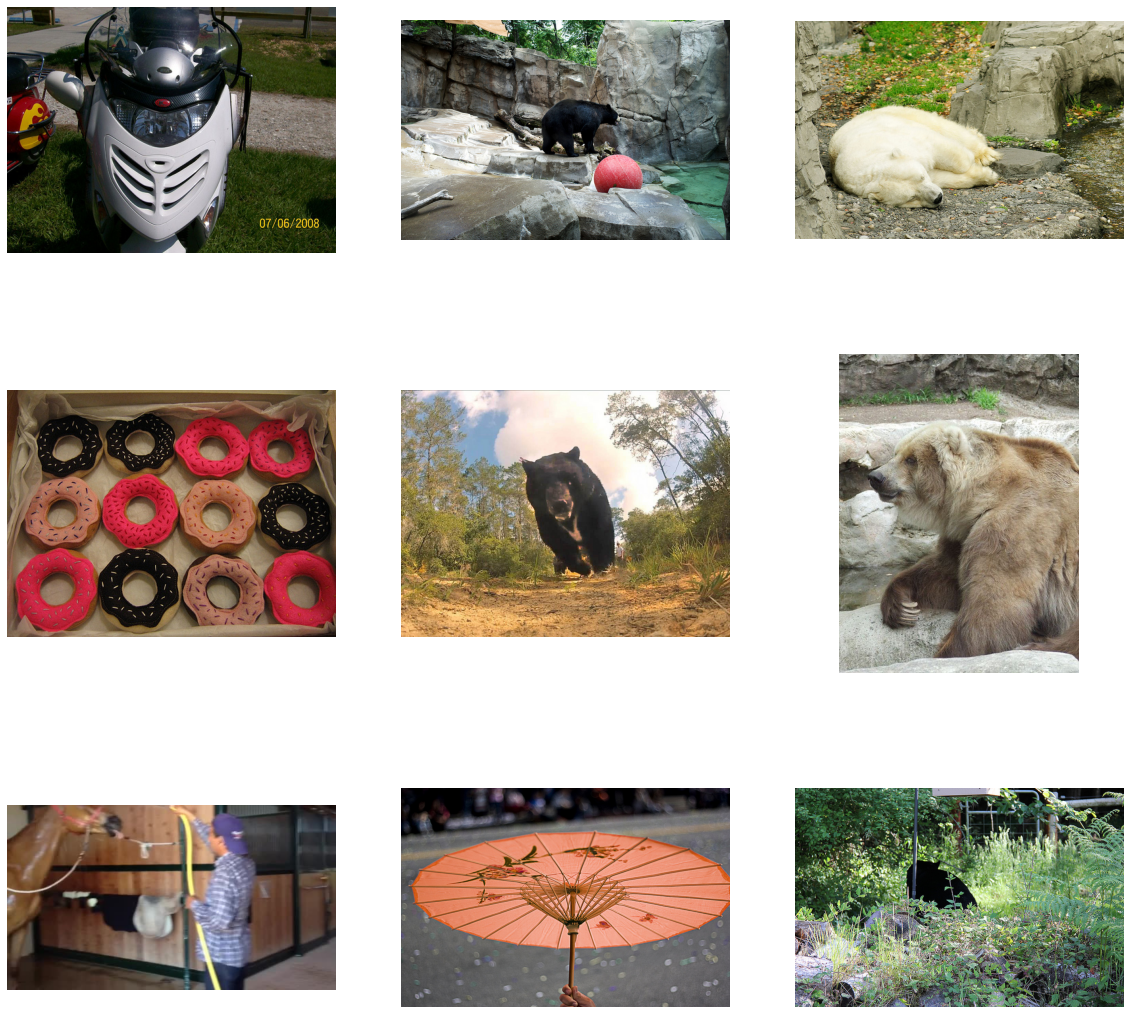

In [38]:
query = "people playing with cats"
matches = find_matches(image_embeddings, [query], normalize=True)[0]

plt.figure(figsize=(20, 20))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(mpimg.imread(matches[i]))
    plt.axis("off")